# ***End-to-End Fetal Health Classification Machine Learning***

In this notebook, we will develop a ML model to predict fetus conditions.

Data from Kaggle: https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification/data

This dataset contains 2126 records of features extracted from Cardiotocogram (CTG) exams, which were then classified by three expert obstetritians into 3 classes:

Normal (1.0)

Suspect (2.0)

Pathological (3.0)

---


**Cardiotocogram (CTG) is an electronic fetal monitoring to monitor Fetal Hearth Rate (FHR) and uterine contractions simultanously.**  

FHR: Babies heart beat's per minute. Typical FHR ranges between 110 and 160 beats per minute.

CTG is a crucial tool in obstetric care and provide valuable information for both mother and baby during or before labor.  

# Table of Contents

PART 1
---


---



    1.   Exploratory Data Analysis /EDA


*   Importing Libraries
*   Dataset Reading
*   Categorical Variable Analysis
*   Numerical Variable Analysis
*   Correlation Matrix


    2.   Data Processing



*   Missing Values
*   Outliers
*   Duplications
*   Encoding Process
*   Standartization


    3.   Base Modelling


*   Logistic Regression
*   KNeighbors Classifier
*   Support Vector Machines (SVC)
*   Decision Tree Classifier
*   Random Forest Classifier
*   Ada Boost Classifier
*   Gradient Boosting Classifier (GBM)
*   XGBoost Classifier (XGBoost)
*   LightGMB Classifier
*   Cat Boost Classifier


    4.   Feature Engineering

*   SMOTE
*   Feature Engineering
    

    5. Modelling

*   Feature Importance


    6.   Final Modelling


*   Hiperparametre Optimization
*   Feature Importance
*   Voting classifier


    6.   Summary & Results


PART 2
---


---

    1. SMOTE W/OUT FEATURE ENGINEERING

* Base modelling
* Learning Curve
    * LightGBM
    * LR
    * SVC
    * KNN


    2. FEATURE ENGINEERING W/OUT SMOTE


* Base modelling
* Learning Curve
    * LightGBM
    * LR
    * SVC
    * KNN


    3. SMOTE + FEATURE ENGINEERING


* Base modelling
* Learning Curve
    * LightGBM
    * LR
    * SVC
    * KNN


    4. Hyperparamater Optimization

# **PART 1**

---




# 1. Exploratory Data Analysis / EDA

Import Libraries
---

In [227]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (classification_report, confusion_matrix, make_scorer, roc_auc_score,
                             accuracy_score, precision_score, recall_score, f1_score)

from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
#!pip install catboost
from catboost import CatBoostClassifier
#!pip install scikit-learn-extra
from sklearn.naive_bayes import GaussianNB


#Smoote
from imblearn.over_sampling import SMOTE

#Don't show lgbm warnings
import logging
logger = logging.getLogger('lightgbm')
logger.setLevel(logging.ERROR)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

All necessary functions for EDA

In [228]:

def check_df(dataframe, head=5):
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### Missing Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def cat_summary(df, col_name):
    print(pd.DataFrame({col_name: df[col_name].value_counts(),
                        "Ratio": 100 * df[col_name].value_counts() / len(df)}))

def cat_plot(df, col):
    df[col].value_counts().sort_values(ascending = False).plot(kind = "bar")
    plt.title(col)
    plt.xticks(rotation = 45)
    plt.show(block = True)
    print("-------------------------------------\n")

def num_plot(df, num_cols):
    for col in num_cols:
        fig, ax = plt.subplots(1, 2, figsize = (12,4))
        fig.suptitle(col)
        sns.histplot(df[col], bins = 20, kde = True, ax = ax[0])
        sns.boxplot(df[col], ax = ax[1])
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.show(block = True)
        print("-------------------------------------\n")

def num_summary(dataframe, numerical_col):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

def target_summary_with_num(df, target_col, num_cols):
    for col in num_cols:
        if col != target_col:
            print(df.groupby(target_col).agg({col: ["mean", "median"]}))
            print("-------------------------------------\n")

def correlation_matrix(df):
    fig = plt.gcf()
    fig.set_size_inches(15, 15)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df.corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def high_correlated_cols(df, num_cols, corr_th = 0.90, plot = False):
    corr = df[num_cols].corr()
    corr_matrix = corr.abs()
    upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype("bool"))
    mask = np.triu(np.ones_like(num_cols, dtype=bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        sns.set(rc = {"figure.figsize": (20,20)})
        sns.heatmap(corr, mask = mask,  cmap = "RdBu", annot = True, fmt=".2f")
        plt.show()
    return drop_list



Dataset Reading
---

In [229]:
df = pd.read_csv("/content/fetal_health.csv")
check_df(df)

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   fl

In [230]:
# Renaming some value columns to make them easier to work with
df = df.rename(columns = {'baseline value':'baseline_value',
                          'percentage_of_time_with_abnormal_long_term_variability': 'abnormal_long_term_variability',
                          'prolongued_decelerations': 'prolonged_decelerations'})

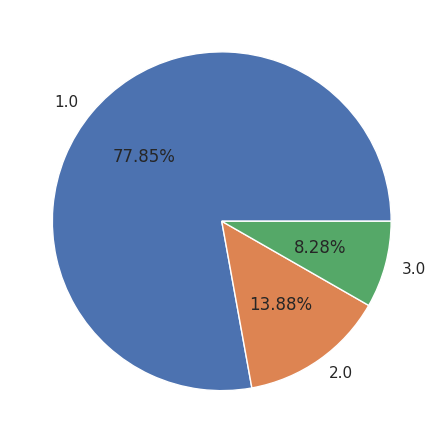

In [231]:
plt.figure(figsize=(5.5,5.5))
plt.pie(
    df["fetal_health"].value_counts(),
    autopct='%.2f%%' ,
    labels=["1.0","2.0", "3.0"]
)
plt.show()


**Variable Infos**


---



***fetal_health***
TARGET

1.0 Normal
2.0 Suspect
3.0 Pathological

***baseline value***

Baseline Fetal Heart Rate (FHR) (beats per minute). Normal/Health fetal Rate between 110 and 160 per minute.

***accelerations***

Number of accelerations per second. Normal/Health between 2 and 5 per minute, 0.033 and 0.083 per second.

***fetal_movement***

Number of fetal movements per second. There is no specific number for fetal movement.

***uterine_contractions***

Number of uterine contractions per second.
during labor: 60-90 seconds per 2 or 3 minutes. 0.33-0.5 per second.
before labor: 30-60 seconds per 10 or 20 minutes. 0.01-0.1 per seconds.

***light_decelerations***

Number of light decelerations per second. Declarations are lasting at least 15 sec and with amplitude exceeding 15 bpm. Light decelerations don't exceed 120 sec.

***severe_decelerations***

Number of severe decelerations per second. Light decelerations exceed 300 sec. Potential important risks for baby health.

***prolongued_decelerations***

Number of prolonged decelerations per second. prolonged decelerations are between 120-300 sec.

***abnormal_short_term_variability***

Percentage of time with abnormal short-term variability. When difference between two adjacent FHR signals is less than 1 bpm, ıt called abnormal.

***mean_value_of_short_term_variability***

Percentage of time with normal short-term variability.

***percentage_of_time_with_abnormal_long_term_variability***

Percentage of time with abnormal long term variability. General value for healthy baby is less than 10%.

***mean_value_of_long_term_variability***

Mean value of long-term variability

***histogram***

Histogram related variables occurred by FHR histogram graph.

histogram_width, histogram_min, histogram_max, histogram_number_of_peaks, histogram_number_of_zeroes, histogram_mode, histogram_mean, histogram_median, histogram_variance histogram_tendency

***histogram_tendency***

Histogram graphs that are tilted to the right are called "positively skewed," while those tilted to the left are called "negatively skewed." If graph is normal, it shown with 0.

Categorical Variable Analysis
---

In [232]:
df.loc[df['fetal_health']==1, 'fetal_health'] = 0
df.loc[df['fetal_health']==2, 'fetal_health'] = 1
df.loc[df['fetal_health']==3, 'fetal_health'] = 2

target_col = "fetal_health"
num_cols = [col for col in df.columns if col not in [target_col]]

In [233]:
check_df(df,10)

##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   baseline_value                        2126 non-null   float64
 1   accelerations                         2126 non-null   float64
 2   fetal_movement                        2126 non-null   float64
 3   uterine_contractions                  2126 non-null   float64
 4   light_decelerations                   2126 non-null   float64
 5   severe_decelerations                  2126 non-null   float64
 6   prolonged_decelerations               2126 non-null   float64
 7   abnormal_short_term_variability       2126 non-null   float64
 8   mean_value_of_short_term_variability  2126 non-null   float64
 9   abnormal_long_term_variability        2126 non-null   float64
 10  mean_value_of_long_term_variability

              fetal_health      Ratio
fetal_health                         
0.0                   1655  77.845720
1.0                    295  13.875823
2.0                    176   8.278457


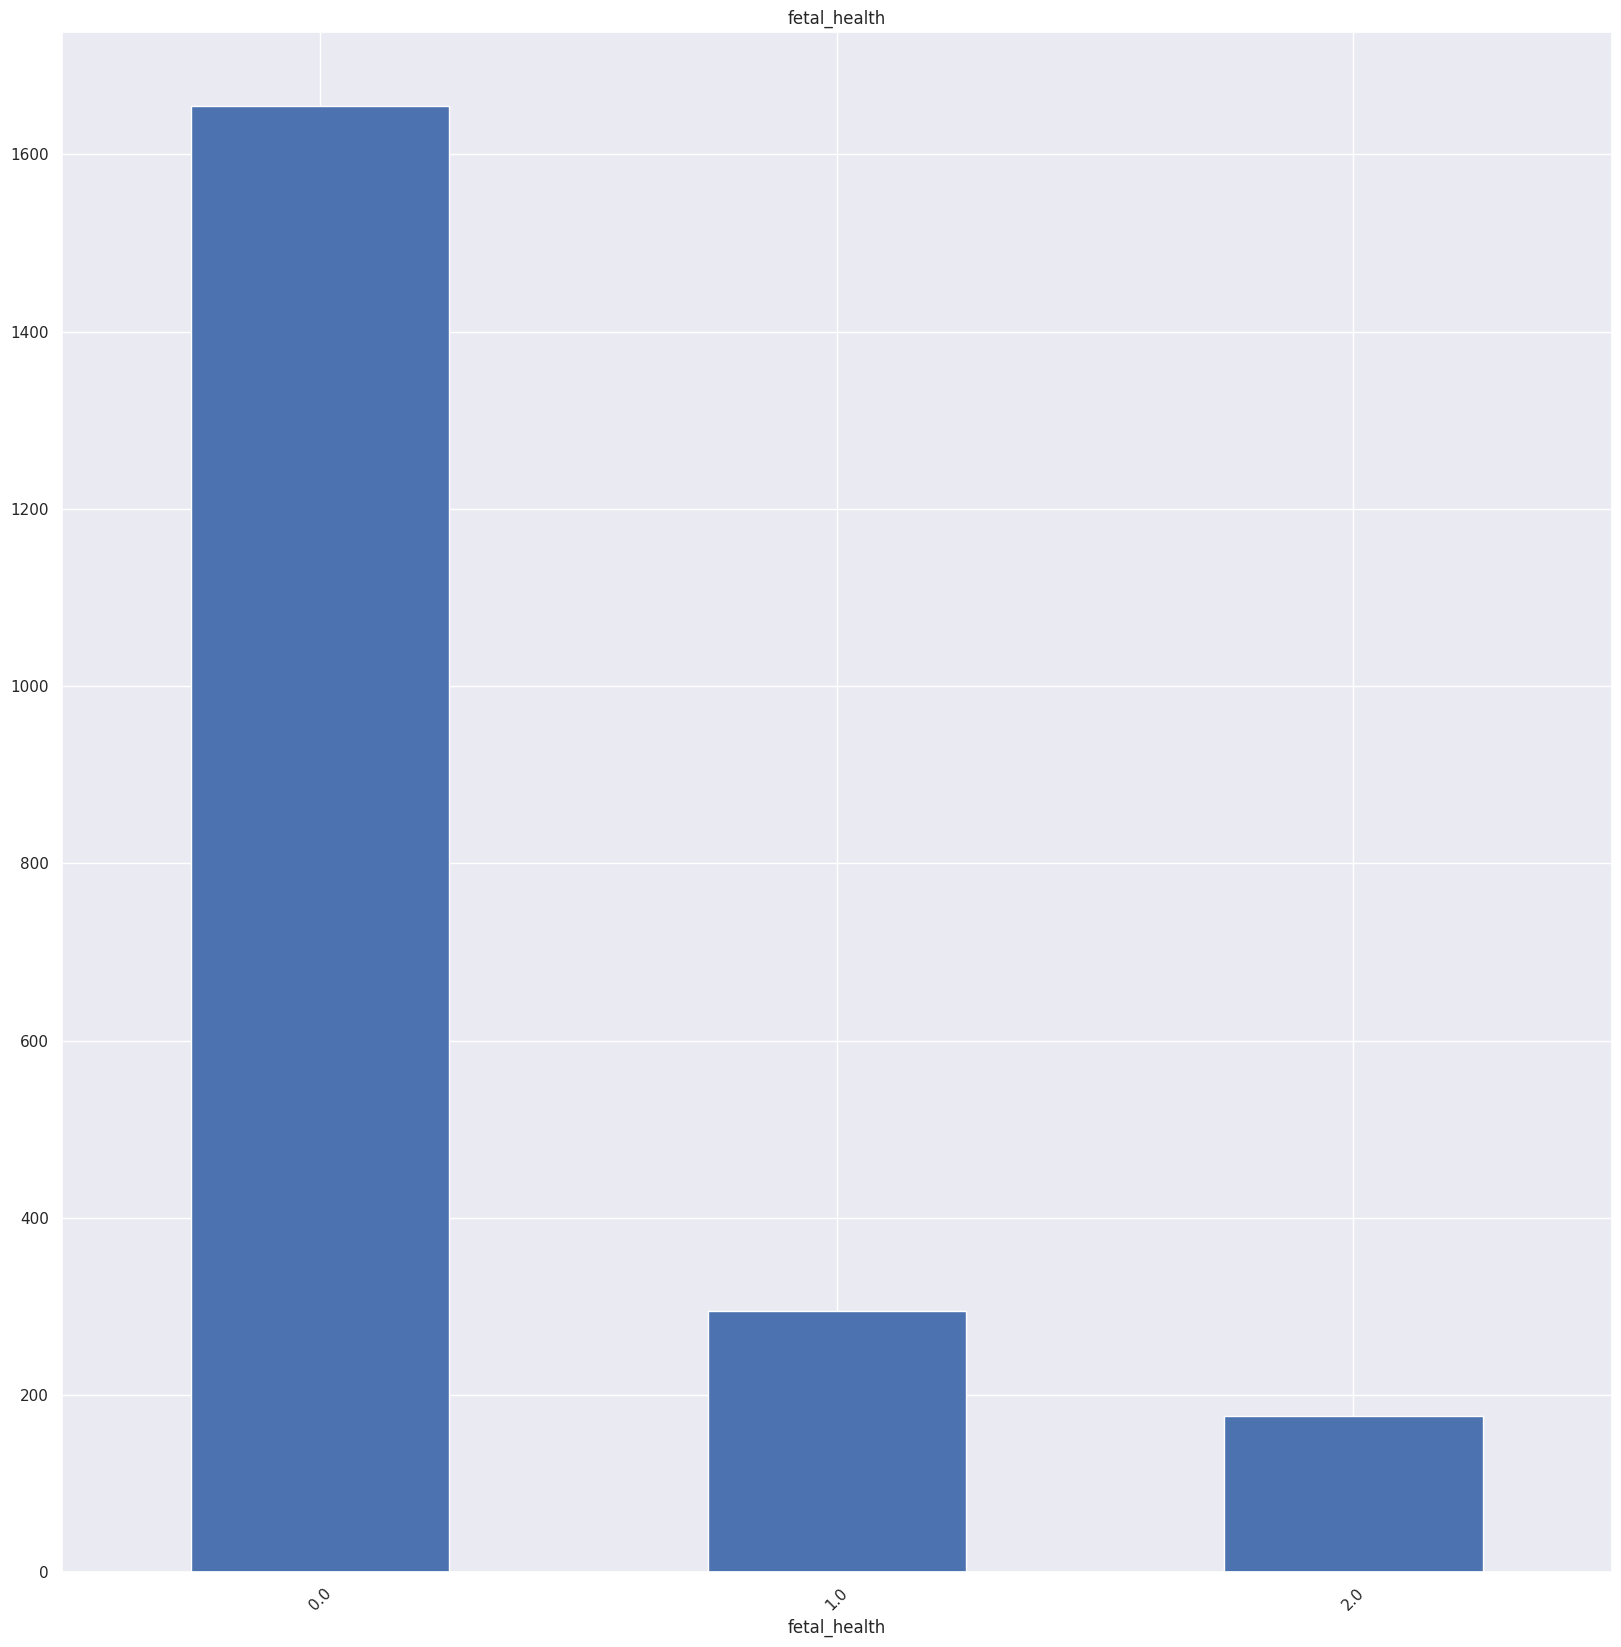

-------------------------------------



In [234]:
#Visulization of Categorical Variables

cat_summary(df, "fetal_health")

cat_plot(df, "fetal_health")

Numerical Variable Analysis
---

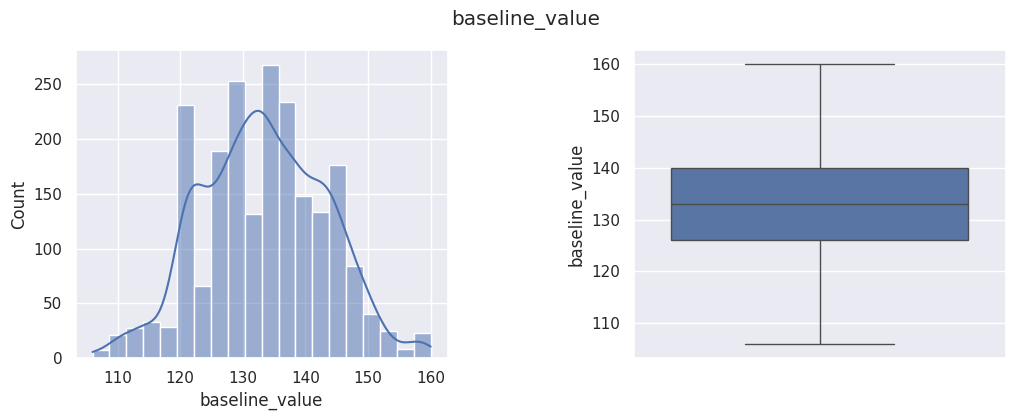

-------------------------------------



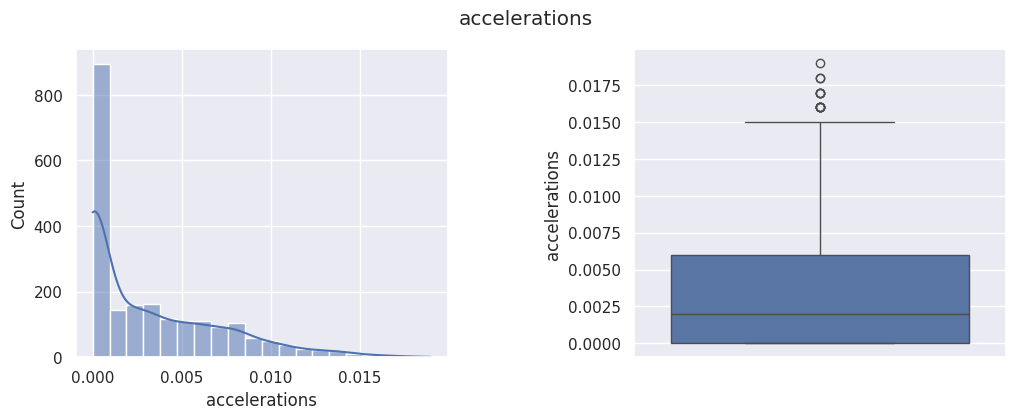

-------------------------------------



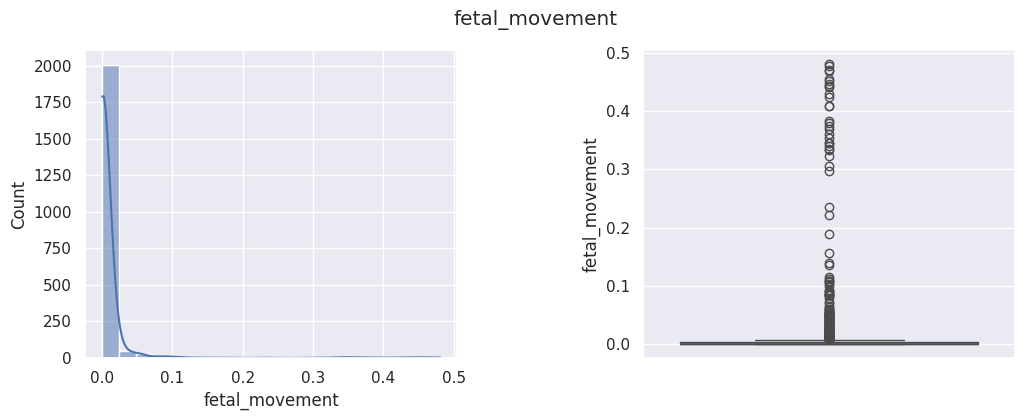

-------------------------------------



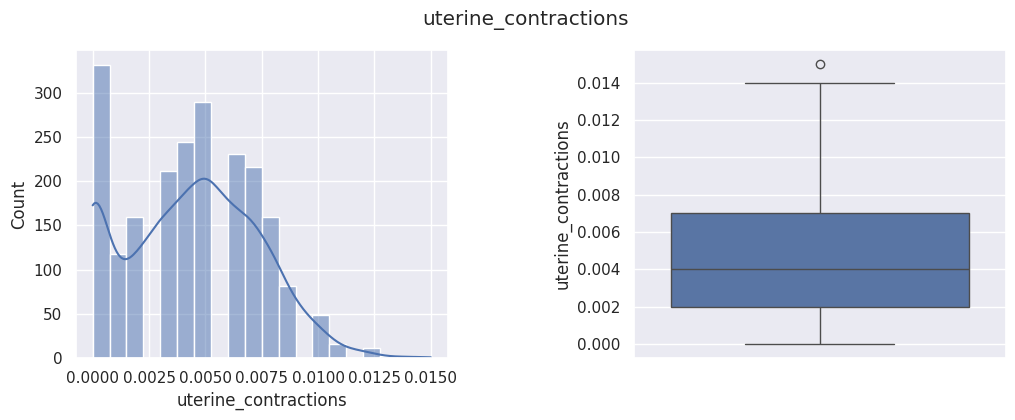

-------------------------------------



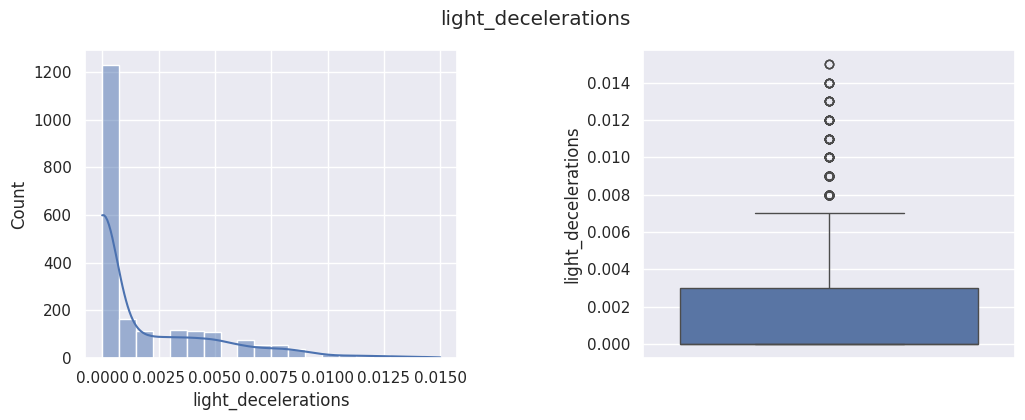

-------------------------------------



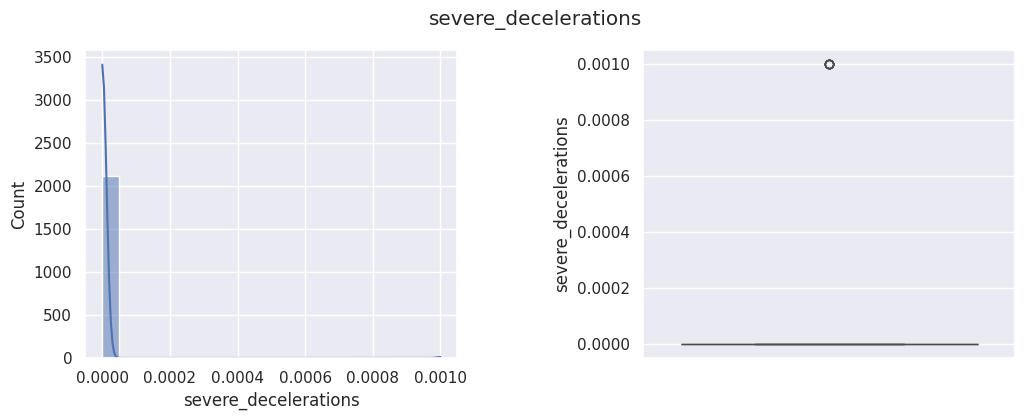

-------------------------------------



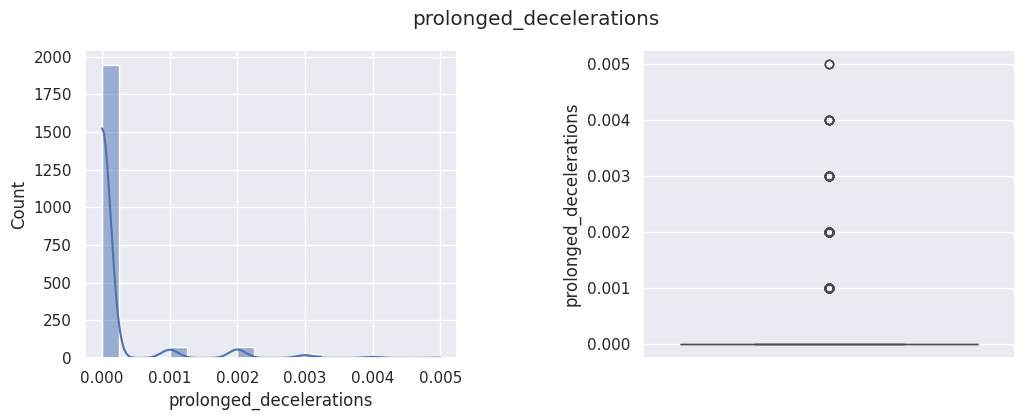

-------------------------------------



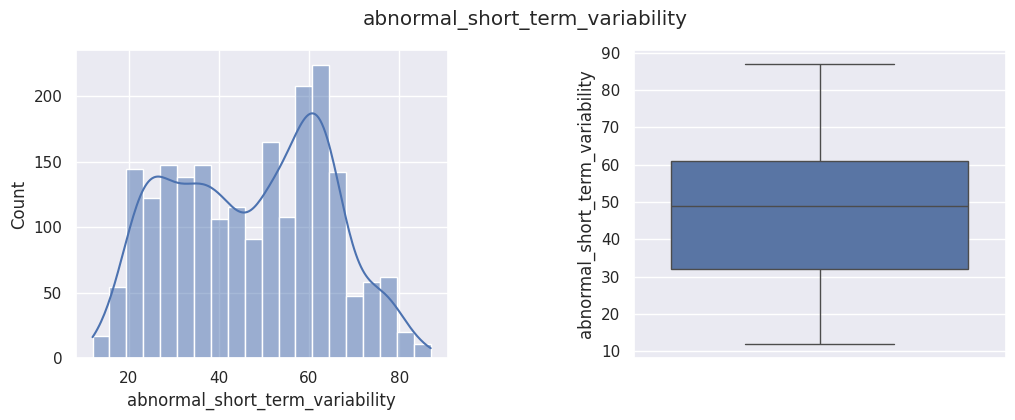

-------------------------------------



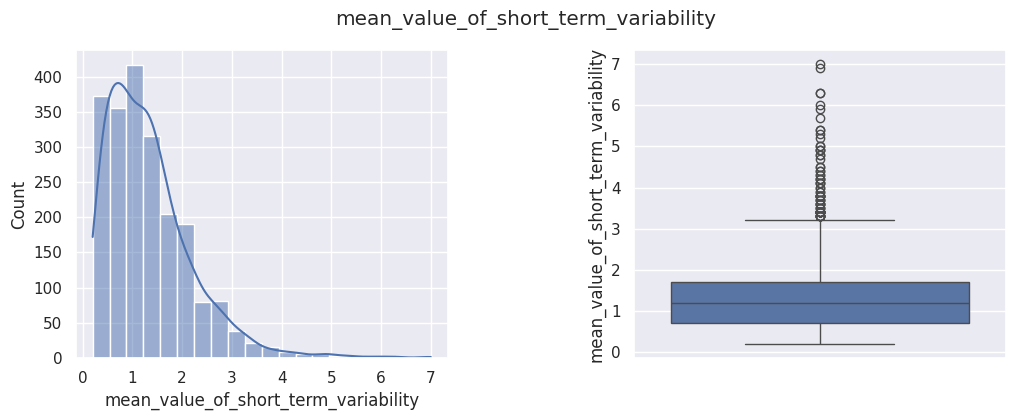

-------------------------------------



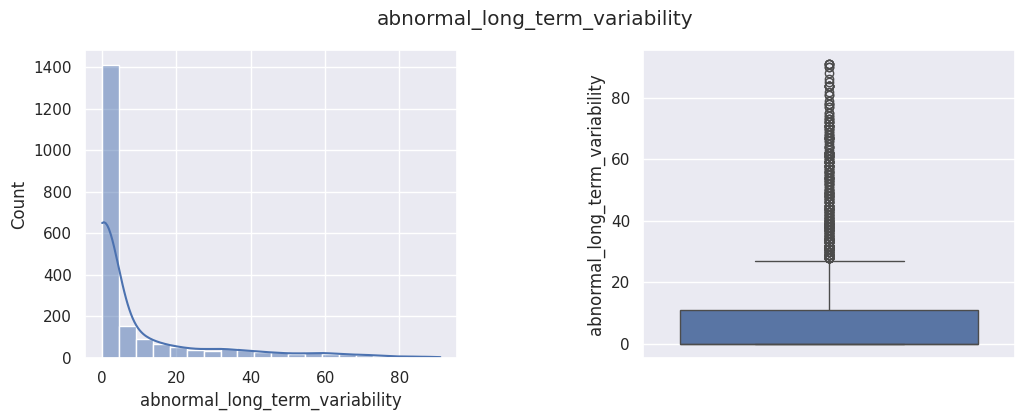

-------------------------------------



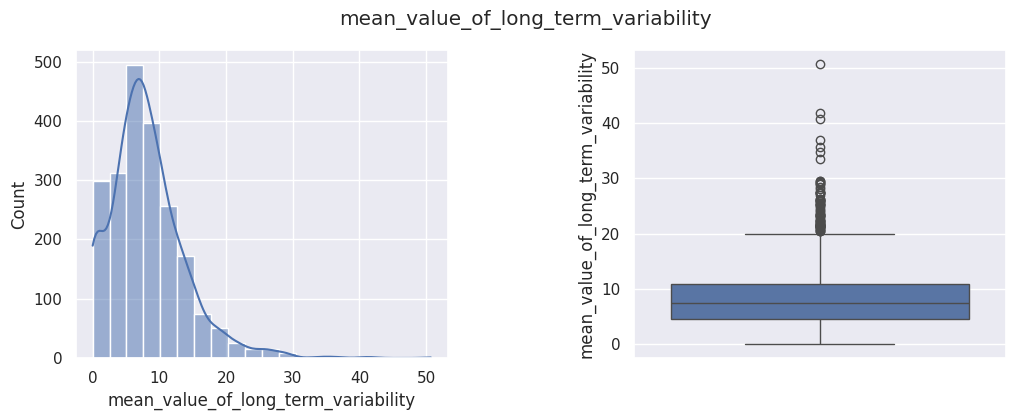

-------------------------------------



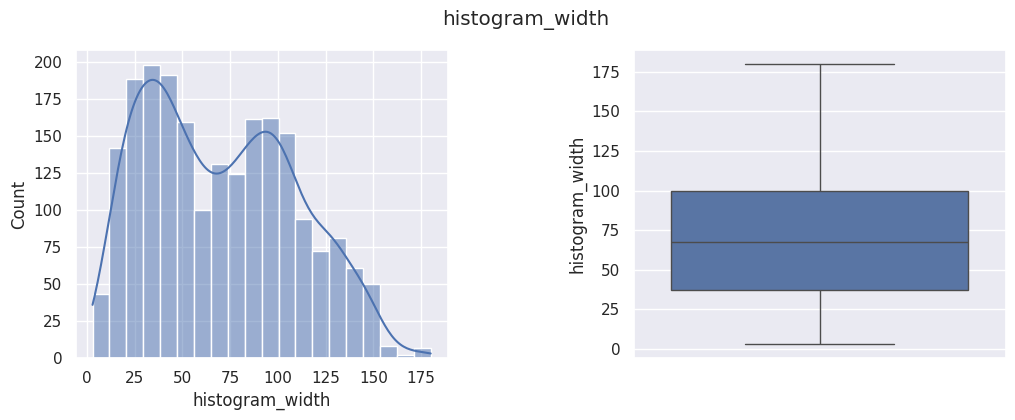

-------------------------------------



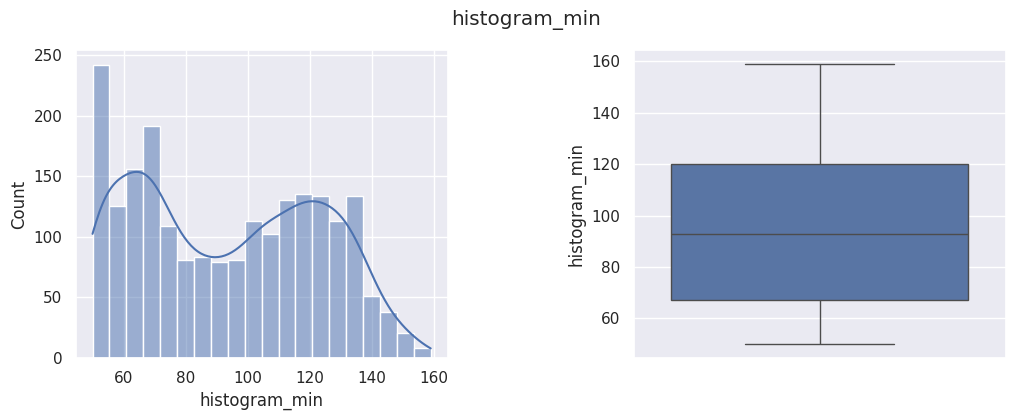

-------------------------------------



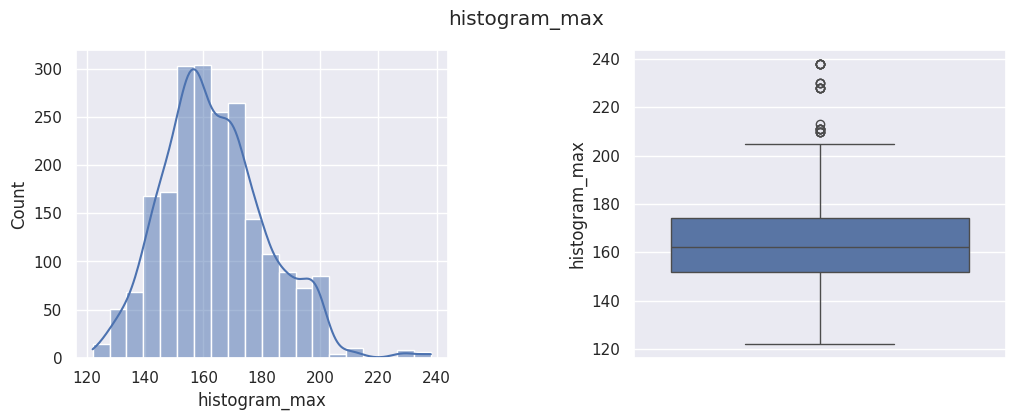

-------------------------------------



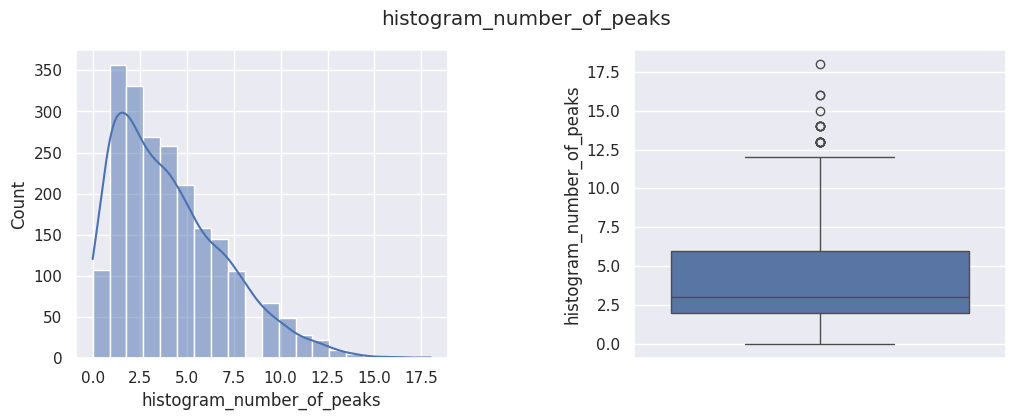

-------------------------------------



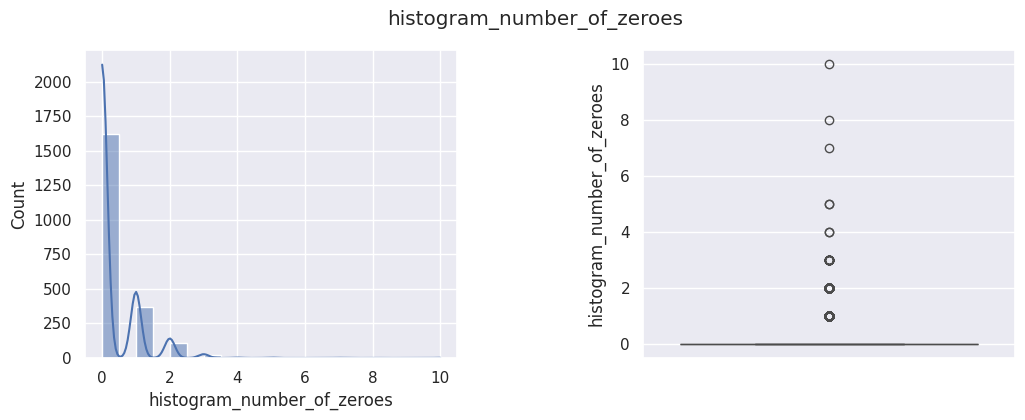

-------------------------------------



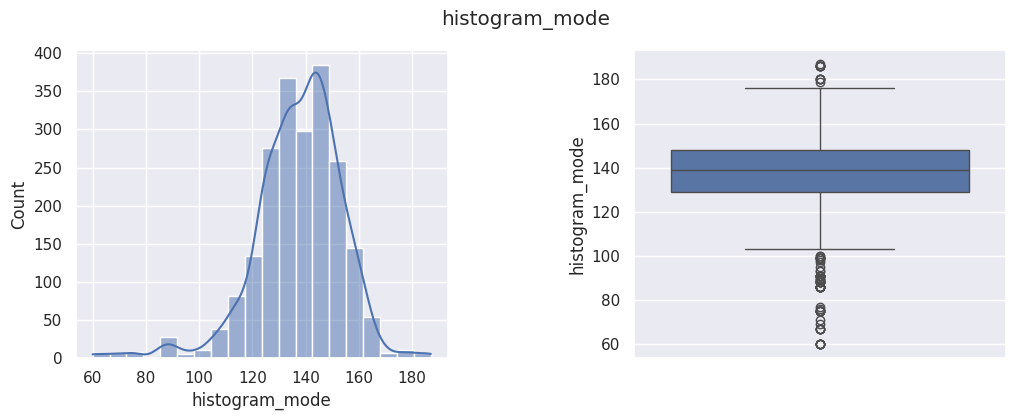

-------------------------------------



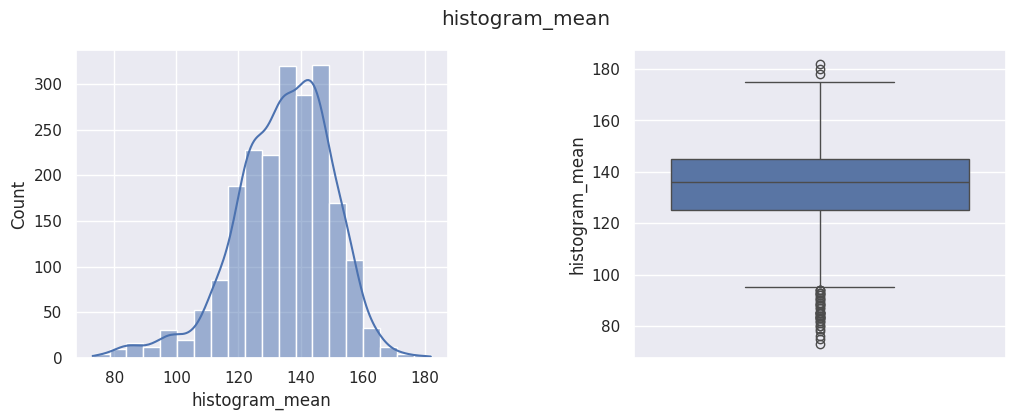

-------------------------------------



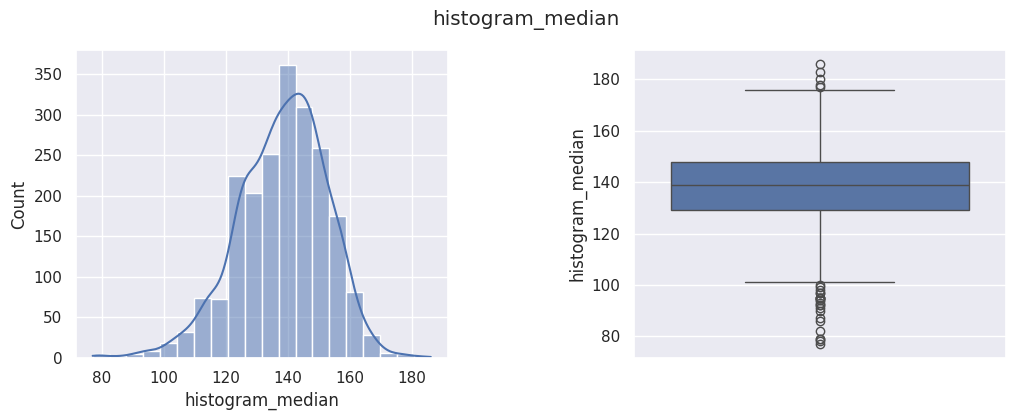

-------------------------------------



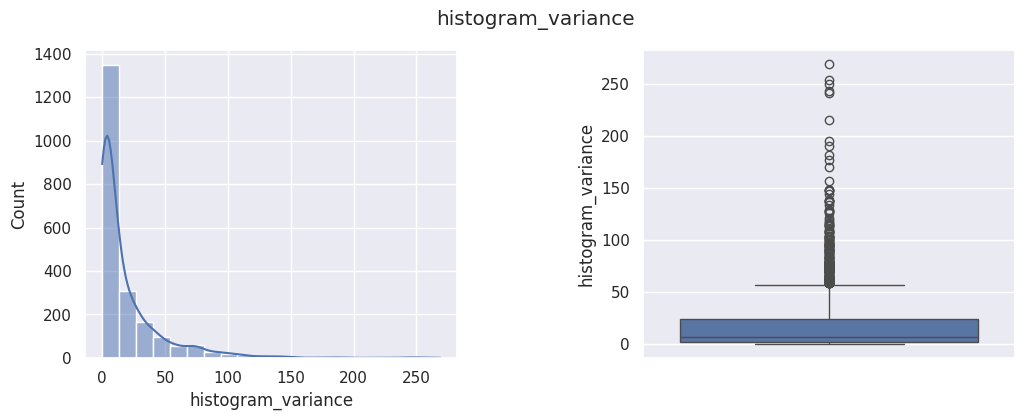

-------------------------------------



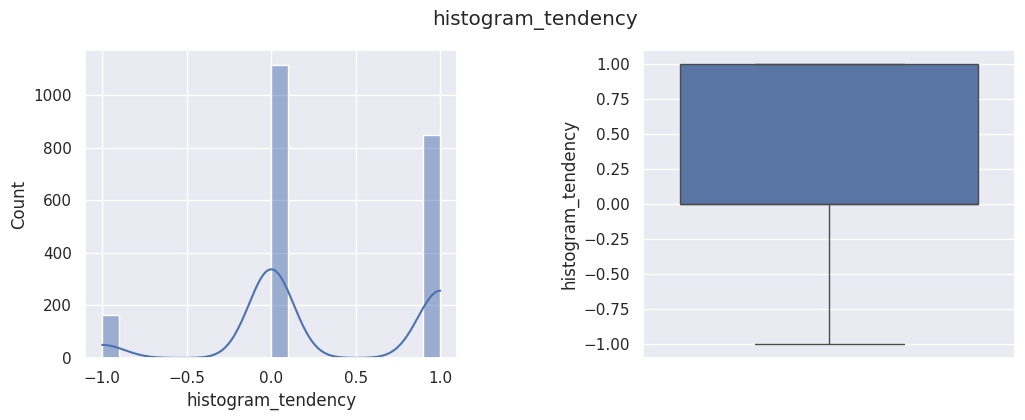

-------------------------------------



In [235]:
#Visulization of Numerical Varibles

num_plot(df,num_cols)

In [236]:
#Information of numerical variables

num_summary(df,num_cols)


                                       count        mean        std    min      5%    10%      20%      30%      40%      50%      60%      70%      80%      90%      95%        99%      max
baseline_value                        2126.0  133.303857   9.840844  106.0  119.00  121.0  125.000  128.000  130.000  133.000  136.000  138.000  142.000  146.000  149.000  158.00000  160.000
accelerations                         2126.0    0.003178   0.003866    0.0    0.00    0.0    0.000    0.000    0.000    0.002    0.003    0.005    0.007    0.009    0.011    0.01500    0.019
fetal_movement                        2126.0    0.009481   0.046666    0.0    0.00    0.0    0.000    0.000    0.000    0.000    0.000    0.002    0.004    0.012    0.028    0.33875    0.481
uterine_contractions                  2126.0    0.004366   0.002946    0.0    0.00    0.0    0.001    0.003    0.004    0.004    0.005    0.006    0.007    0.008    0.009    0.01100    0.015
light_decelerations                   2126.0 

In [237]:
#Numerical analysis of target variables

target_summary_with_num(df, "fetal_health", num_cols)

#baseline value: Although we expected the effect of heart rate on infant health to be high, we found that the mean values were the same in both groups. The reason for this is that the data set is between 110-160, which is what is needed for a healthy baby. We need more data in this direction of the dataset.
#In this dataset, it can be said that infant mortality is related to heart rhythm rather than heart rate.
#It may be possible to associate the mother's contractions with the baby in this dataset, but it would not be correct to fully understand the severity of these contractions as we do not know the gestational age. At this point we need more information about the dataset.
#While we can say that the short-term variation obtained from the histogram graph does not constitute a risk factor, we can say that the long term changes are negatively affected.




             baseline_value       
                       mean median
fetal_health                      
0.0              131.981873  132.0
1.0              141.684746  143.0
2.0              131.687500  132.0
-------------------------------------

             accelerations       
                      mean median
fetal_health                     
0.0               0.003992  0.003
1.0               0.000275  0.000
2.0               0.000392  0.000
-------------------------------------

             fetal_movement       
                       mean median
fetal_health                      
0.0                0.007963  0.000
1.0                0.008332  0.000
2.0                0.025676  0.001
-------------------------------------

             uterine_contractions       
                             mean median
fetal_health                            
0.0                      0.004781  0.005
1.0                      0.002390  0.001
2.0                      0.003784  0.003
-------------

Correlation Matrix
---

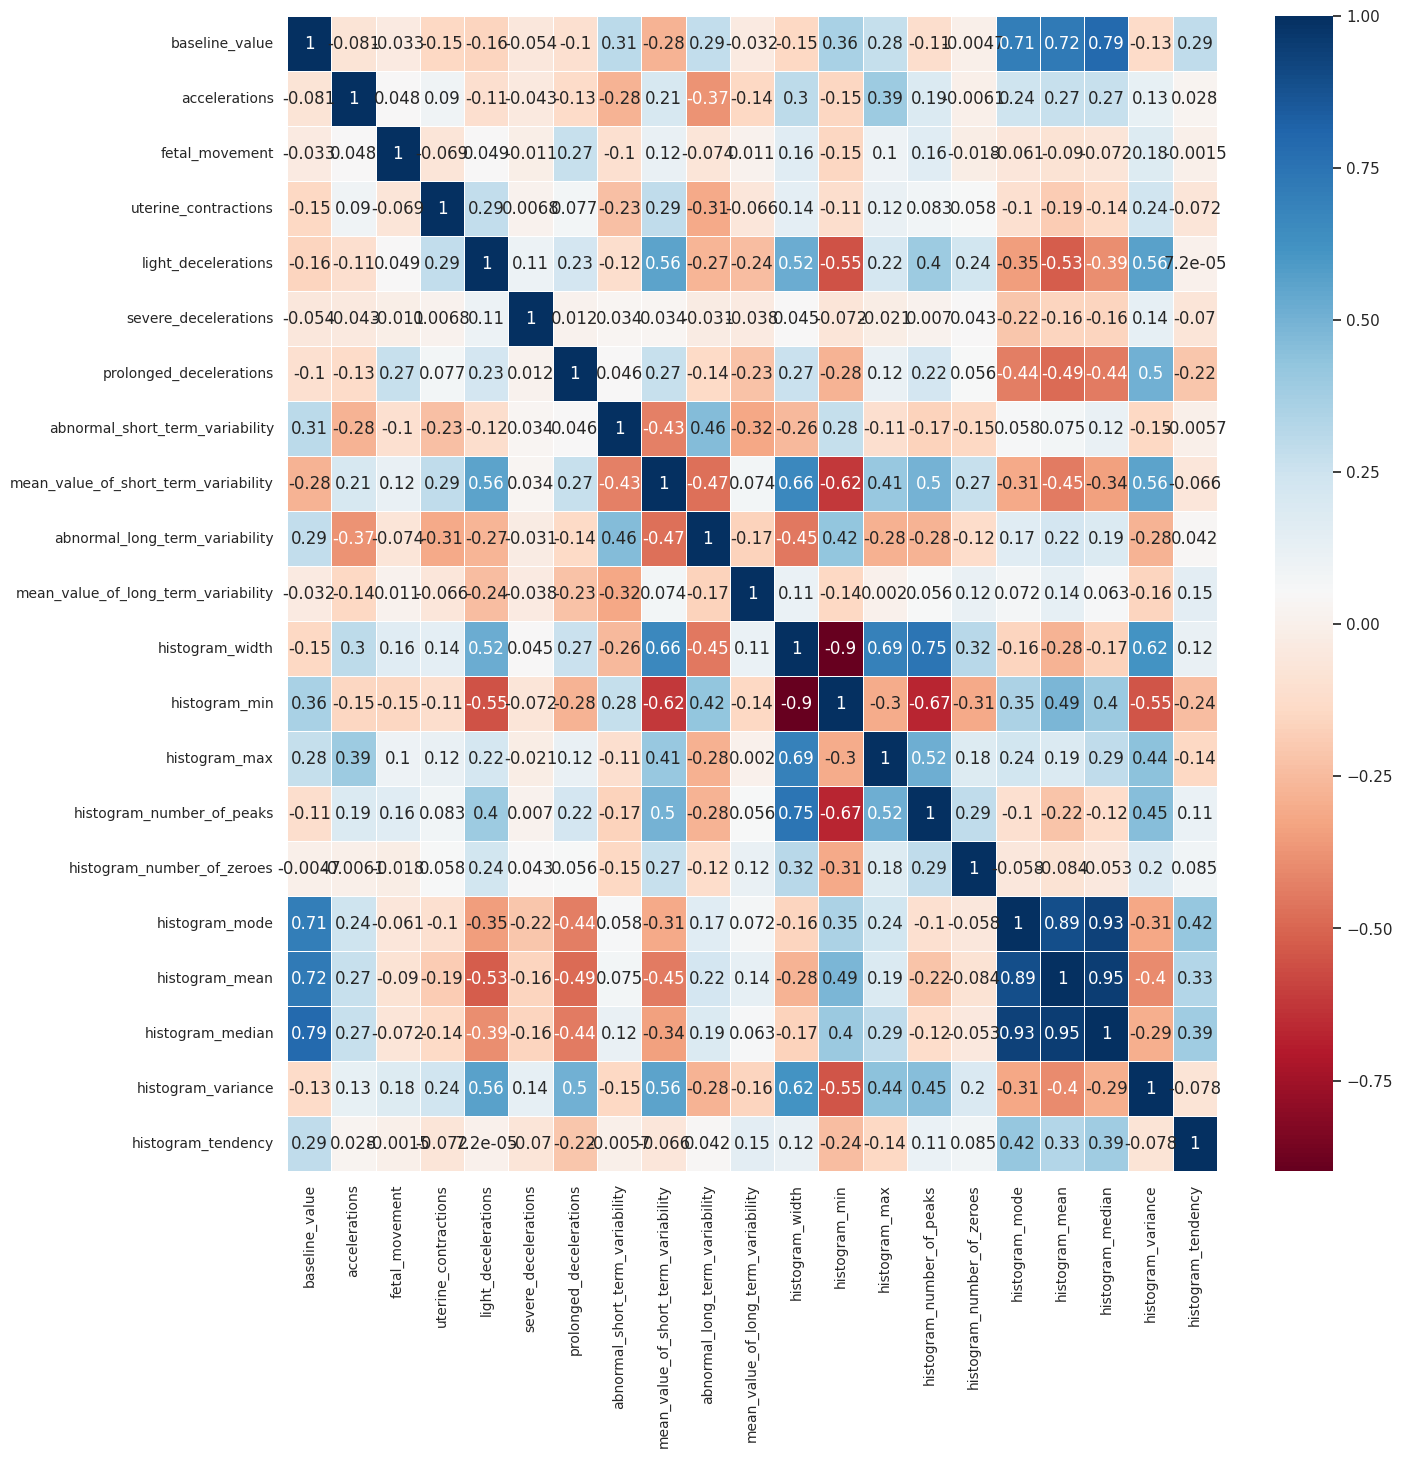

In [238]:
# Full Correlation Matrix for numerical cols
correlation_matrix(df[num_cols])

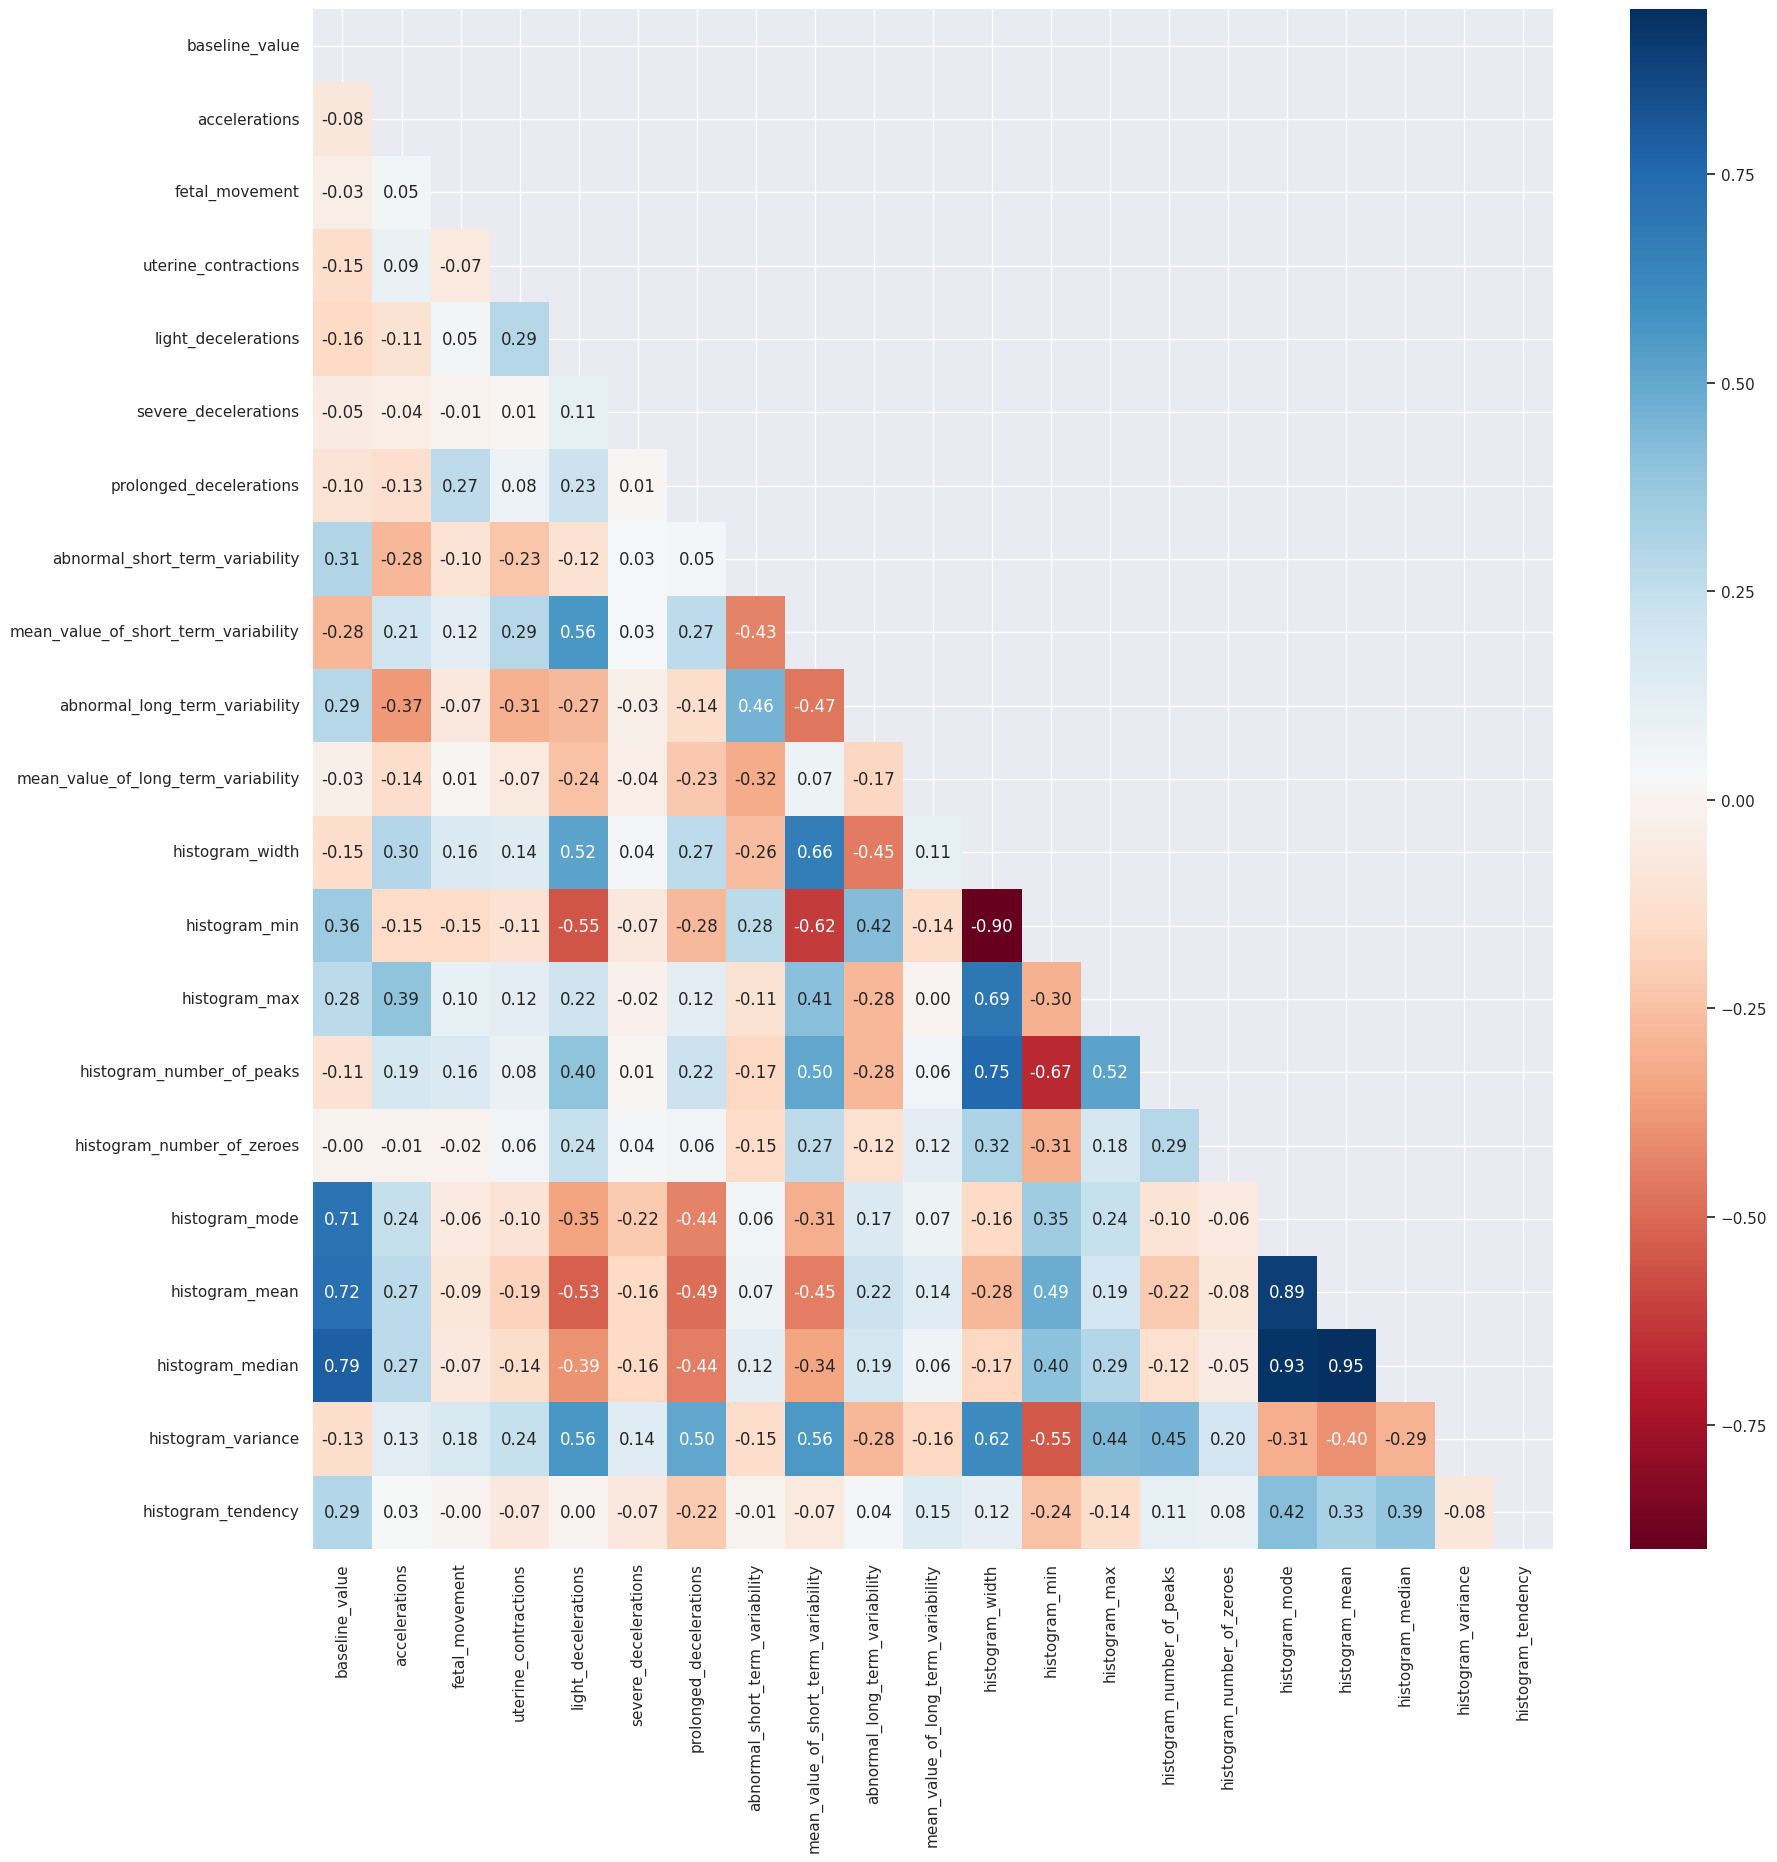

['histogram_median']

In [239]:
# Corelation of variables
high_correlated_cols(df, num_cols, 0.9, True)

#  2. Data Processing

In [240]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dtype = int)
    return dataframe


def lofscores(df, n_neighbors = 20, plot = True):
    df_numeric = df.select_dtypes(include=np.number)

    clf = LocalOutlierFactor(n_neighbors = n_neighbors)
    clf.fit_predict(df_numeric)

    scores = clf.negative_outlier_factor_
    df_scores = pd.DataFrame(np.sort(scores))
    if plot:
        ax = df_scores.plot(stacked = True, xlim = [0,20], style = ".-")
        ax.set_xlabel("Observetions")
        ax.set_ylabel("LOF Values")
        plt.show()
    return scores

Outlier Analysis
---

When we checked the numerical columns, we saw some outliers in the box plot. However, the data set was produced by 3 doctors. Therefore, these outliers could be real clinical variables such as fetal anomalies or maternal conditions.  

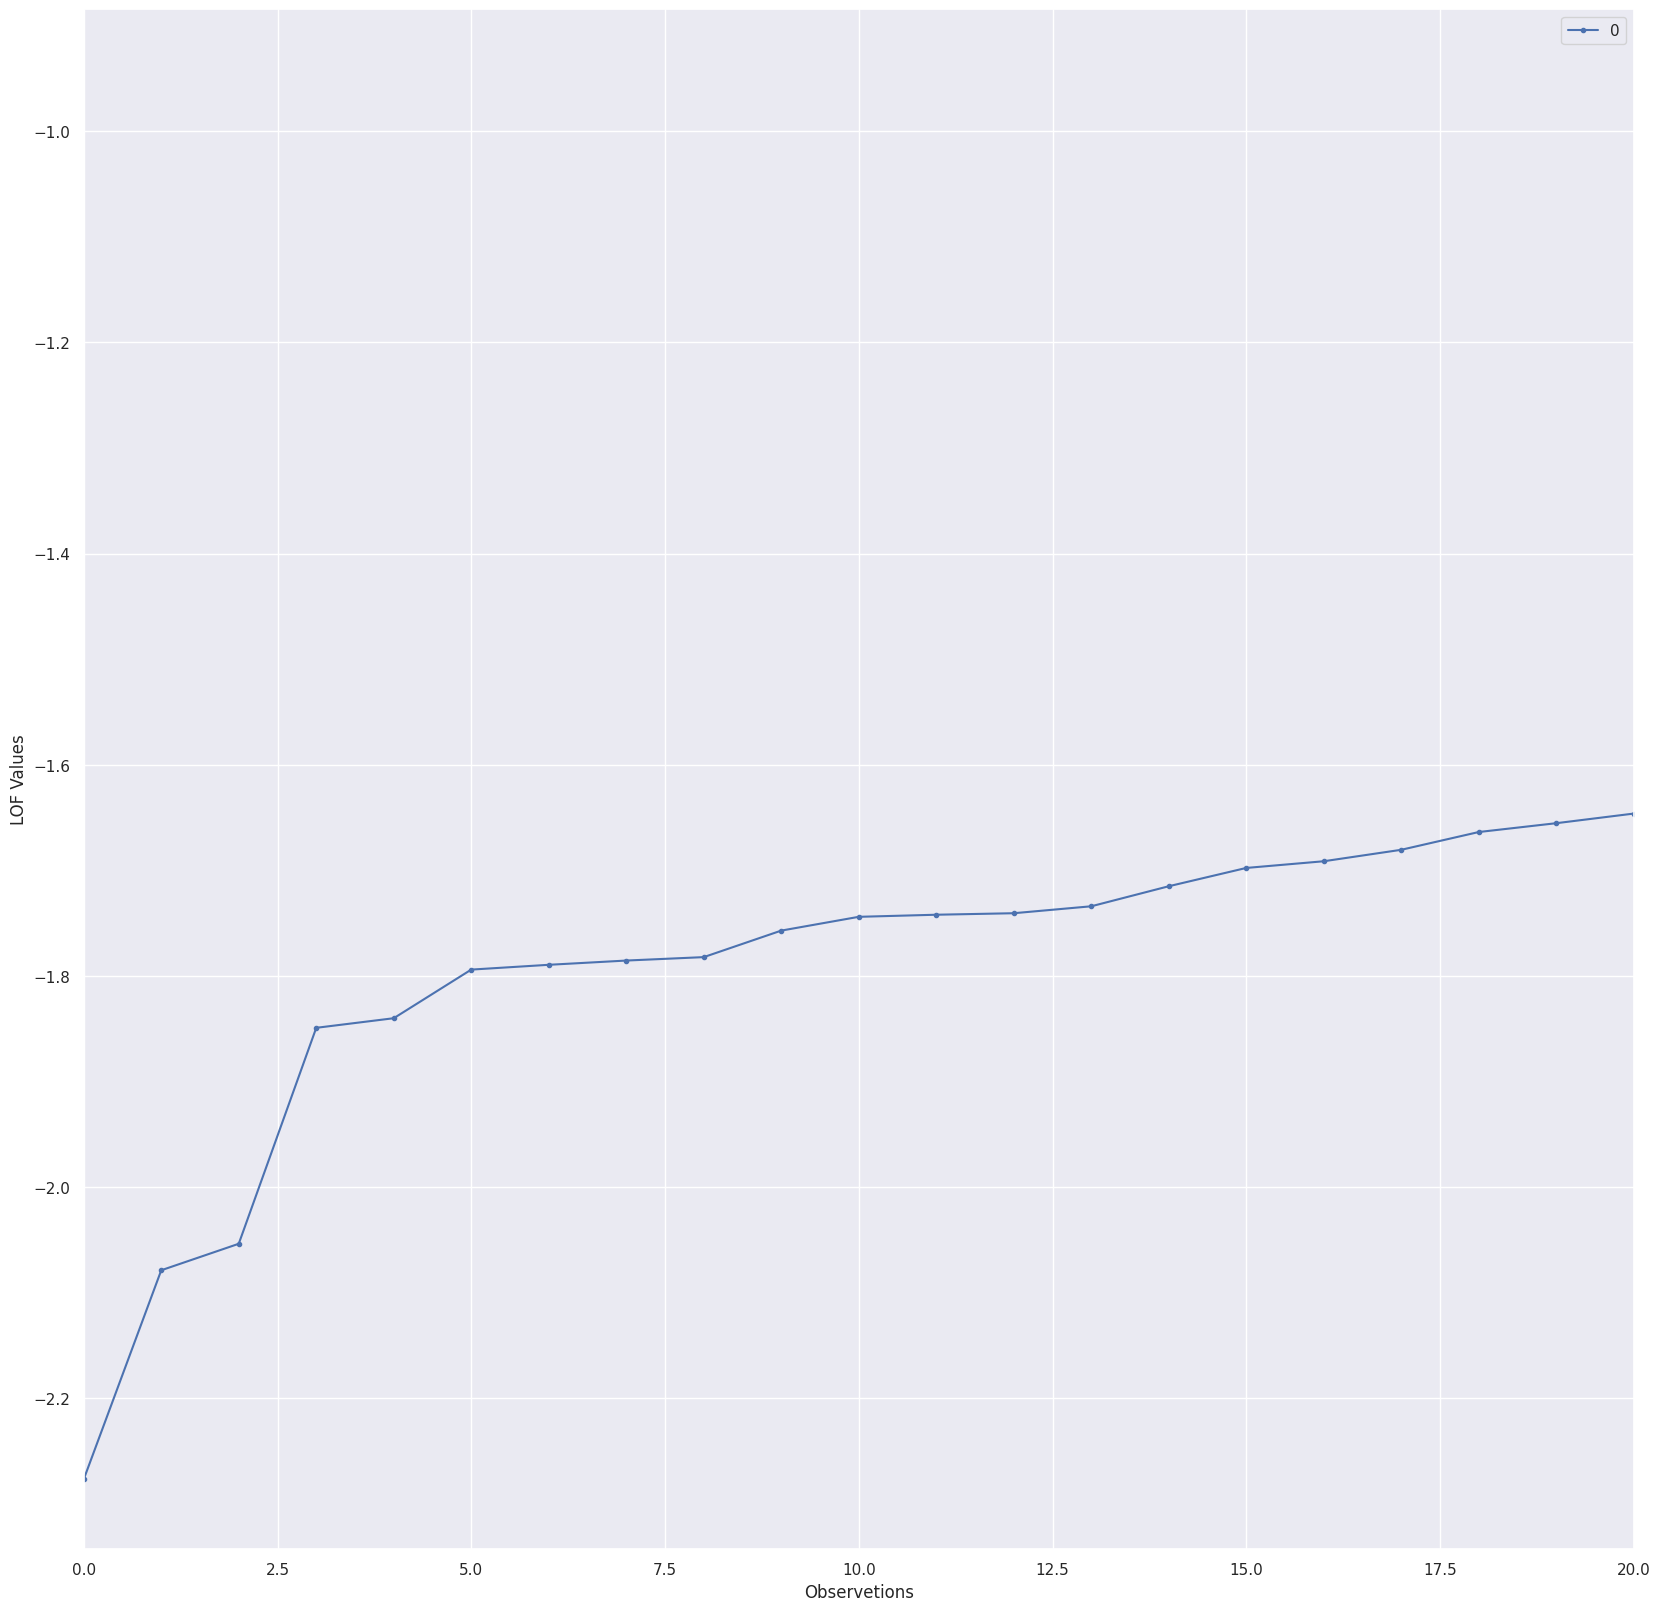

In [241]:
scores = lofscores(df)


Missing Value Analysis
---

There is no missing values.

Duplications
---
Removing duplications in the dataset.

In [242]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(2126, 22)
(2113, 22)


Standartization
---

Standart Scaler was used to minimize overfitting problem.

In [243]:
from sklearn.preprocessing import StandardScaler
X = df.drop("fetal_health", axis=1)
y = df["fetal_health"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Base Modeling

In [244]:
def base_models(X, y, scoring="f1_score"):

    print("Base Models....")
    classifiers = [('LR', LogisticRegression(random_state=42)),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC(random_state=42)),
                   ("CART", DecisionTreeClassifier(random_state=42)),
                   ("RF", RandomForestClassifier(random_state=42)),
                   ('Adaboost', AdaBoostClassifier(random_state=42)),
                   ('GBM', GradientBoostingClassifier(random_state=42)),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state=42)),
                   ('LightGBM', LGBMClassifier(verbose= -1, random_state=42)),
                   ('CatBoost', CatBoostClassifier(verbose=False, random_state=42)),
                   ('GNB', GaussianNB())
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=5, scoring=scoring)
        print(name)
        print(f"f1_score: {round(cv_results['test_f1_score'].mean(), 4)}")
        print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
        print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
        print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
        print("-------------")



In [245]:
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1_score': make_scorer(f1_score, average='weighted')}

base_models(X, y, scoring)

Base Models....
LR
f1_score: 0.8552
Accuracy: 0.8523
Recall: 0.8523
Precision: 0.8702
-------------
KNN
f1_score: 0.8179
Accuracy: 0.8235
Recall: 0.8235
Precision: 0.8267
-------------
SVC
f1_score: 0.8438
Accuracy: 0.8462
Recall: 0.8462
Precision: 0.8578
-------------
CART
f1_score: 0.8322
Accuracy: 0.8263
Recall: 0.8263
Precision: 0.8559
-------------
RF
f1_score: 0.8661
Accuracy: 0.866
Recall: 0.866
Precision: 0.8789
-------------
Adaboost
f1_score: 0.8542
Accuracy: 0.8481
Recall: 0.8481
Precision: 0.8772
-------------
GBM
f1_score: 0.8919
Accuracy: 0.8878
Recall: 0.8878
Precision: 0.9031
-------------
XGBoost
f1_score: 0.8703
Accuracy: 0.865
Recall: 0.865
Precision: 0.8901
-------------
LightGBM
f1_score: 0.8741
Accuracy: 0.8702
Recall: 0.8702
Precision: 0.8915
-------------
CatBoost
f1_score: 0.8749
Accuracy: 0.8712
Recall: 0.8712
Precision: 0.8917
-------------
GNB
f1_score: 0.7446
Accuracy: 0.7118
Recall: 0.7118
Precision: 0.8703
-------------


# 4. Feature Engineering

In [246]:

def smote_df(X, y):
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)
    return X_smote, y_smote


def plotimportance(model, df, num=len(df.columns), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': df.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title(model.__class__.__name__)
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')



SMOTE
---
SMOTE is the method for unbalanced datasets to maximize data to balance each target variable.

Some variables are converted float to int because actually our values are integer not float. We assume that our smote model will be more accurate in this condition. ( But we decided not to do! )

In [247]:
"""
# convering float to integer
hist_cols = [col for col in num_cols if "hist" in col]

int_cols = ["baseline value", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability"]

int_cols = int_cols + hist_cols
print(int_cols)

for col in int_cols:
  df[col] = df[col].astype(int)

df.dtypes
"""

'\n# convering float to integer\nhist_cols = [col for col in num_cols if "hist" in col]\n\nint_cols = ["baseline value", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability"]\n\nint_cols = int_cols + hist_cols\nprint(int_cols)\n\nfor col in int_cols:\n  df[col] = df[col].astype(int)\n\ndf.dtypes\n'

In [248]:
#smote
X = df.drop("fetal_health", axis=1)
y = df["fetal_health"]

X, y = smote_df(X, y)


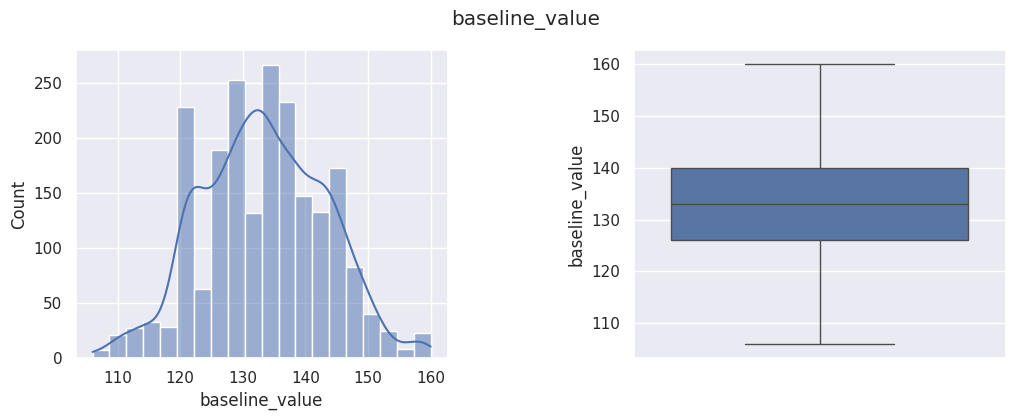

-------------------------------------



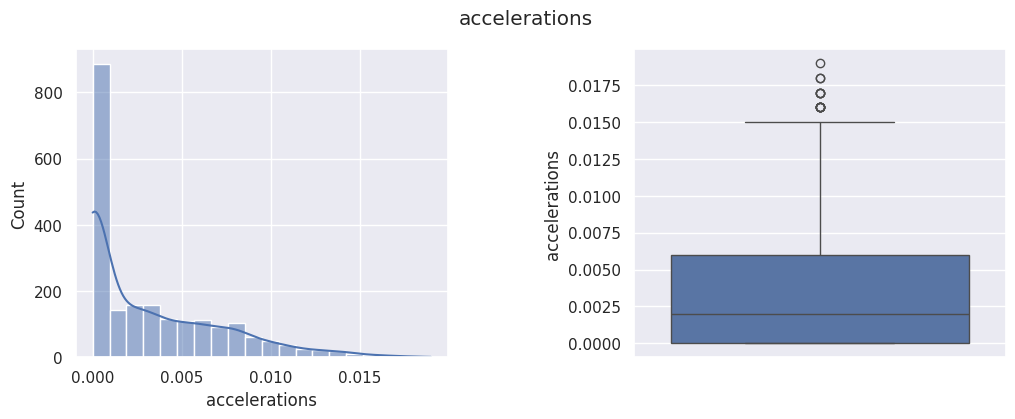

-------------------------------------



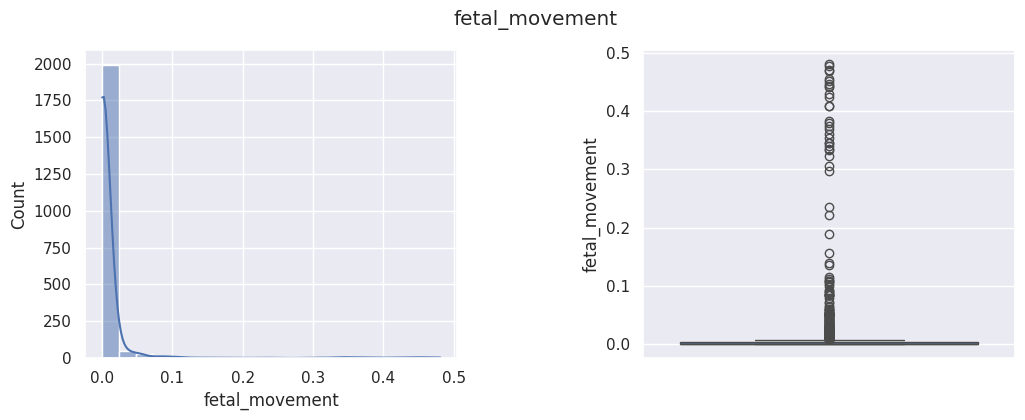

-------------------------------------



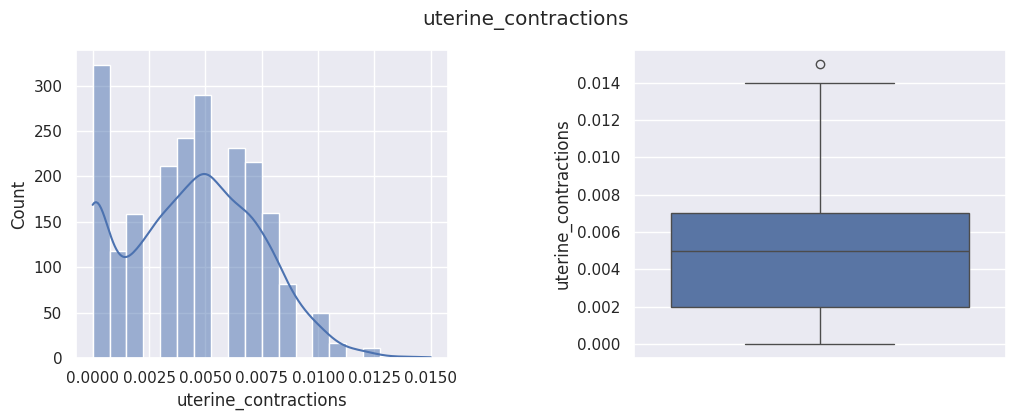

-------------------------------------



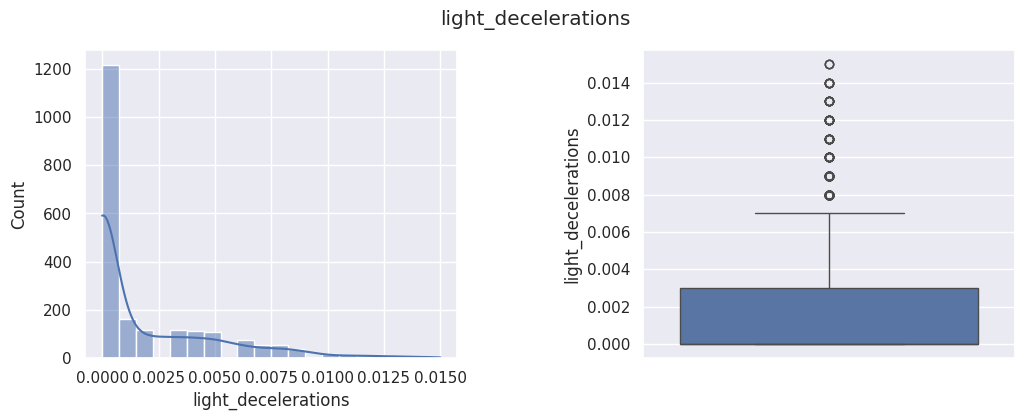

-------------------------------------



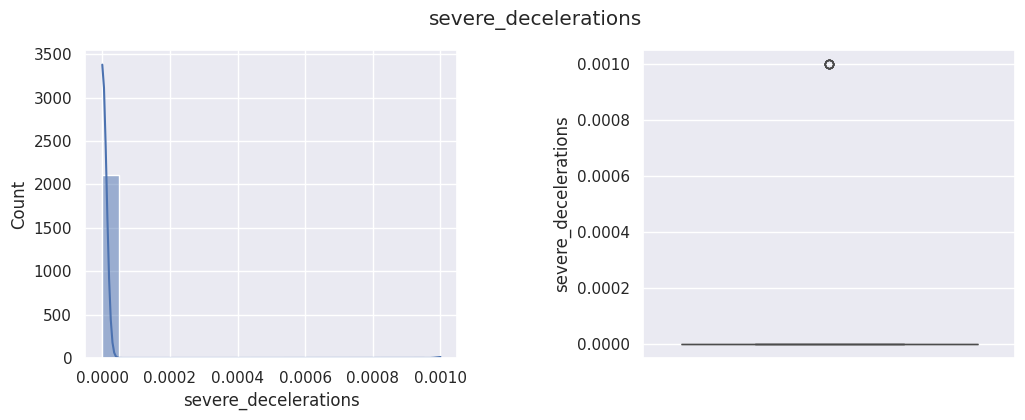

-------------------------------------



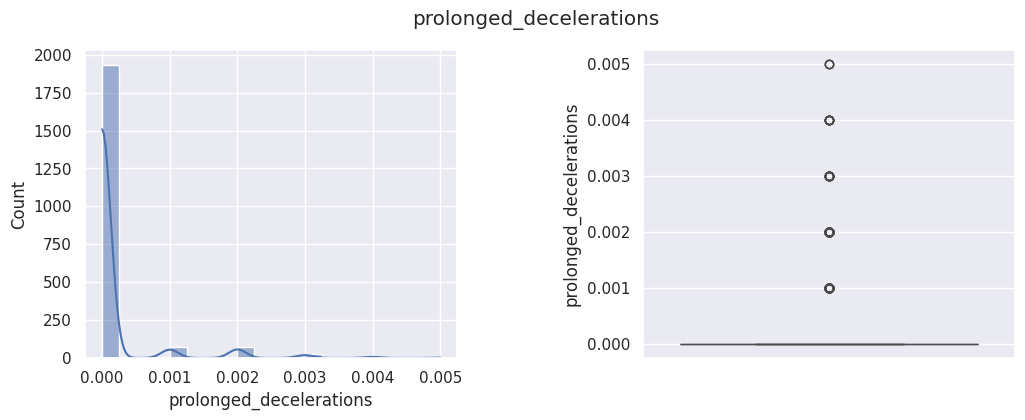

-------------------------------------



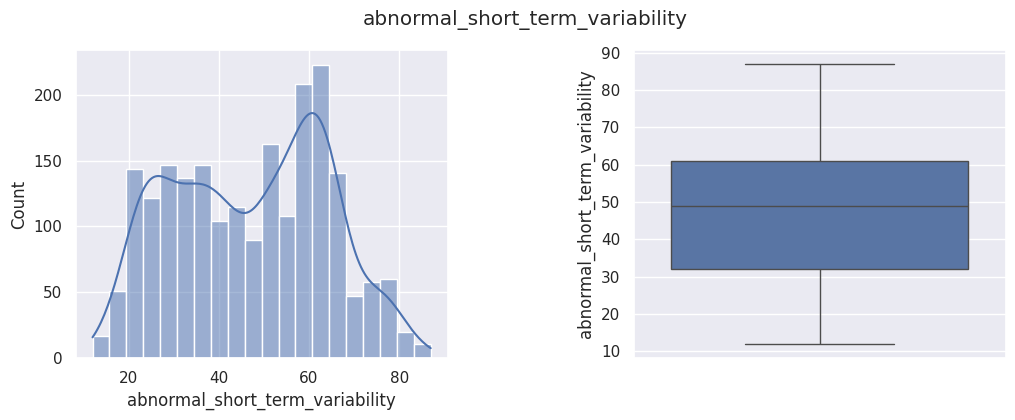

-------------------------------------



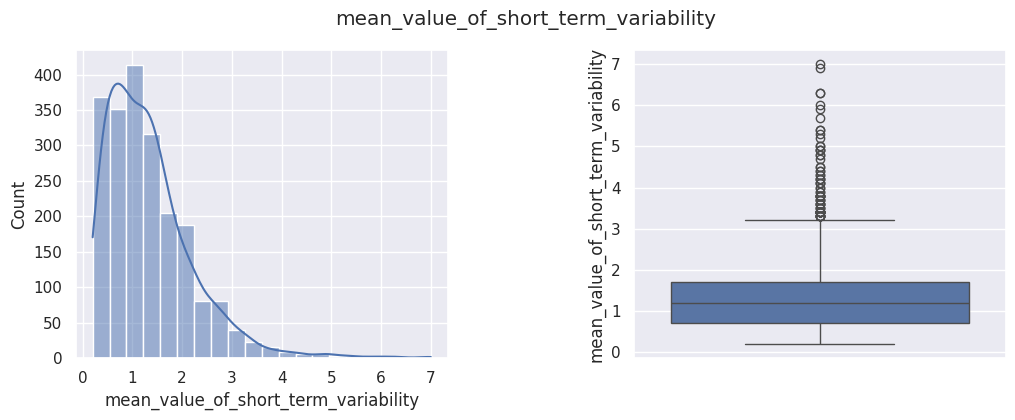

-------------------------------------



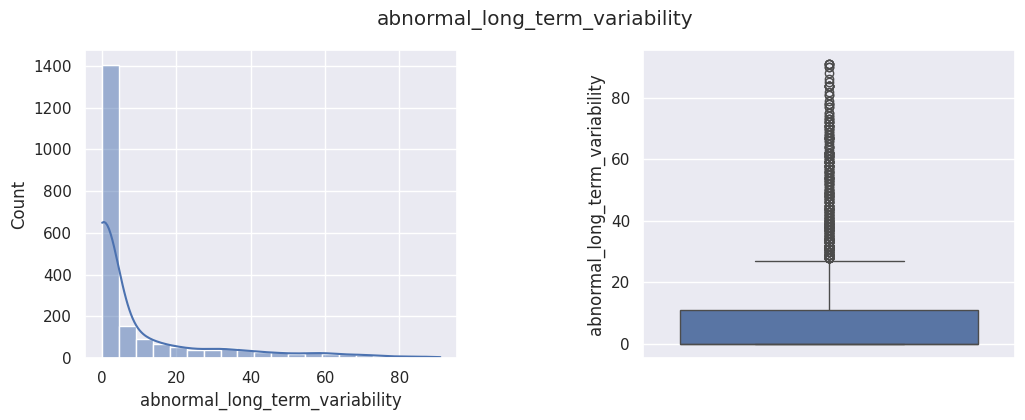

-------------------------------------



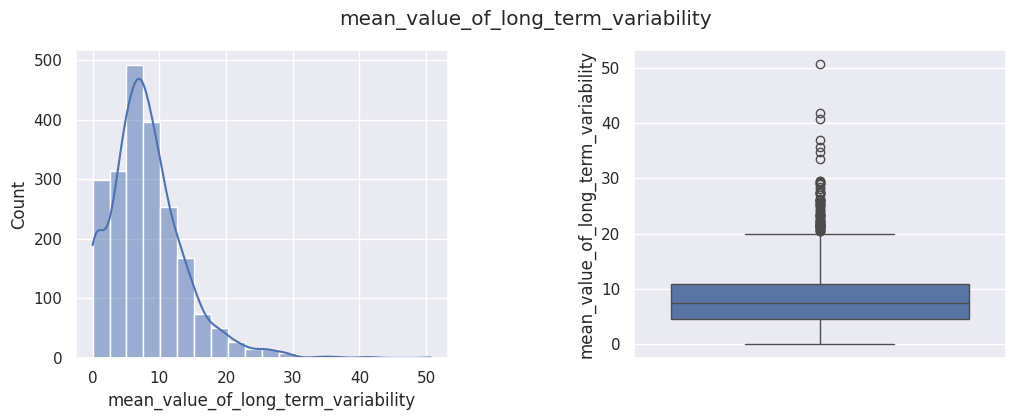

-------------------------------------



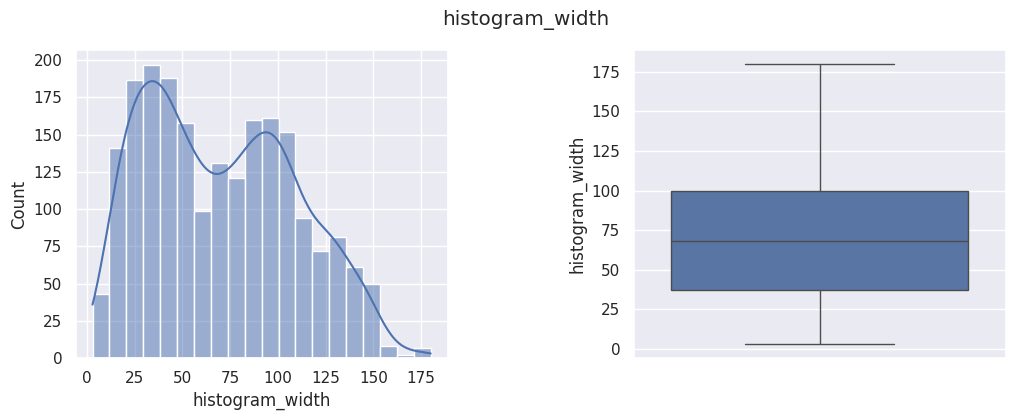

-------------------------------------



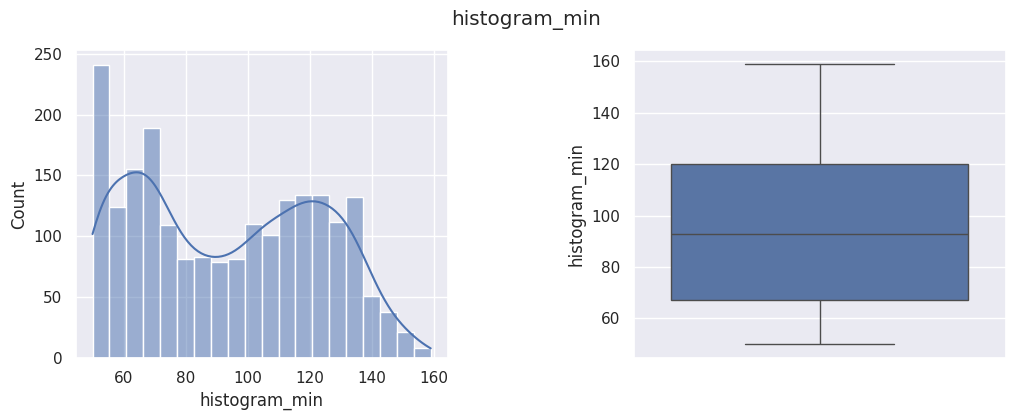

-------------------------------------



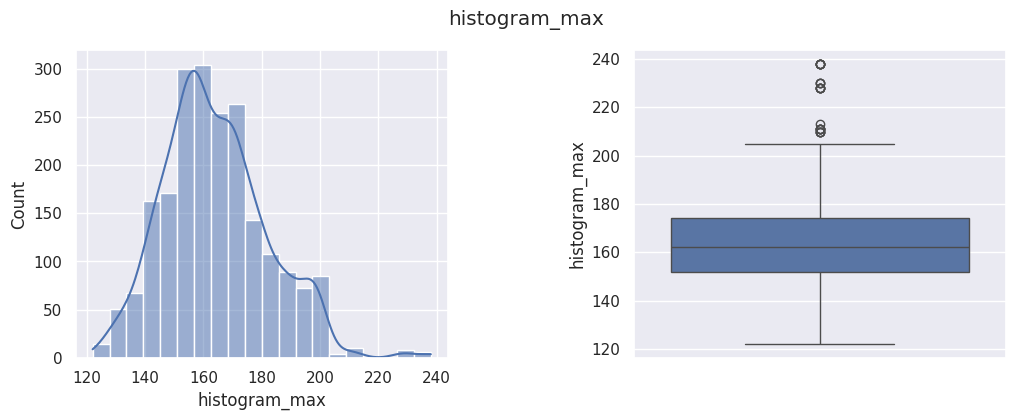

-------------------------------------



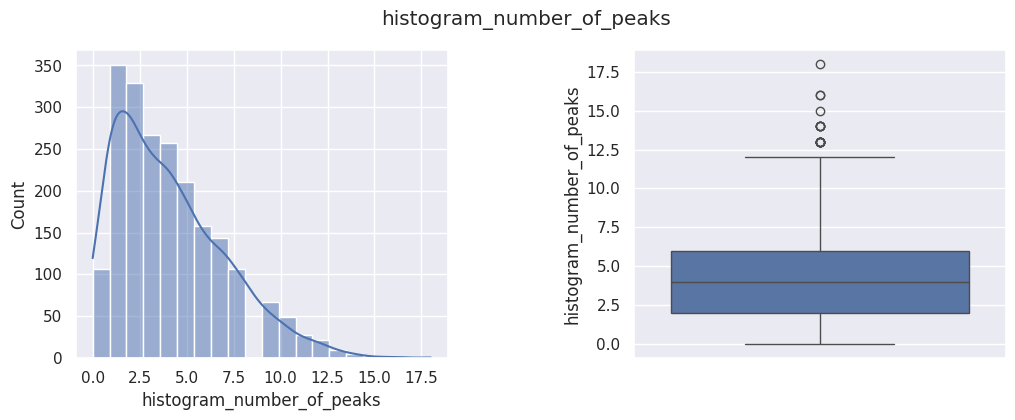

-------------------------------------



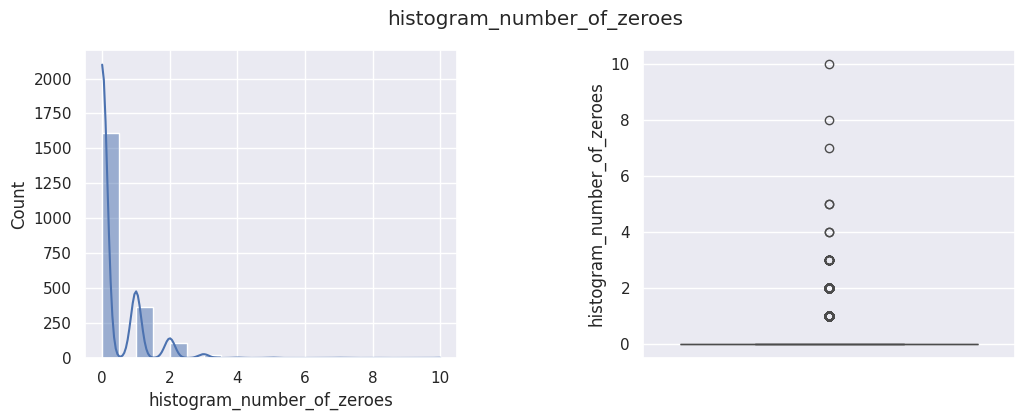

-------------------------------------



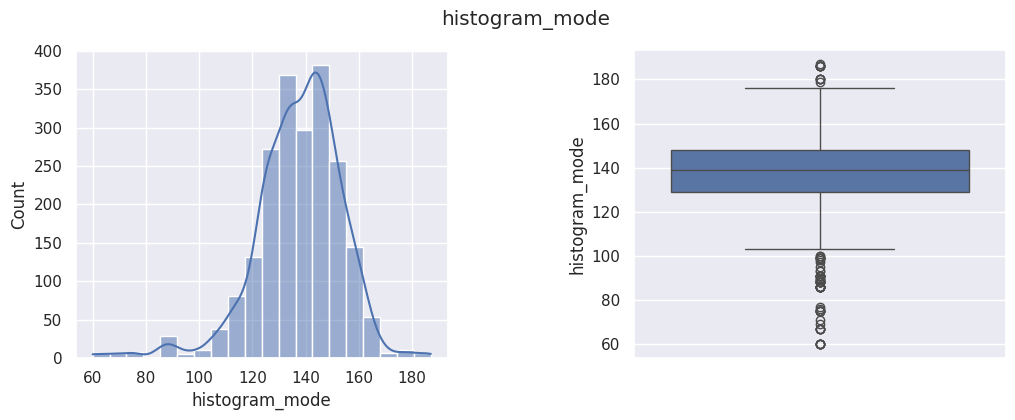

-------------------------------------



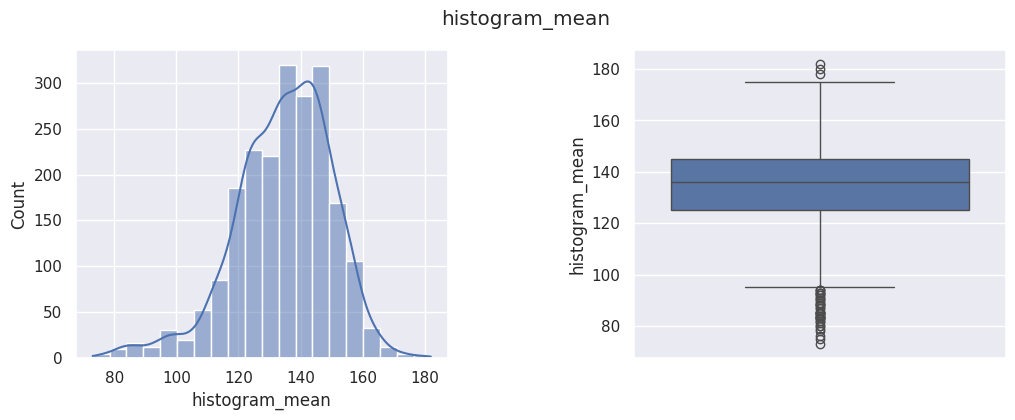

-------------------------------------



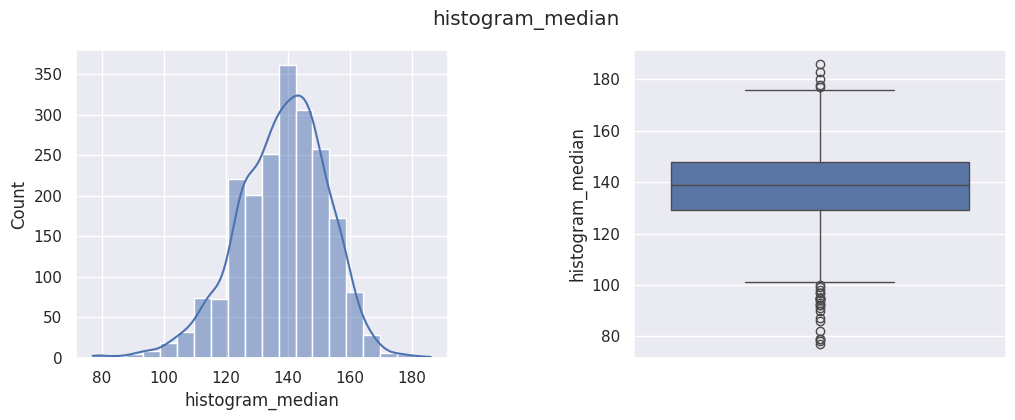

-------------------------------------



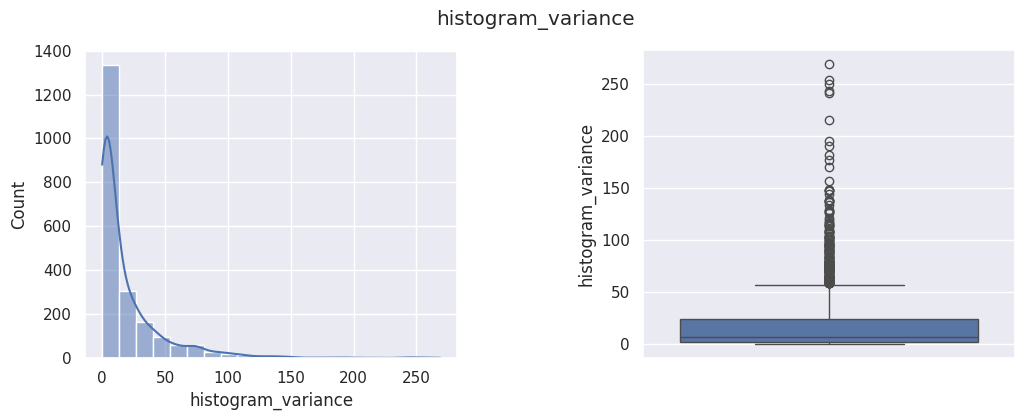

-------------------------------------



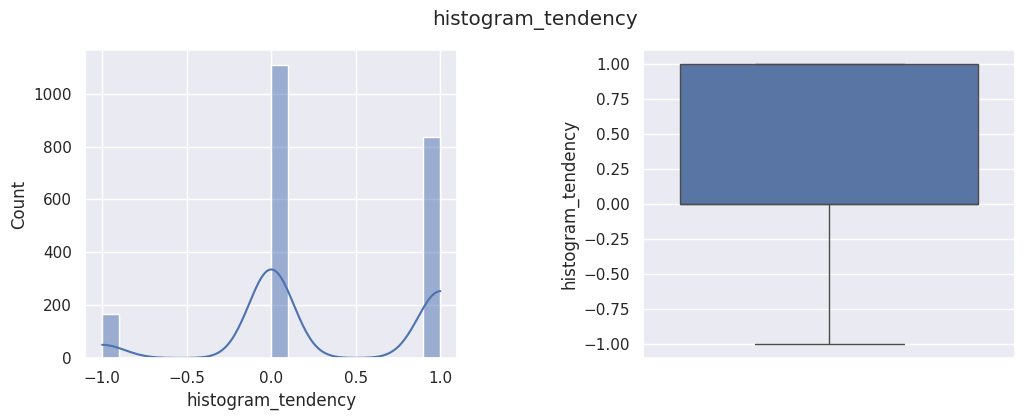

-------------------------------------



In [249]:
#Numerical dataset analysis

num_plot(df, num_cols)


In [250]:
#Target analysis with numerical columns

target_summary_with_num(df, "fetal_health", num_cols)

             baseline_value       
                       mean median
fetal_health                      
0.0              131.998177  132.0
1.0              141.650685  143.0
2.0              131.668571  132.0
-------------------------------------

             accelerations       
                      mean median
fetal_health                     
0.0               0.004002  0.003
1.0               0.000277  0.000
2.0               0.000394  0.000
-------------------------------------

             fetal_movement       
                       mean median
fetal_health                      
0.0                0.008002  0.000
1.0                0.008284  0.000
2.0                0.025823  0.001
-------------------------------------

             uterine_contractions        
                             mean  median
fetal_health                             
0.0                      0.004801  0.0050
1.0                      0.002404  0.0015
2.0                      0.003806  0.0030
-------

Base Modelling
---

In [251]:
X = df.drop("fetal_health", axis=1)
y = df["fetal_health"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

base_models(X, y, scoring)

Base Models....
LR
f1_score: 0.8552
Accuracy: 0.8523
Recall: 0.8523
Precision: 0.8702
-------------
KNN
f1_score: 0.8179
Accuracy: 0.8235
Recall: 0.8235
Precision: 0.8267
-------------
SVC
f1_score: 0.8438
Accuracy: 0.8462
Recall: 0.8462
Precision: 0.8578
-------------
CART
f1_score: 0.8322
Accuracy: 0.8263
Recall: 0.8263
Precision: 0.8559
-------------
RF
f1_score: 0.8661
Accuracy: 0.866
Recall: 0.866
Precision: 0.8789
-------------
Adaboost
f1_score: 0.8542
Accuracy: 0.8481
Recall: 0.8481
Precision: 0.8772
-------------
GBM
f1_score: 0.8919
Accuracy: 0.8878
Recall: 0.8878
Precision: 0.9031
-------------
XGBoost
f1_score: 0.8703
Accuracy: 0.865
Recall: 0.865
Precision: 0.8901
-------------
LightGBM
f1_score: 0.8741
Accuracy: 0.8702
Recall: 0.8702
Precision: 0.8915
-------------
CatBoost
f1_score: 0.8749
Accuracy: 0.8712
Recall: 0.8712
Precision: 0.8917
-------------
GNB
f1_score: 0.7446
Accuracy: 0.7118
Recall: 0.7118
Precision: 0.8703
-------------


Feature Importance
---

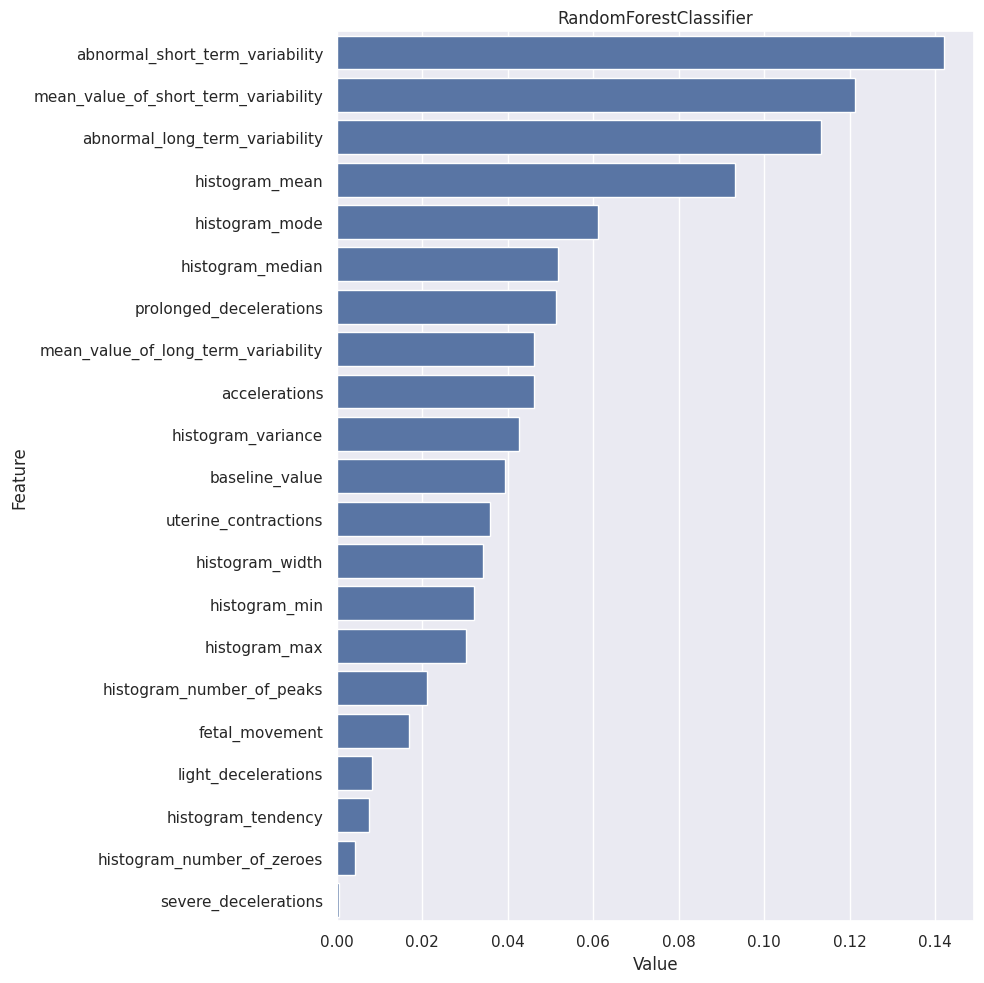

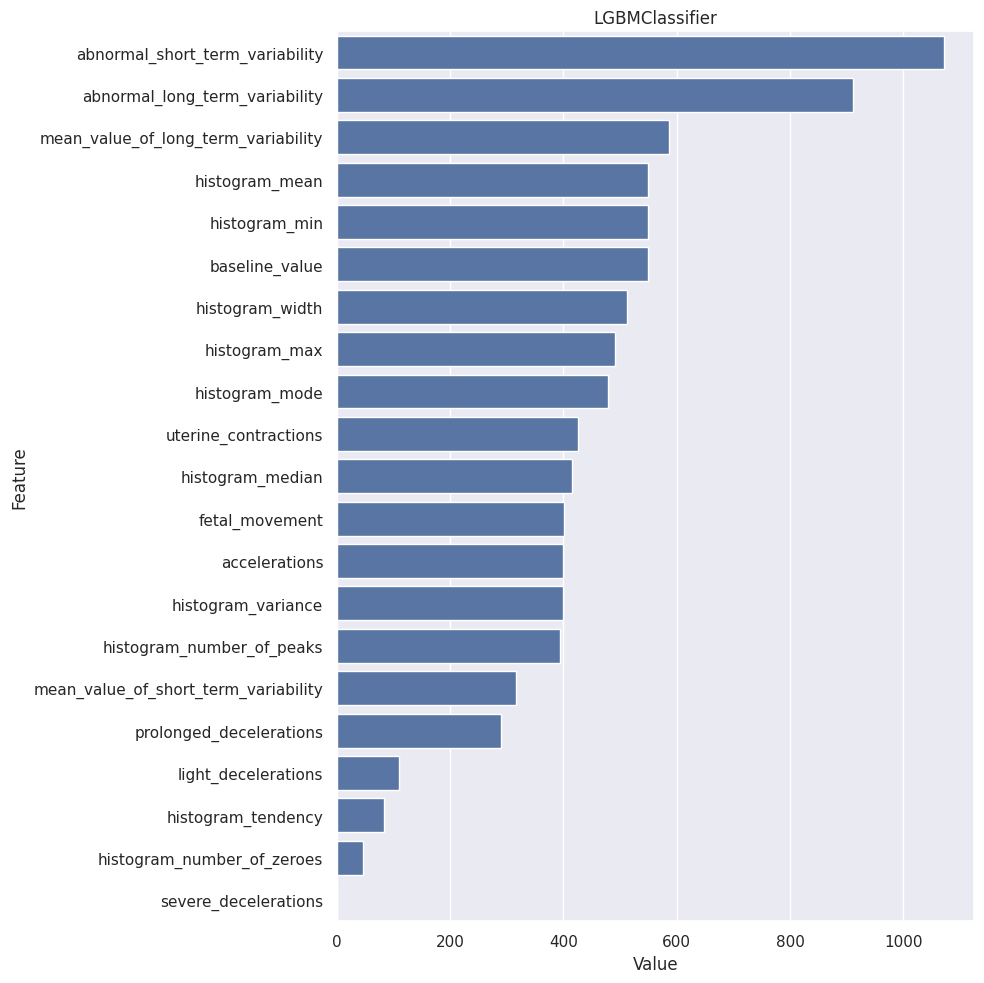

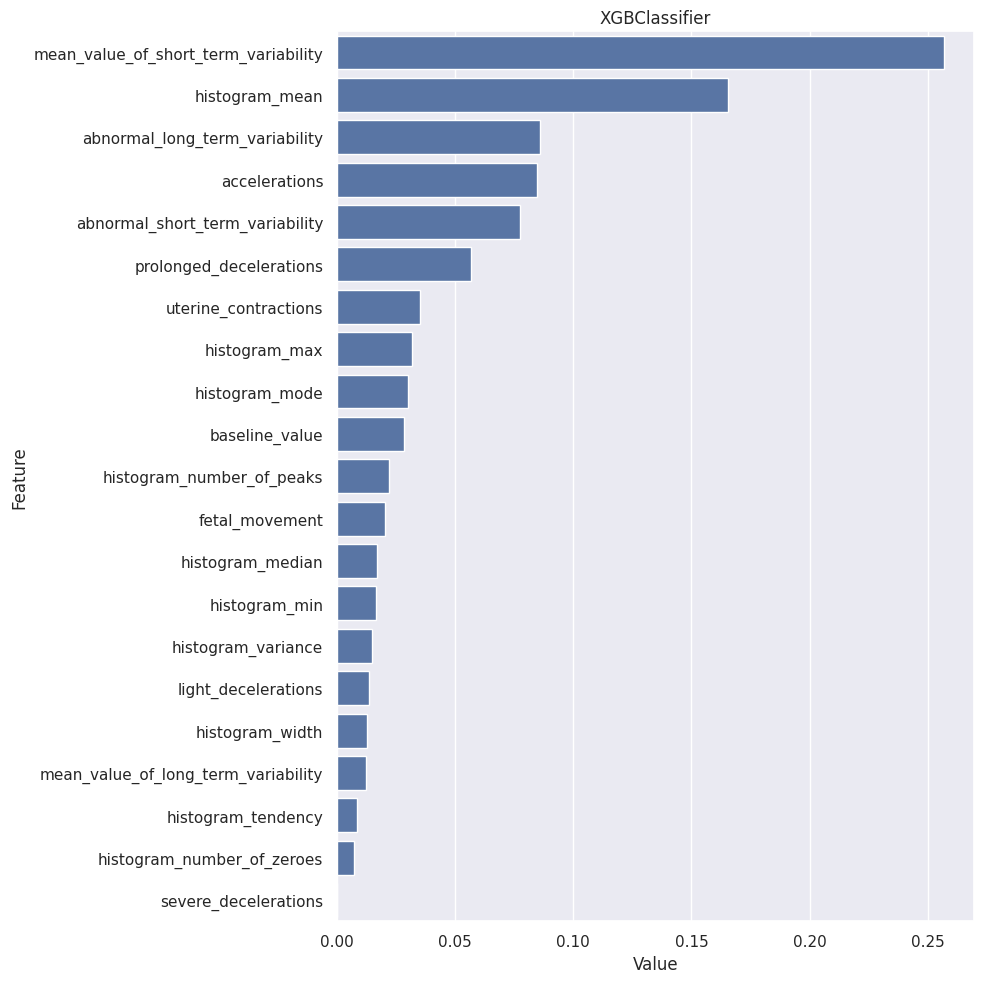

In [252]:
model_rf = RandomForestClassifier(random_state = 42).fit(X, y)
model_lgb = LGBMClassifier(verbose = -1, random_state = 42).fit(X, y)
model_xgboost = XGBClassifier(random_state = 42).fit(X, y)

df2= df.drop(["fetal_health"], axis=1)

plotimportance(model_rf, df2)
plotimportance(model_lgb, df2)
plotimportance(model_xgboost, df2)

Confusion Matrix
---

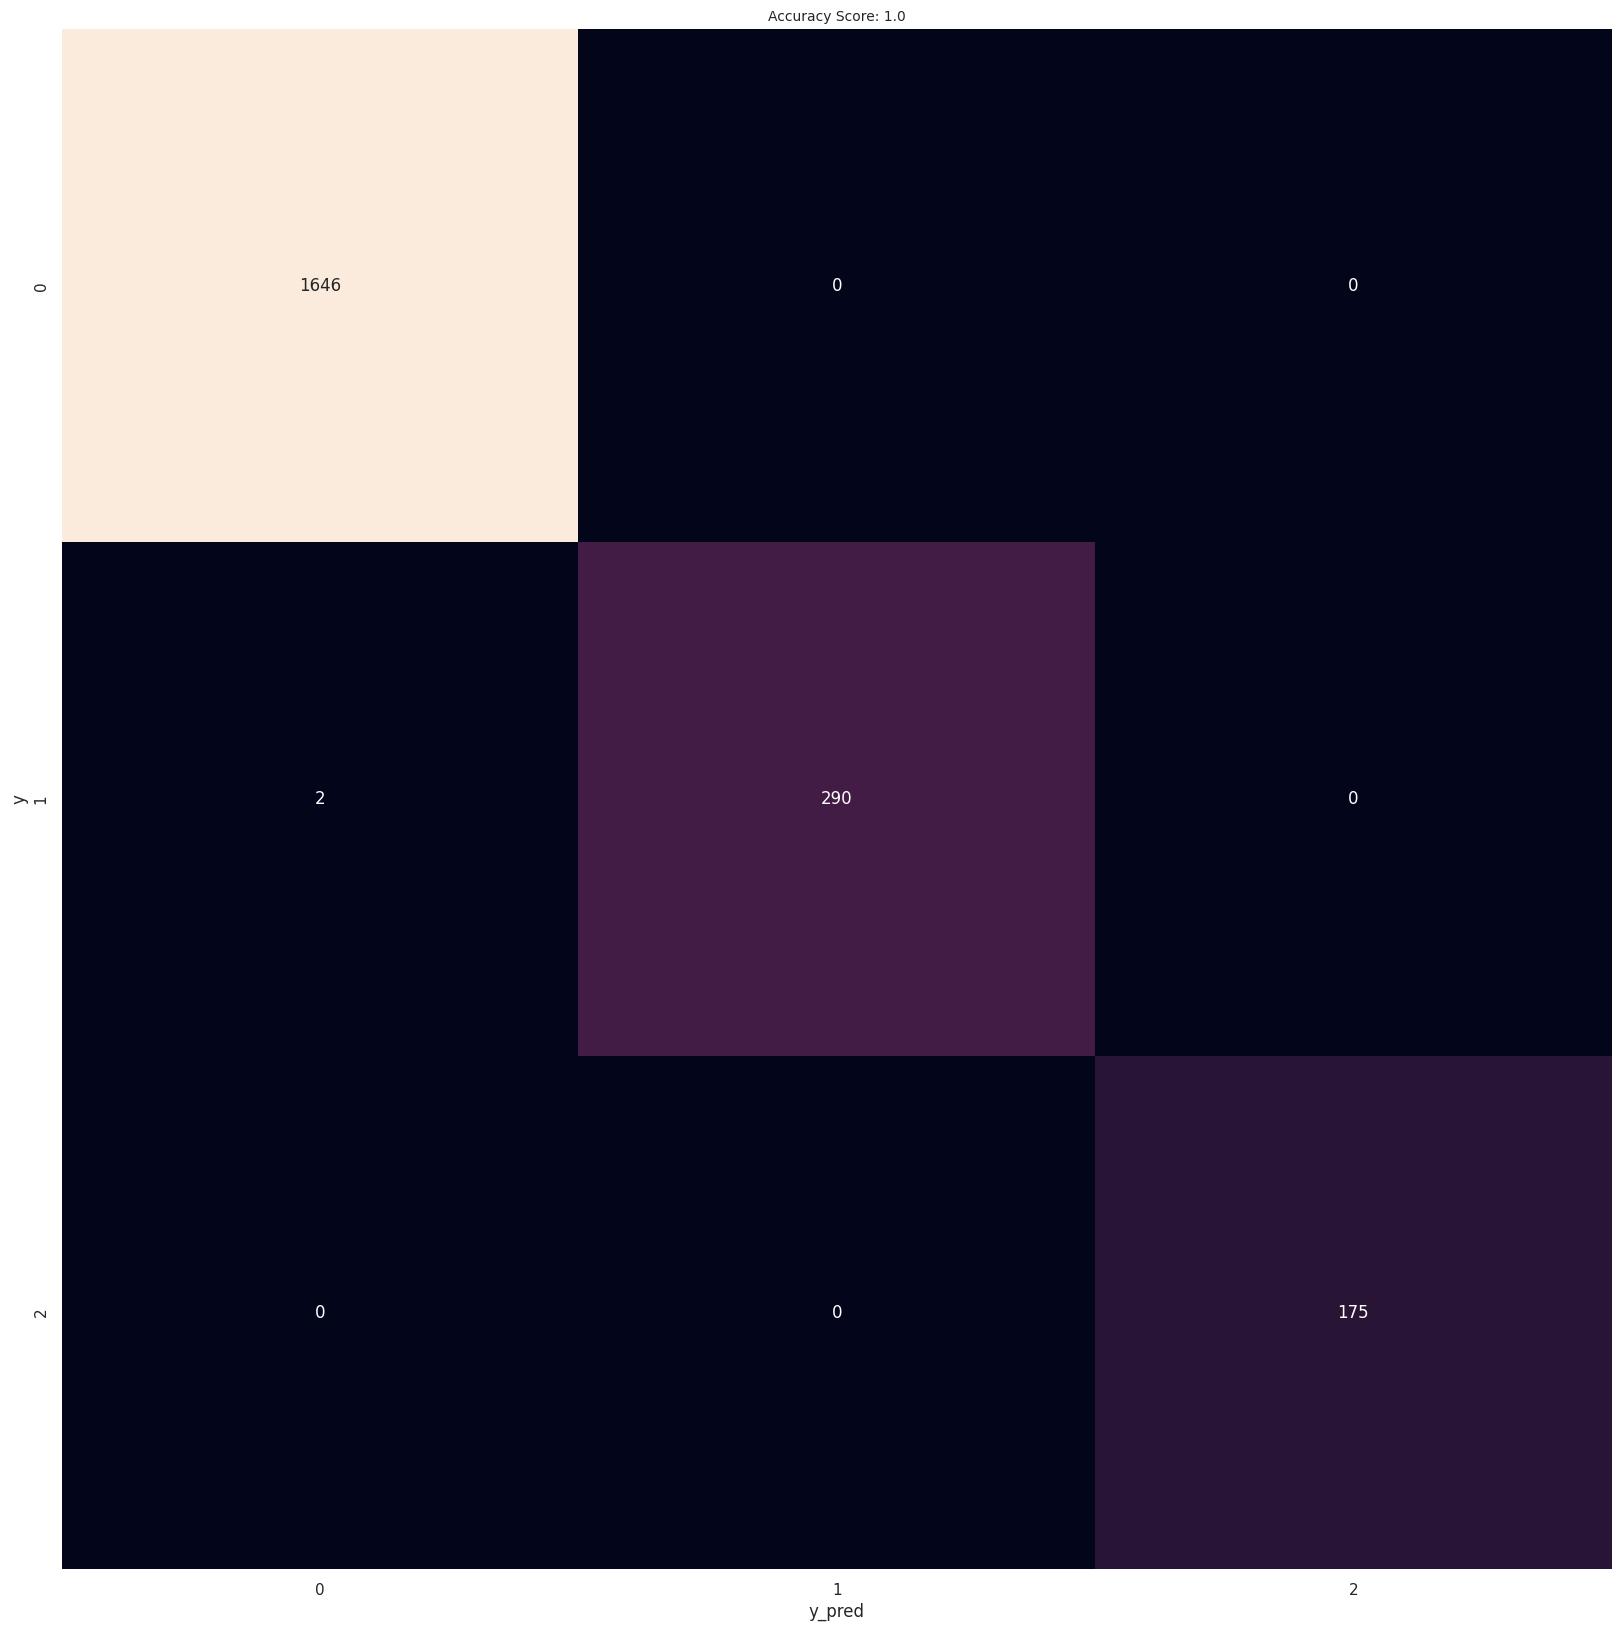

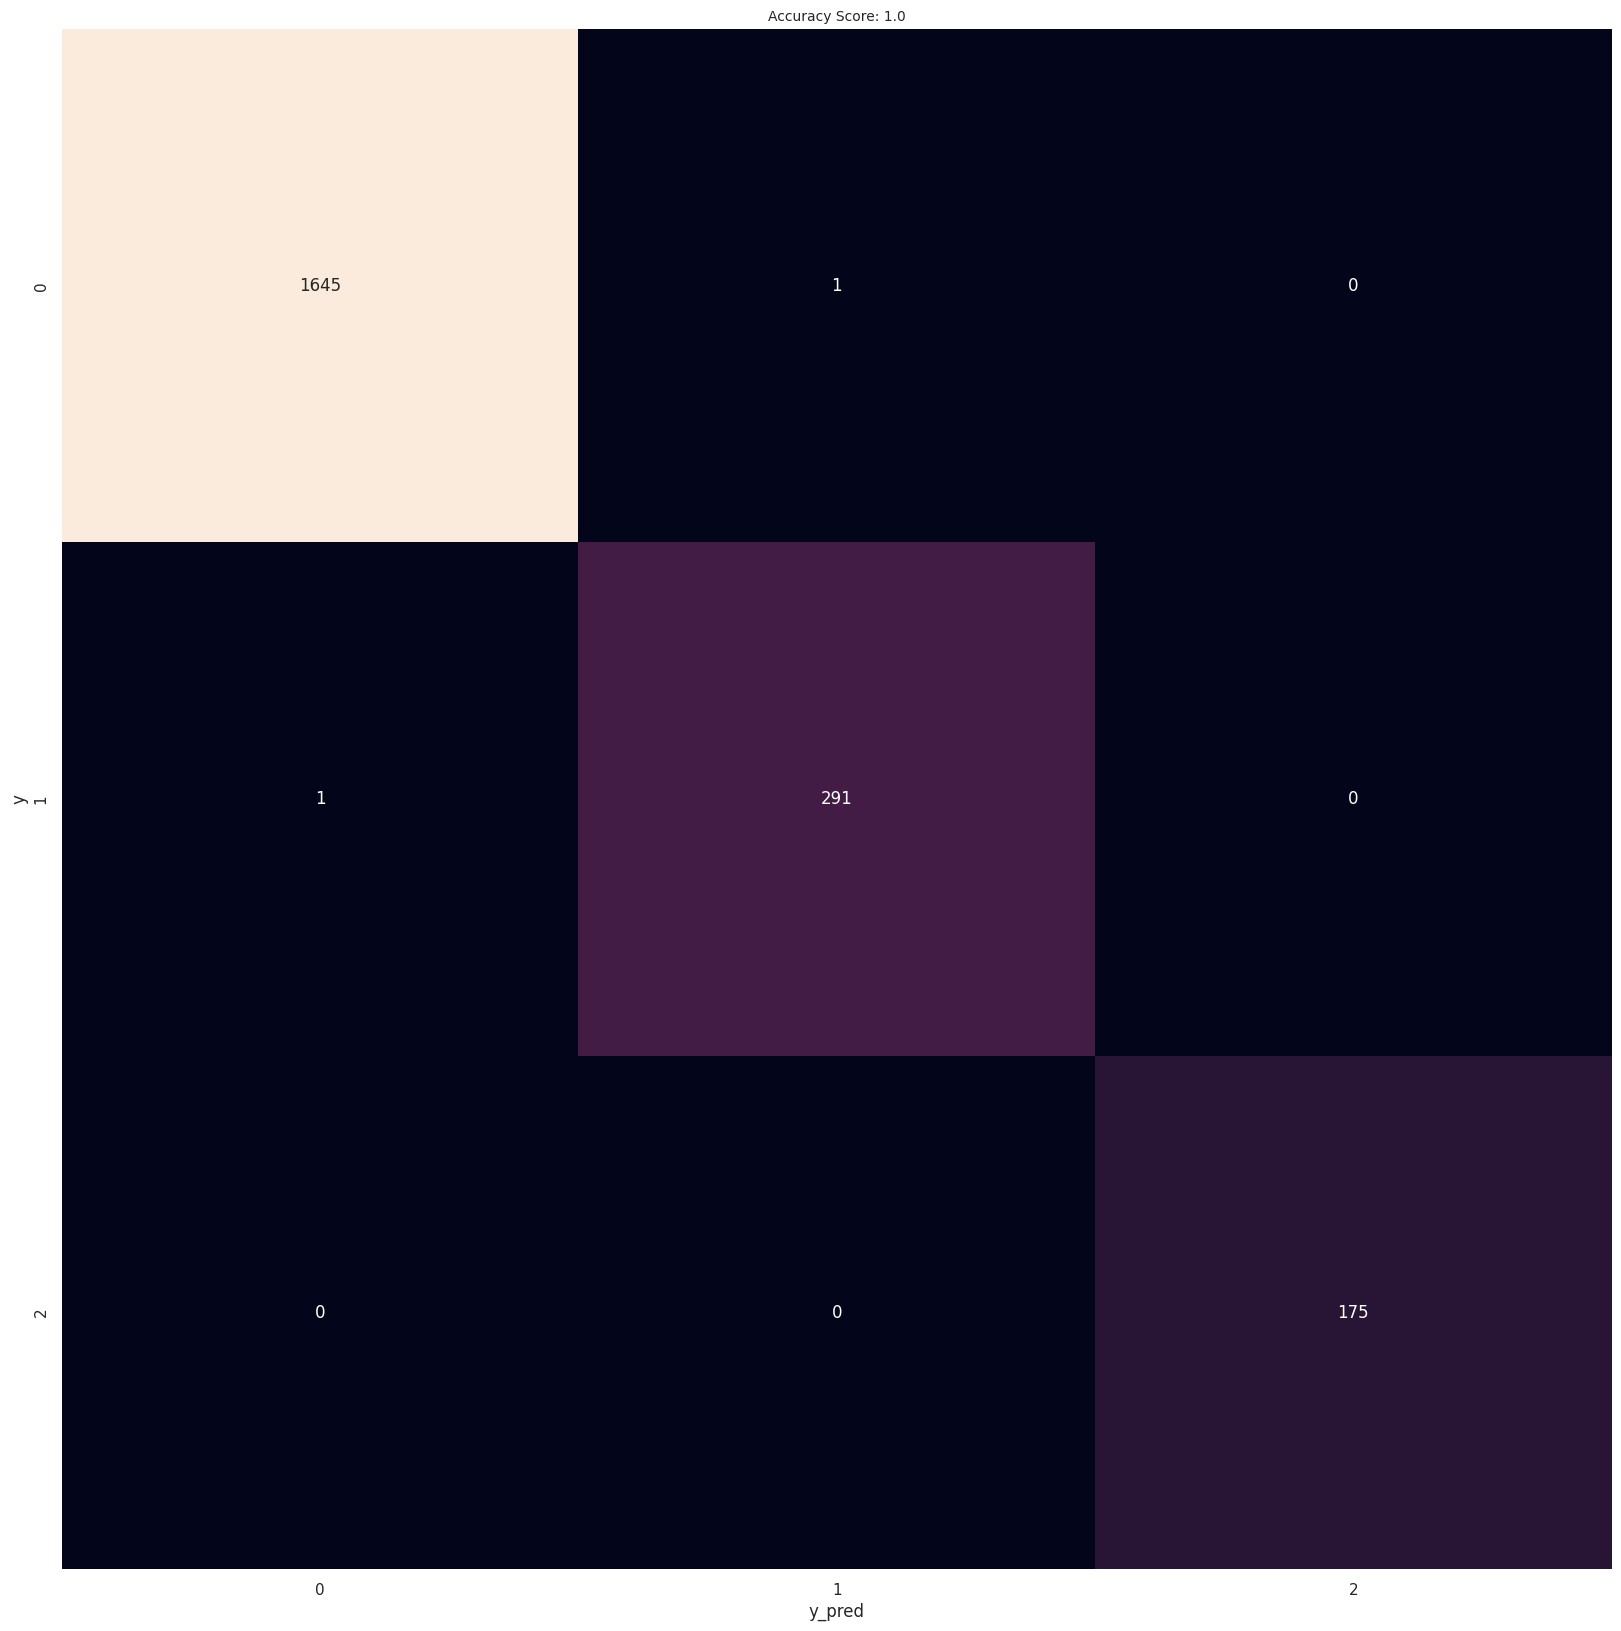

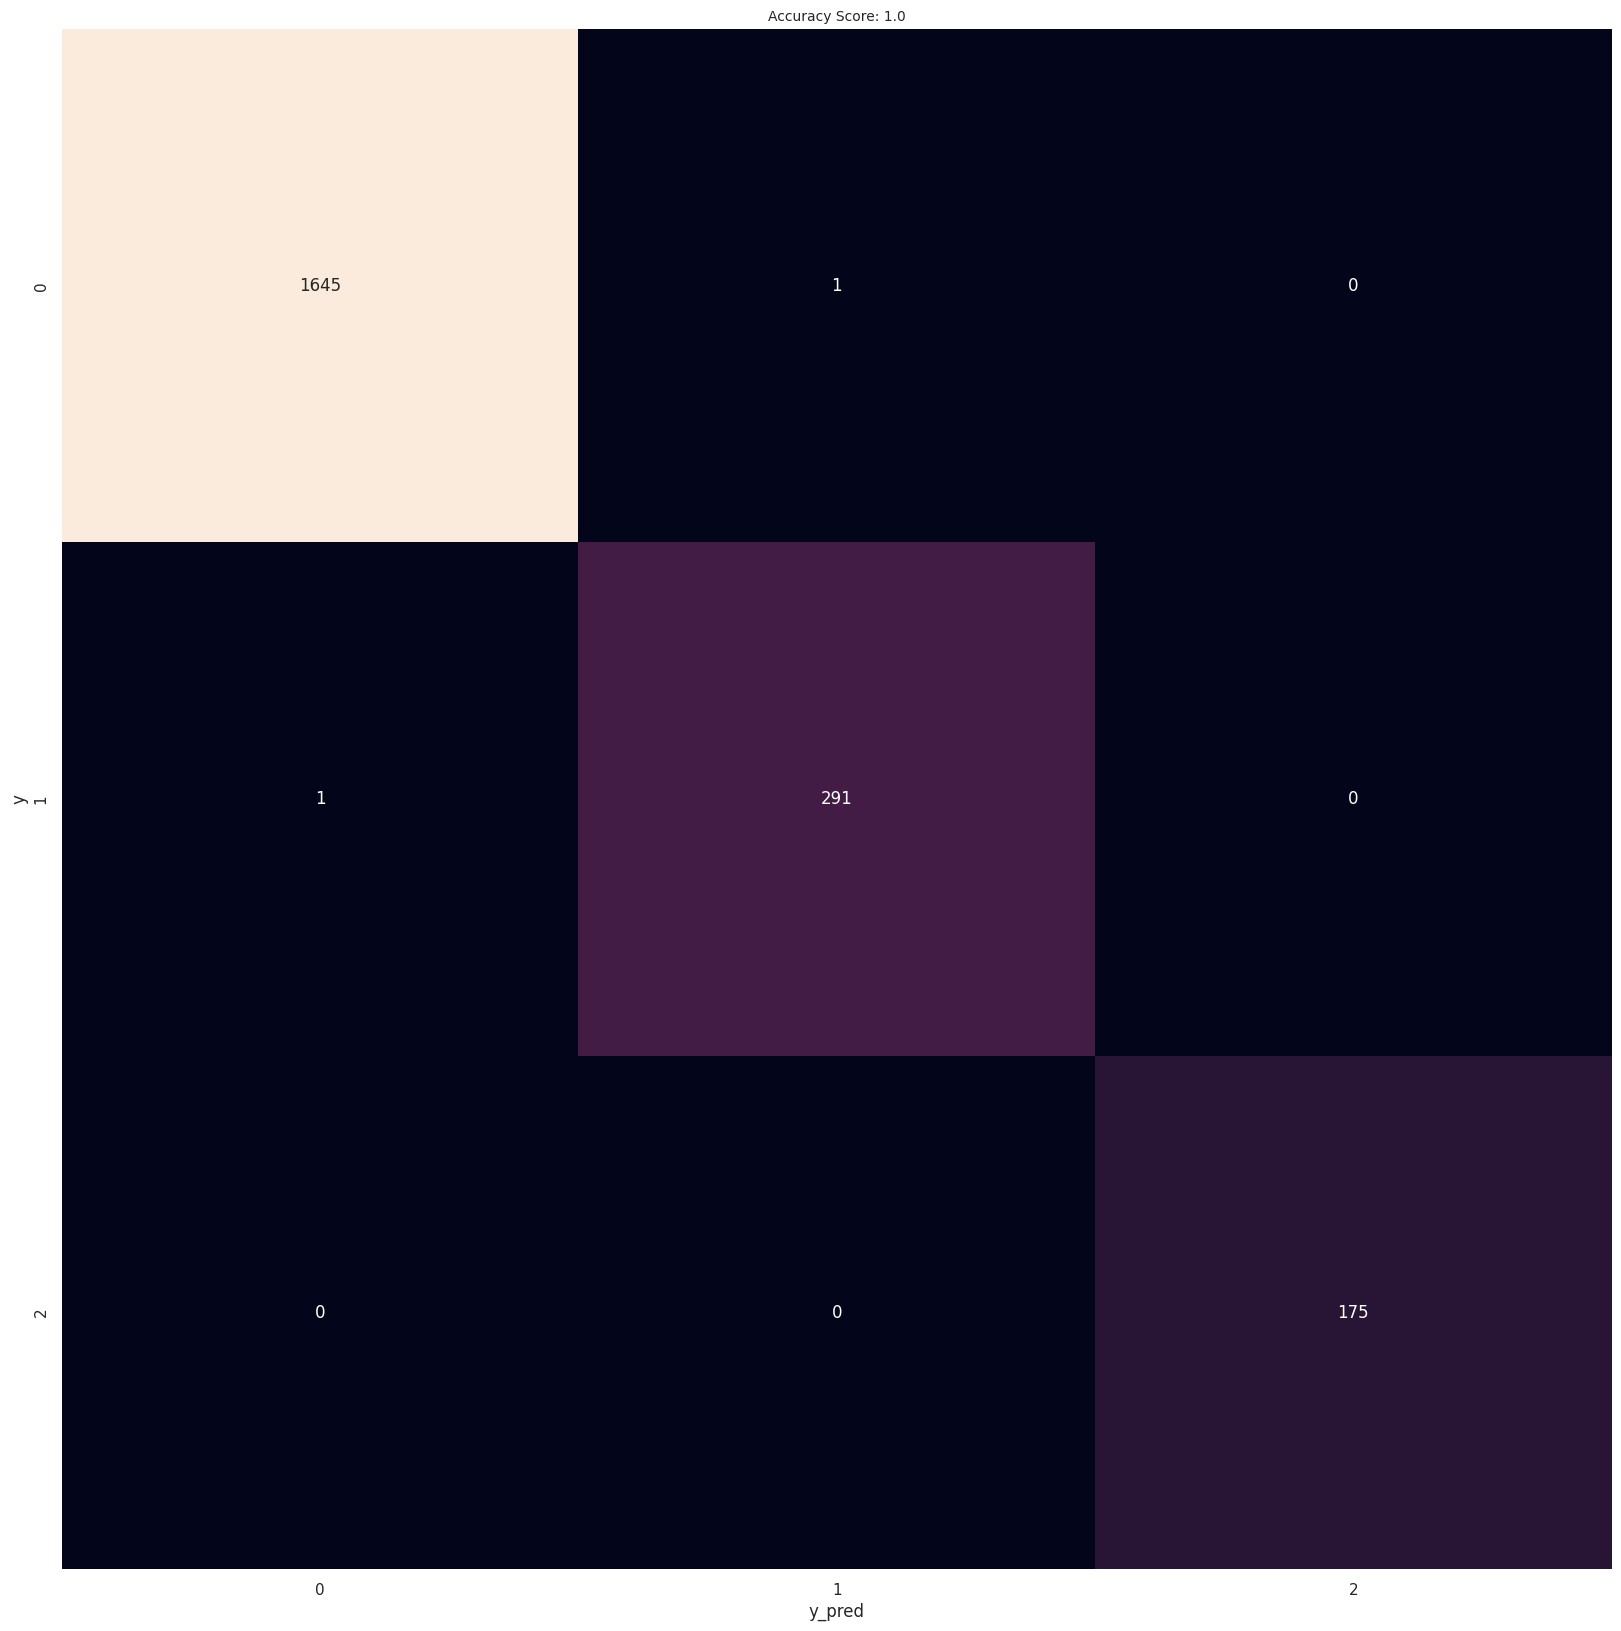

In [253]:
def plot_confusion_matrix(y, y_pred):
  acc = round(accuracy_score(y,y_pred), 2)
  cm = confusion_matrix(y, y_pred)
  sns.heatmap(cm, annot=True, fmt=".0f", cbar=False)
  plt.xlabel("y_pred")
  plt.ylabel("y")
  plt.title("Accuracy Score: {0}".format(acc), size=10)
  plt.show()

y_rf_pred = model_rf.predict(X)
plot_confusion_matrix(y, y_rf_pred)

y_lgb_pred = model_lgb.predict(X)
plot_confusion_matrix(y, y_lgb_pred)

y_xgboost_pred = model_xgboost.predict(X)
plot_confusion_matrix(y, y_xgboost_pred)


Feature Engineering
---

In [254]:
df[num_cols] = df[num_cols] + 0.000001

df['N_total_decelerations'] = df['light_decelerations'] + df['severe_decelerations'] + df['prolonged_decelerations']

# Percentage of abnormal short and long variability rate
df['N_short_term_variability_rate'] = df['abnormal_short_term_variability'] / (df['abnormal_short_term_variability'] + df['mean_value_of_short_term_variability'])
df['N_long_term_variability_rate'] = df['abnormal_long_term_variability'] / (df['abnormal_long_term_variability'] + df['mean_value_of_long_term_variability'])

# Score of abnormal and normal variability
df['N_abnormal_variability_score'] = df['abnormal_short_term_variability'] + df['abnormal_long_term_variability']
df['N_mean_variability_score'] = df['mean_value_of_short_term_variability'] + df['mean_value_of_long_term_variability']

# Total Variability: Kısa vadeli ve uzun vadeli değişkenliğin toplamı.
df['N_total_variability'] = df['N_abnormal_variability_score'] + df['N_mean_variability_score']

# Acceleration Ratio: Accelerations sayısının toplam fetal hareket sayısına oranı.
df['N_acceleration_ratio'] = df['accelerations'] / (df['fetal_movement'] + df['accelerations'] + df['uterine_contractions'])

# Deceleration Ratio: Decelerations sayısının toplam fetal hareket sayısına oranı.
df['N_deceleration_ratio'] = df['N_total_decelerations'] / (df['fetal_movement'] + df['accelerations'] + df['uterine_contractions'])

# Fetal activity ratio
df["N_fetal_activity_ratio"] = df["fetal_movement"] / (df["fetal_movement"] + df["uterine_contractions"])

# Histogtam symmetry
df["histogram_symmetry"] = np.abs(df["histogram_mean"] - df["histogram_median"])

df.shape

(2113, 32)

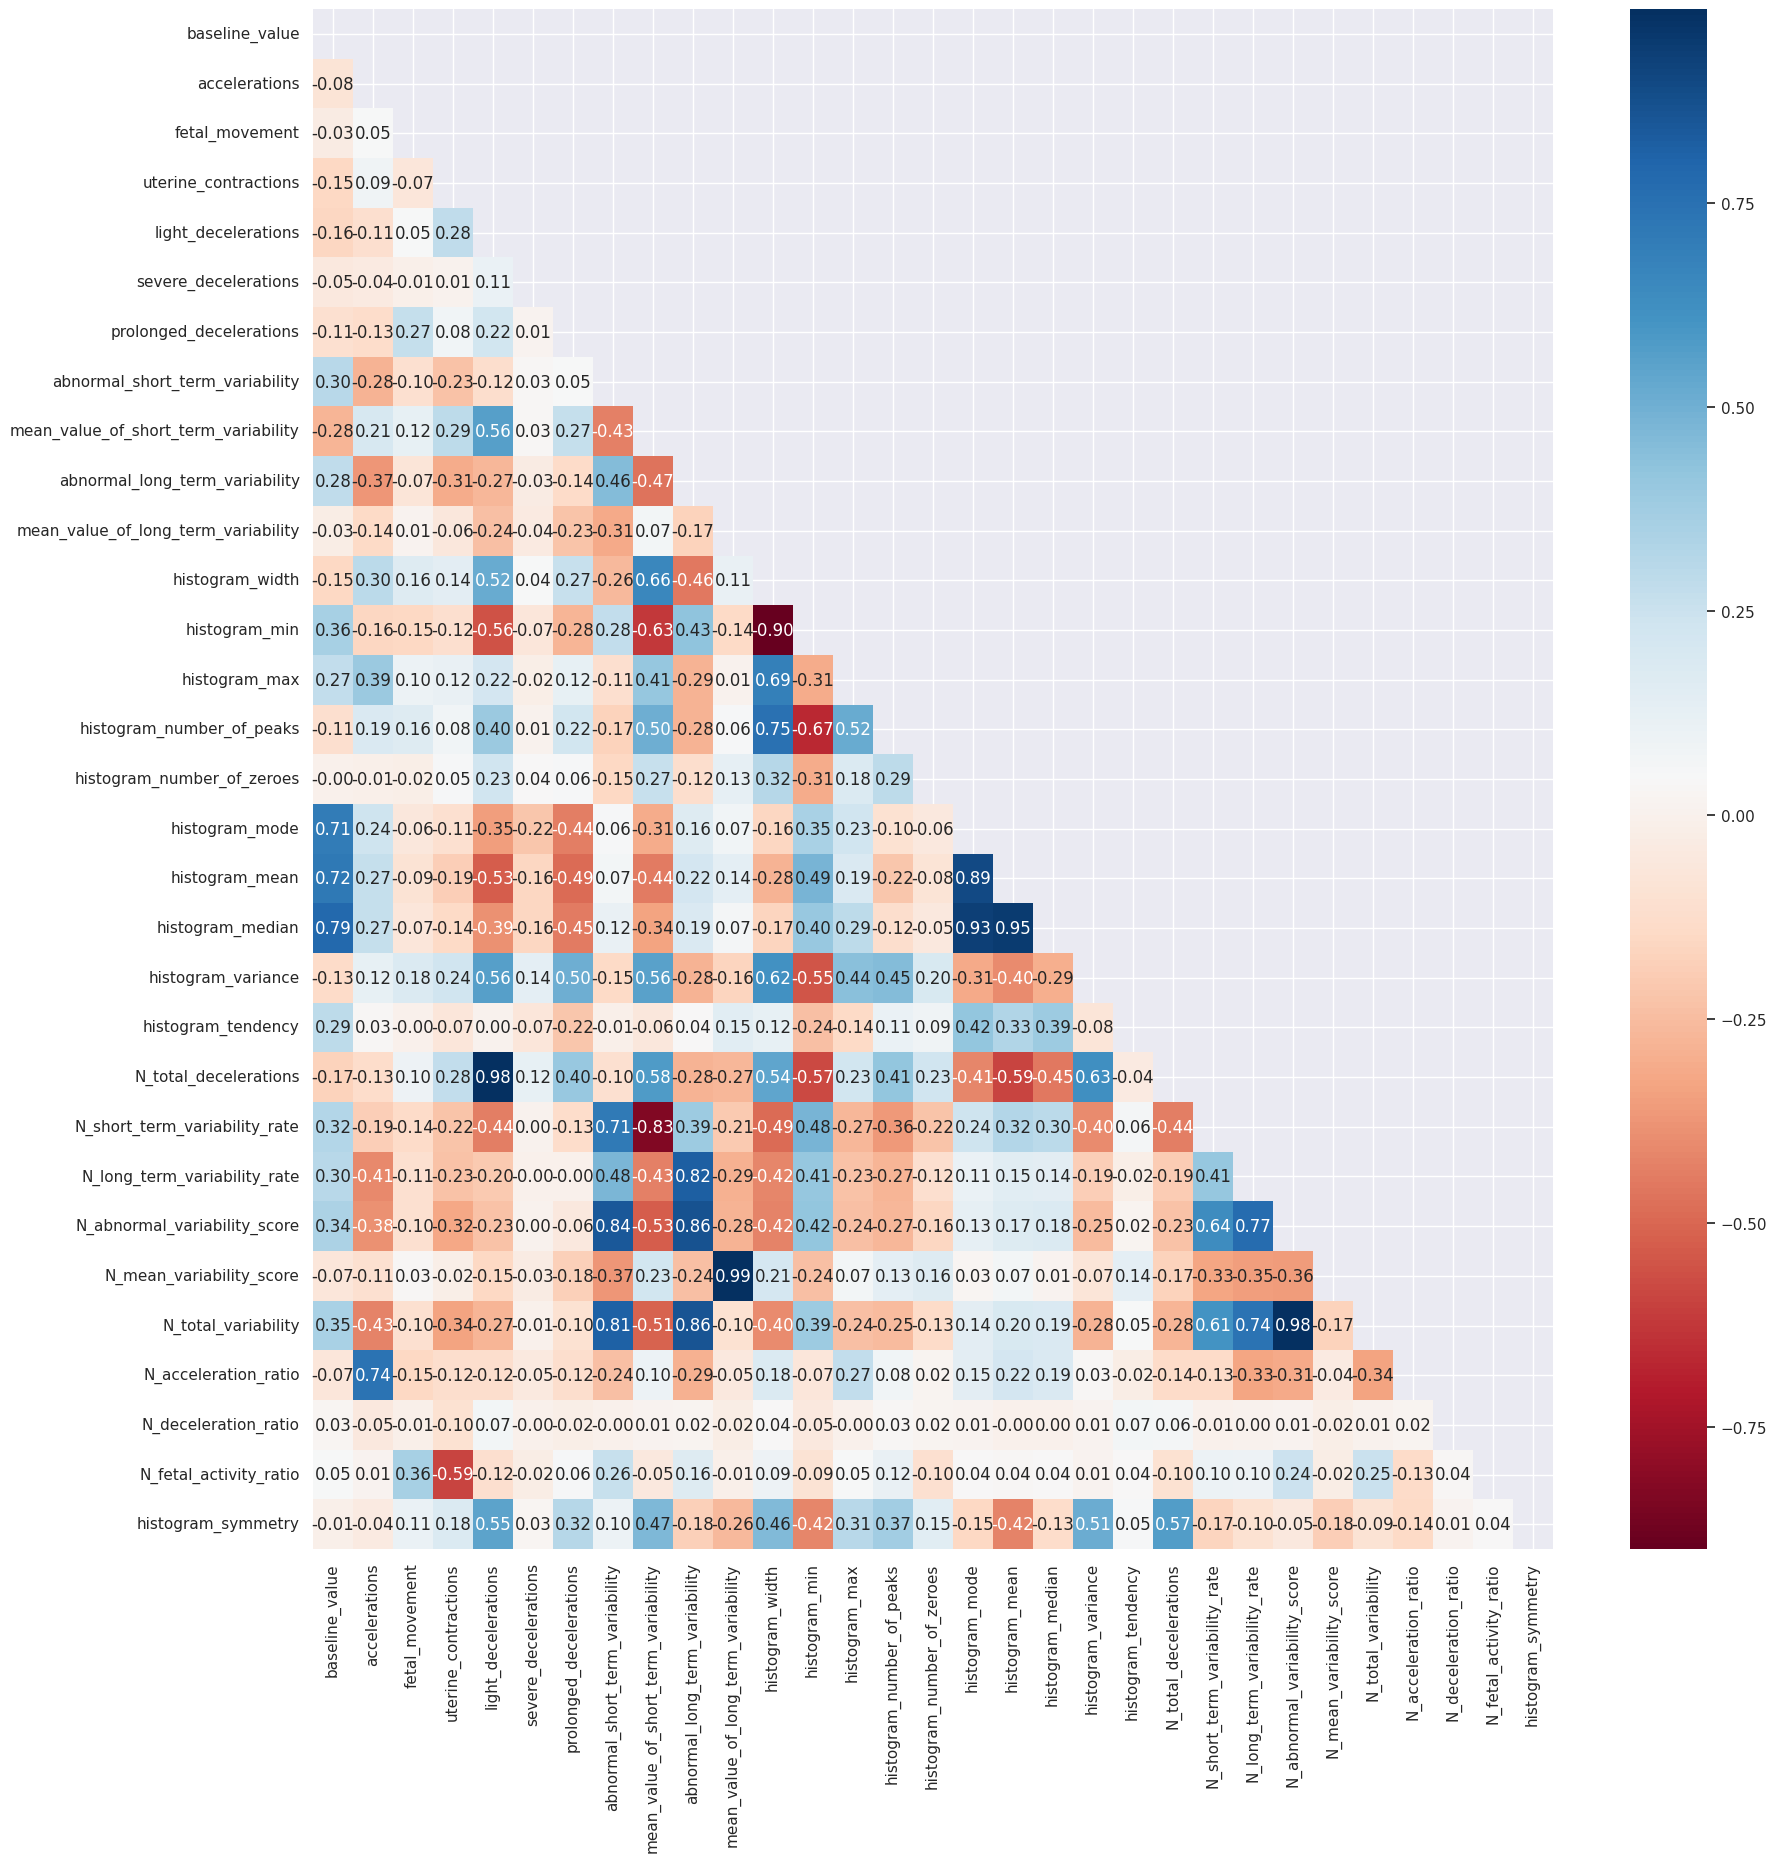

['histogram_median',
 'N_total_decelerations',
 'N_mean_variability_score',
 'N_total_variability']

In [255]:
num_cols = [col for col in df.columns if col not in [target_col]]
high_correlated_cols(df, num_cols, 0.9, True)

In [256]:
#df = pd.DataFrame(df)
#droped_col = ['histogram_min', 'histogram_mean', 'histogram_median', 'N_abnormal_variability_score', 'N_mean_variability_score', 'N_total_decelerations', 'N_total_variability']
#df.drop(droped_col, axis=1, inplace=True)

print(df.shape)

(2113, 32)


# 5. Final Modelling

In [257]:
def hyperparameter_optimization(X, y, scoring, cv=5):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cvresults = cross_validate(final_model, X, y, cv=cv, scoring=scoring, error_score="raise")
        print(f"f1_score: {round(cvresults['test_f1_score'].mean(), 4)}")
        print(f"auc_score: {round(cvresults['test_auc_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models


def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    voting_clf = VotingClassifier(estimators=[('LightGBM', best_models["LightGBM"]), ('XGBoost', best_models["XGBoost"]), ('RF', best_models["RF"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=5, scoring=scoring, error_score='raise')
    print(f"f1_score: {round(cv_results['test_f1_score'].mean(), 4)}")
    print(f"auc_score: {round(cv_results['test_auc_score'].mean(), 4)}")

    return voting_clf

def lr_curve(X, y, estimator, cv=5, scoring="accuracy"):

    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y,
                                                            train_sizes=np.linspace(0.1, 1.0, 10), cv=cv, scoring=scoring)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Train')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Test')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.grid()
    plt.ylabel(scoring)
    plt.legend(loc='lower right')
    plt.ylim([0.5, 1.0])
    plt.show()

Hiperparametre Optimization
---

In [258]:
target_col = ["fetal_health"]
num_cols = [col for col in df.columns if col not in [target_col]]

X = df.drop("fetal_health", axis=1)

y = df["fetal_health"]


scaler = StandardScaler()
X = scaler.fit_transform(X)


In [259]:
rfparams = {"max_depth": [20, 30],
             "max_features": [5, "log2"],
             "min_samples_split": [5, 20],
             "n_estimators": [200, 300, 500]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [6, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

lrparams =  {'penalty': ['l1', 'l2'],  # Regularization penalty
              'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
               'solver': ['liblinear', 'saga']  # Optimization algorithm
}

classifiers = [("RF", RandomForestClassifier(random_state=42), rfparams),
                ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgboost_params),
                ("LightGBM", LGBMClassifier(verbose= -1, random_state=42), lightgbm_params),
               ("LR", LogisticRegression(random_state=42), lrparams)
]

scoring = {'f1_score': make_scorer(f1_score, average='weighted'),
           'auc_score': make_scorer(lambda y_in, y_p_in: roc_auc_score(y_in, y_p_in, multi_class='ovr'), needs_proba=True)

          }

best_models = hyperparameter_optimization(X, y, scoring= scoring)

Hyperparameter Optimization....
########## RF ##########
f1_score: 0.8751
auc_score: 0.9519
RF best params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 20, 'n_estimators': 300}

########## XGBoost ##########
f1_score: 0.8793
auc_score: 0.9453
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

########## LightGBM ##########
f1_score: 0.8674
auc_score: 0.9488
LightGBM best params: {'learning_rate': 0.1, 'n_estimators': 500}

########## LR ##########
f1_score: 0.8552
auc_score: 0.9396
LR best params: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}



Feature Importance
---

In [260]:
def plot_confusion_matrix(y, y_pred):
  acc = round(accuracy_score(y,y_pred), 2)
  cm = confusion_matrix(y, y_pred)
  sns.heatmap(cm, annot=True, fmt=".0f", cbar=False)
  plt.xlabel("y_pred")
  plt.ylabel("y")
  plt.title("Accuracy Score: {0}".format(acc), size=10)
  plt.show()

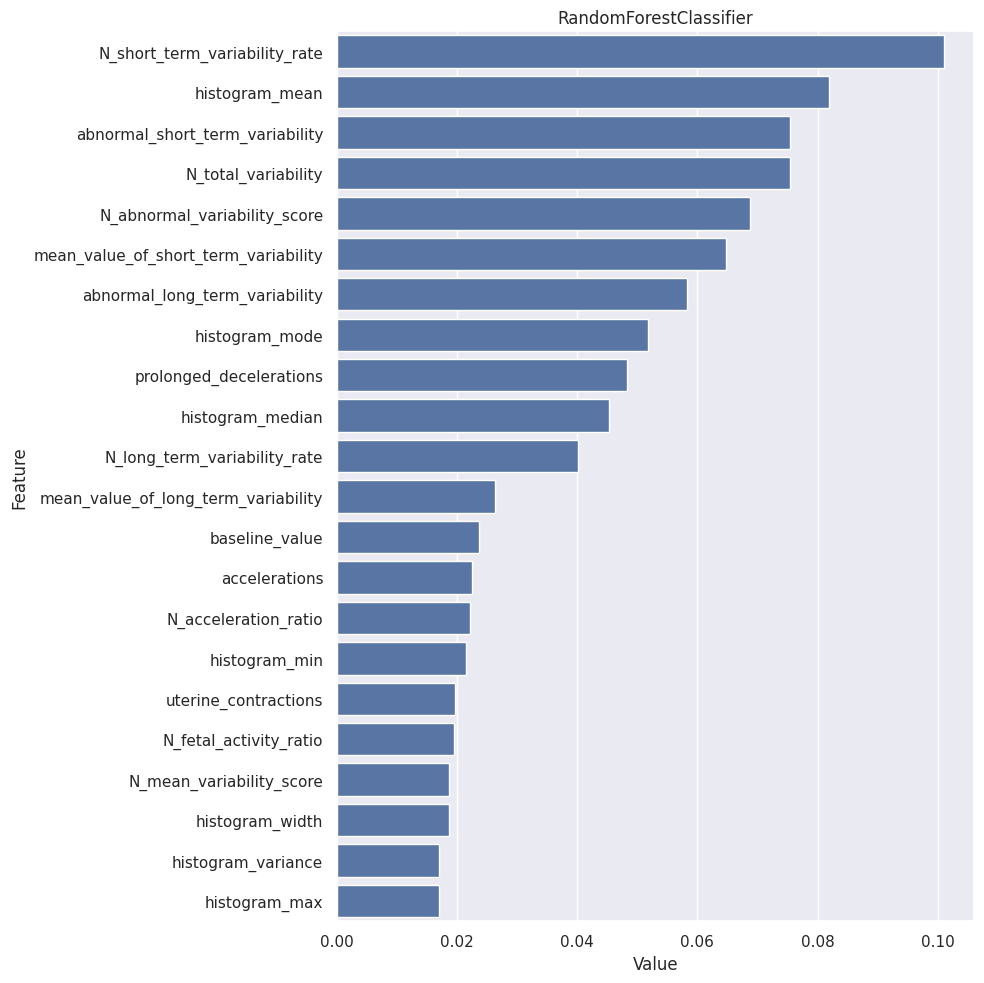

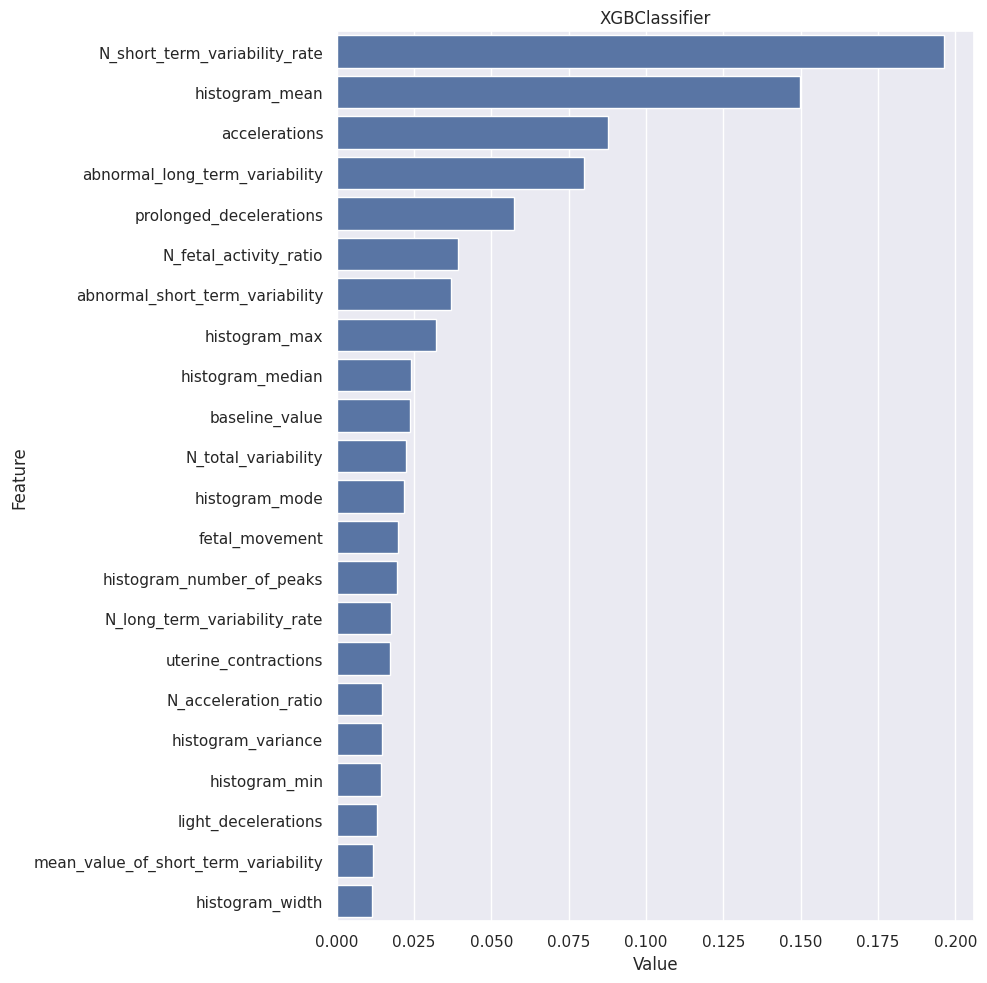

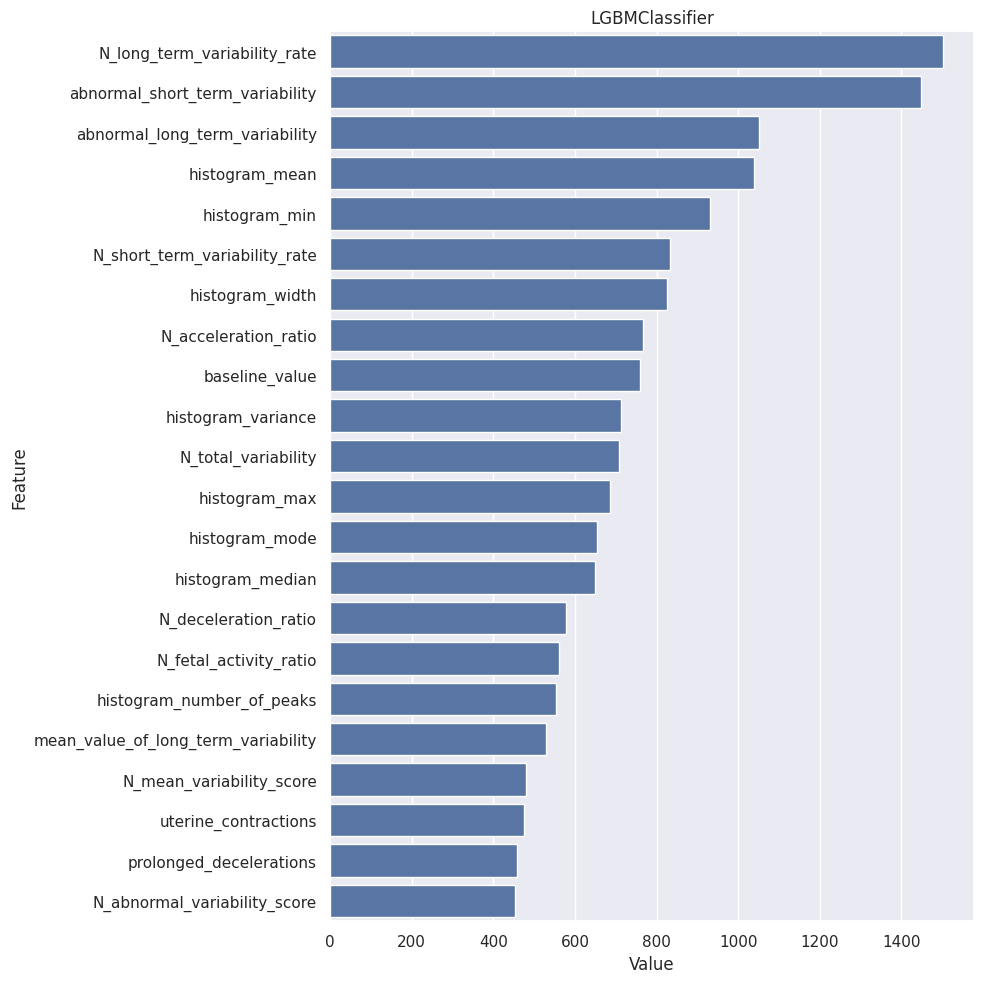

In [261]:
final_model_rf = RandomForestClassifier(max_depth = 20, max_features= 5, min_samples_split = 5, n_estimators = 300, random_state=42).fit(X, y)
final_model_xgboost = XGBClassifier(learning_rate = 0.1, max_depth = 6, n_estimators = 200, random_state=42).fit(X, y)
final_model_lgbm = LGBMClassifier(learning_rate= 0.1, n_estimators = 500, verbose = -1, random_state=42).fit(X, y)
final_model_lr = LogisticRegression(C = 10, penalty = 'l2', solver = 'saga', random_state=42).fit(X, y)


plotimportance(final_model_rf, df.drop("fetal_health", axis=1))
plotimportance(final_model_xgboost, df.drop("fetal_health", axis=1))
plotimportance(final_model_lgbm, df.drop("fetal_health", axis=1))

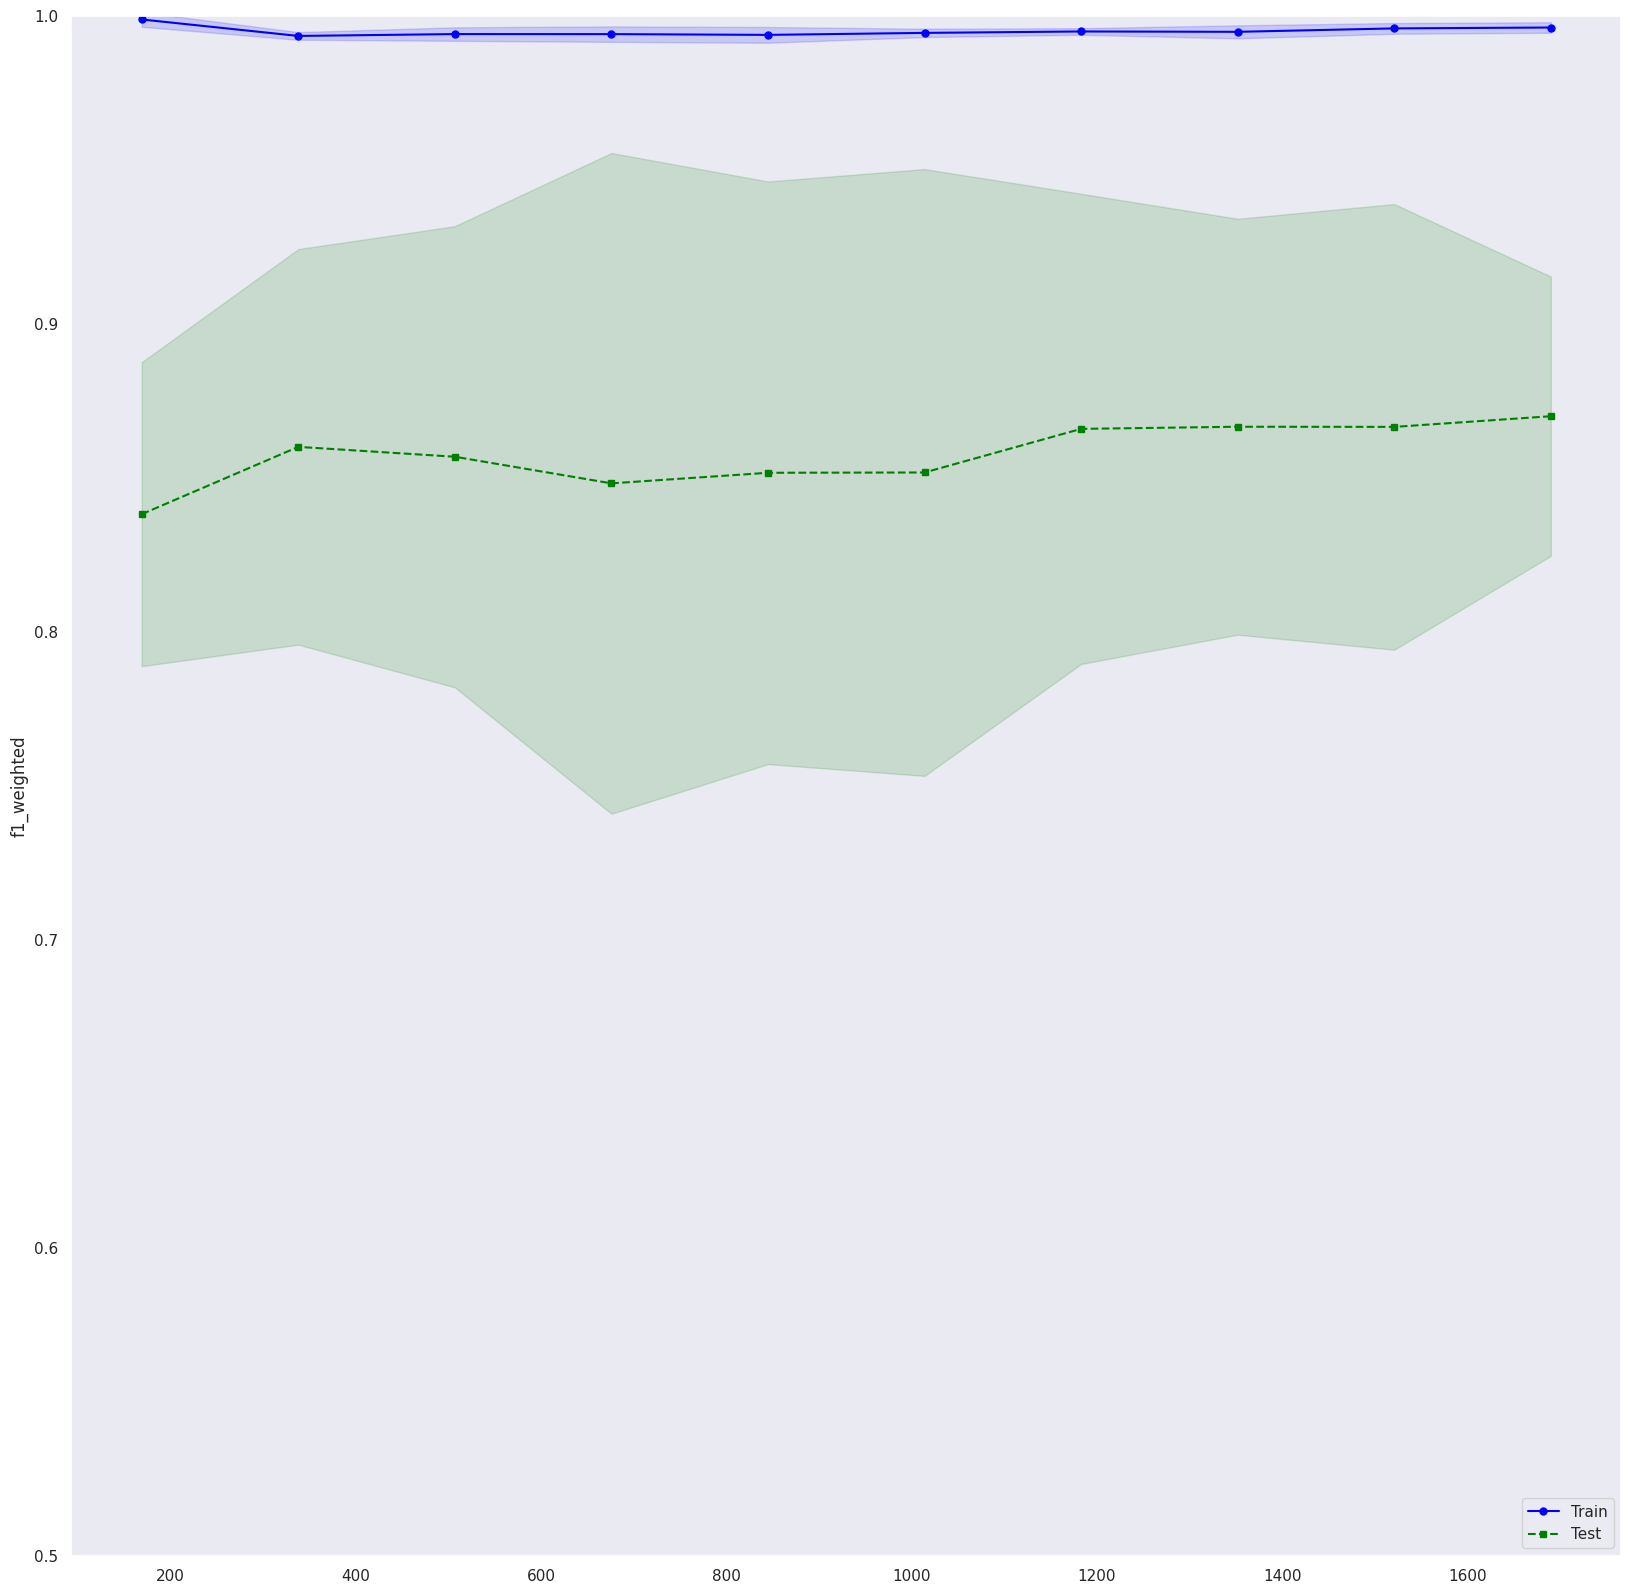

In [262]:
lr_curve(X, y, final_model_rf, cv=5, scoring="f1_weighted")

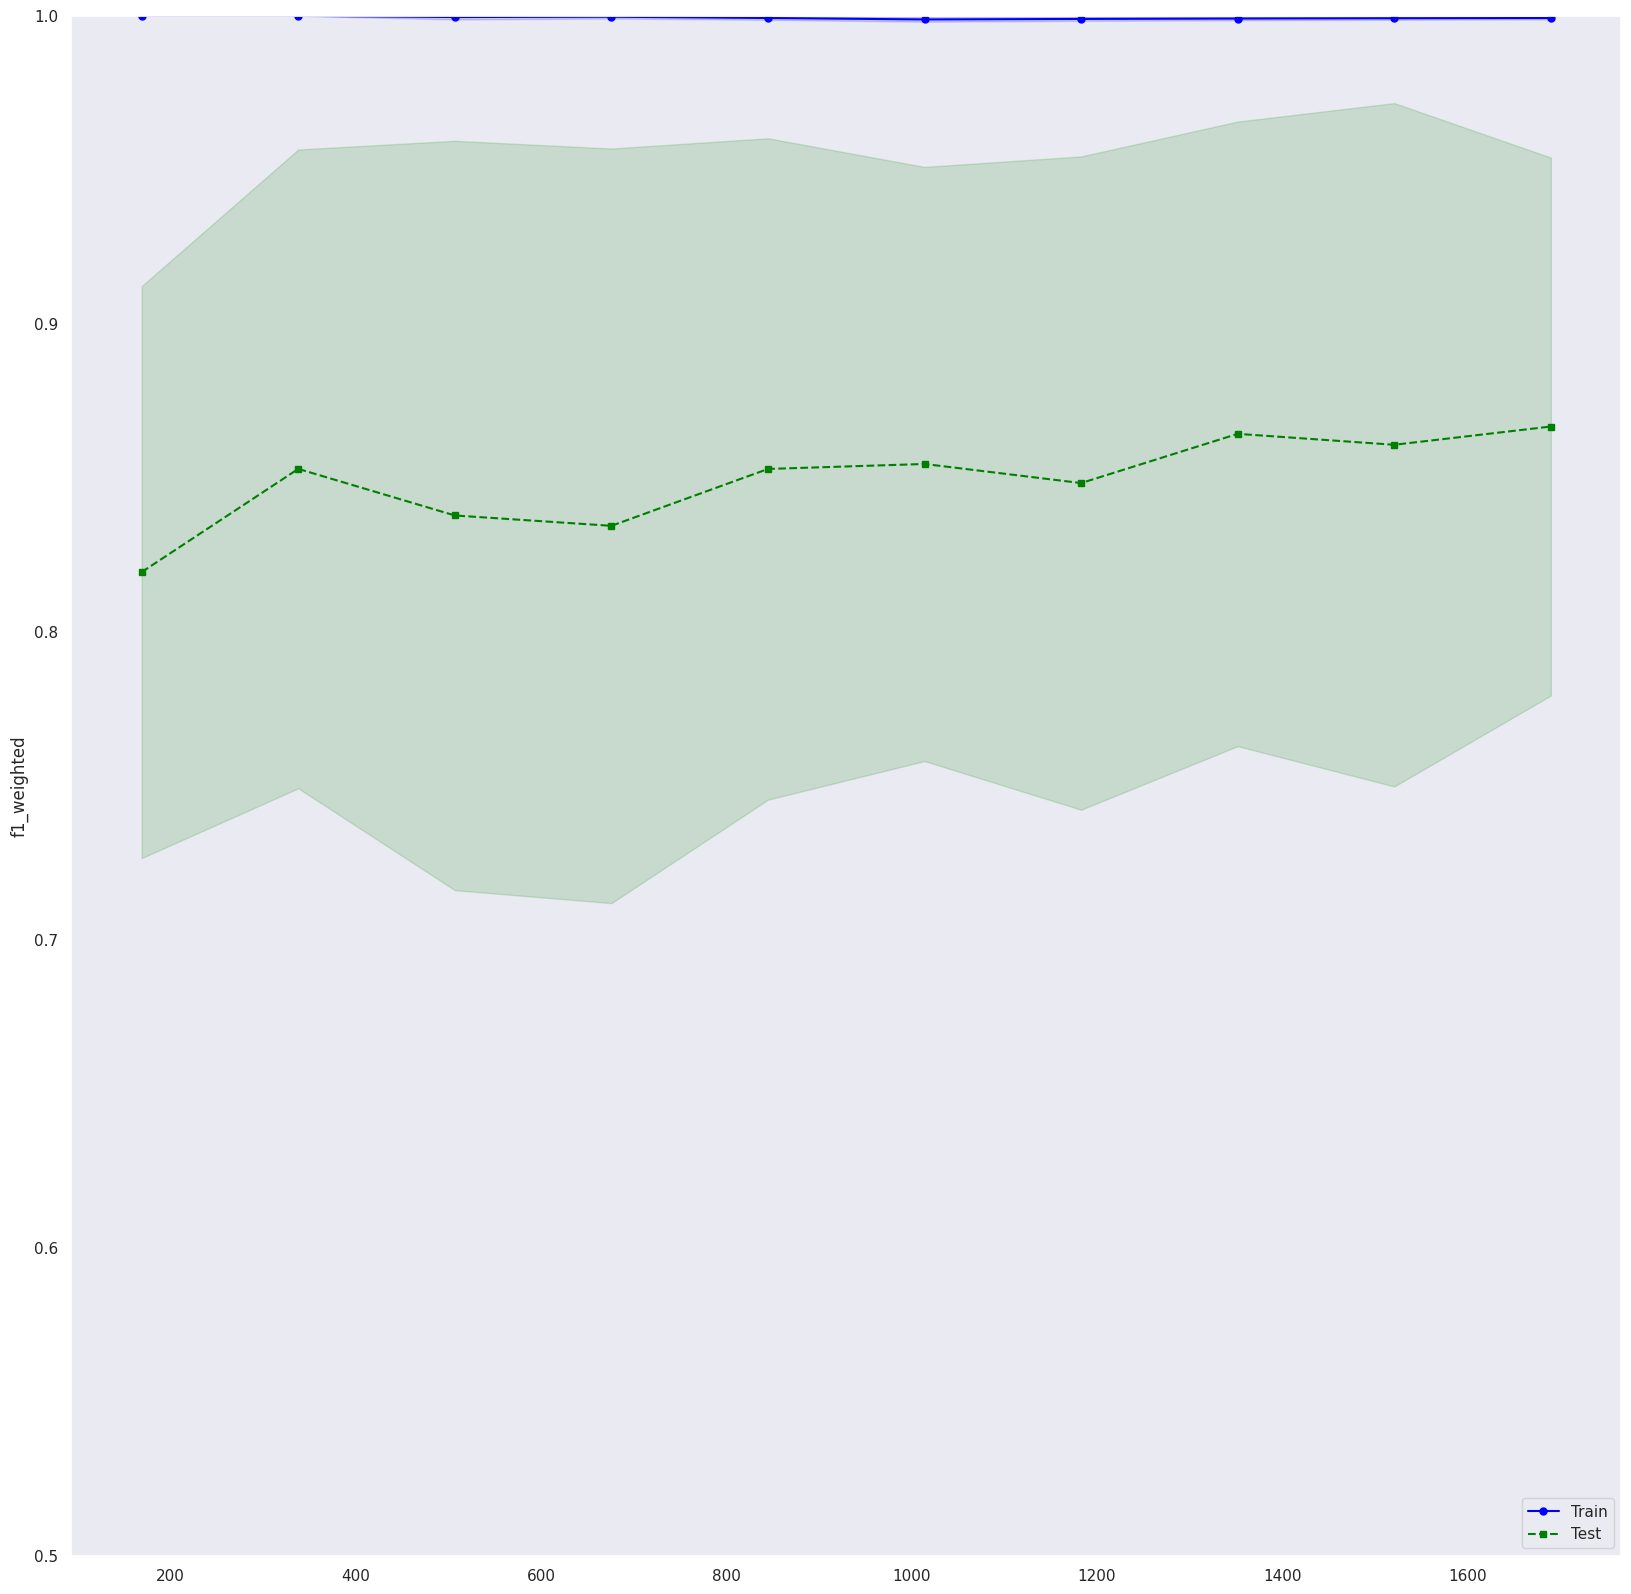

In [263]:
lr_curve(X, y, final_model_xgboost, cv=5, scoring="f1_weighted")

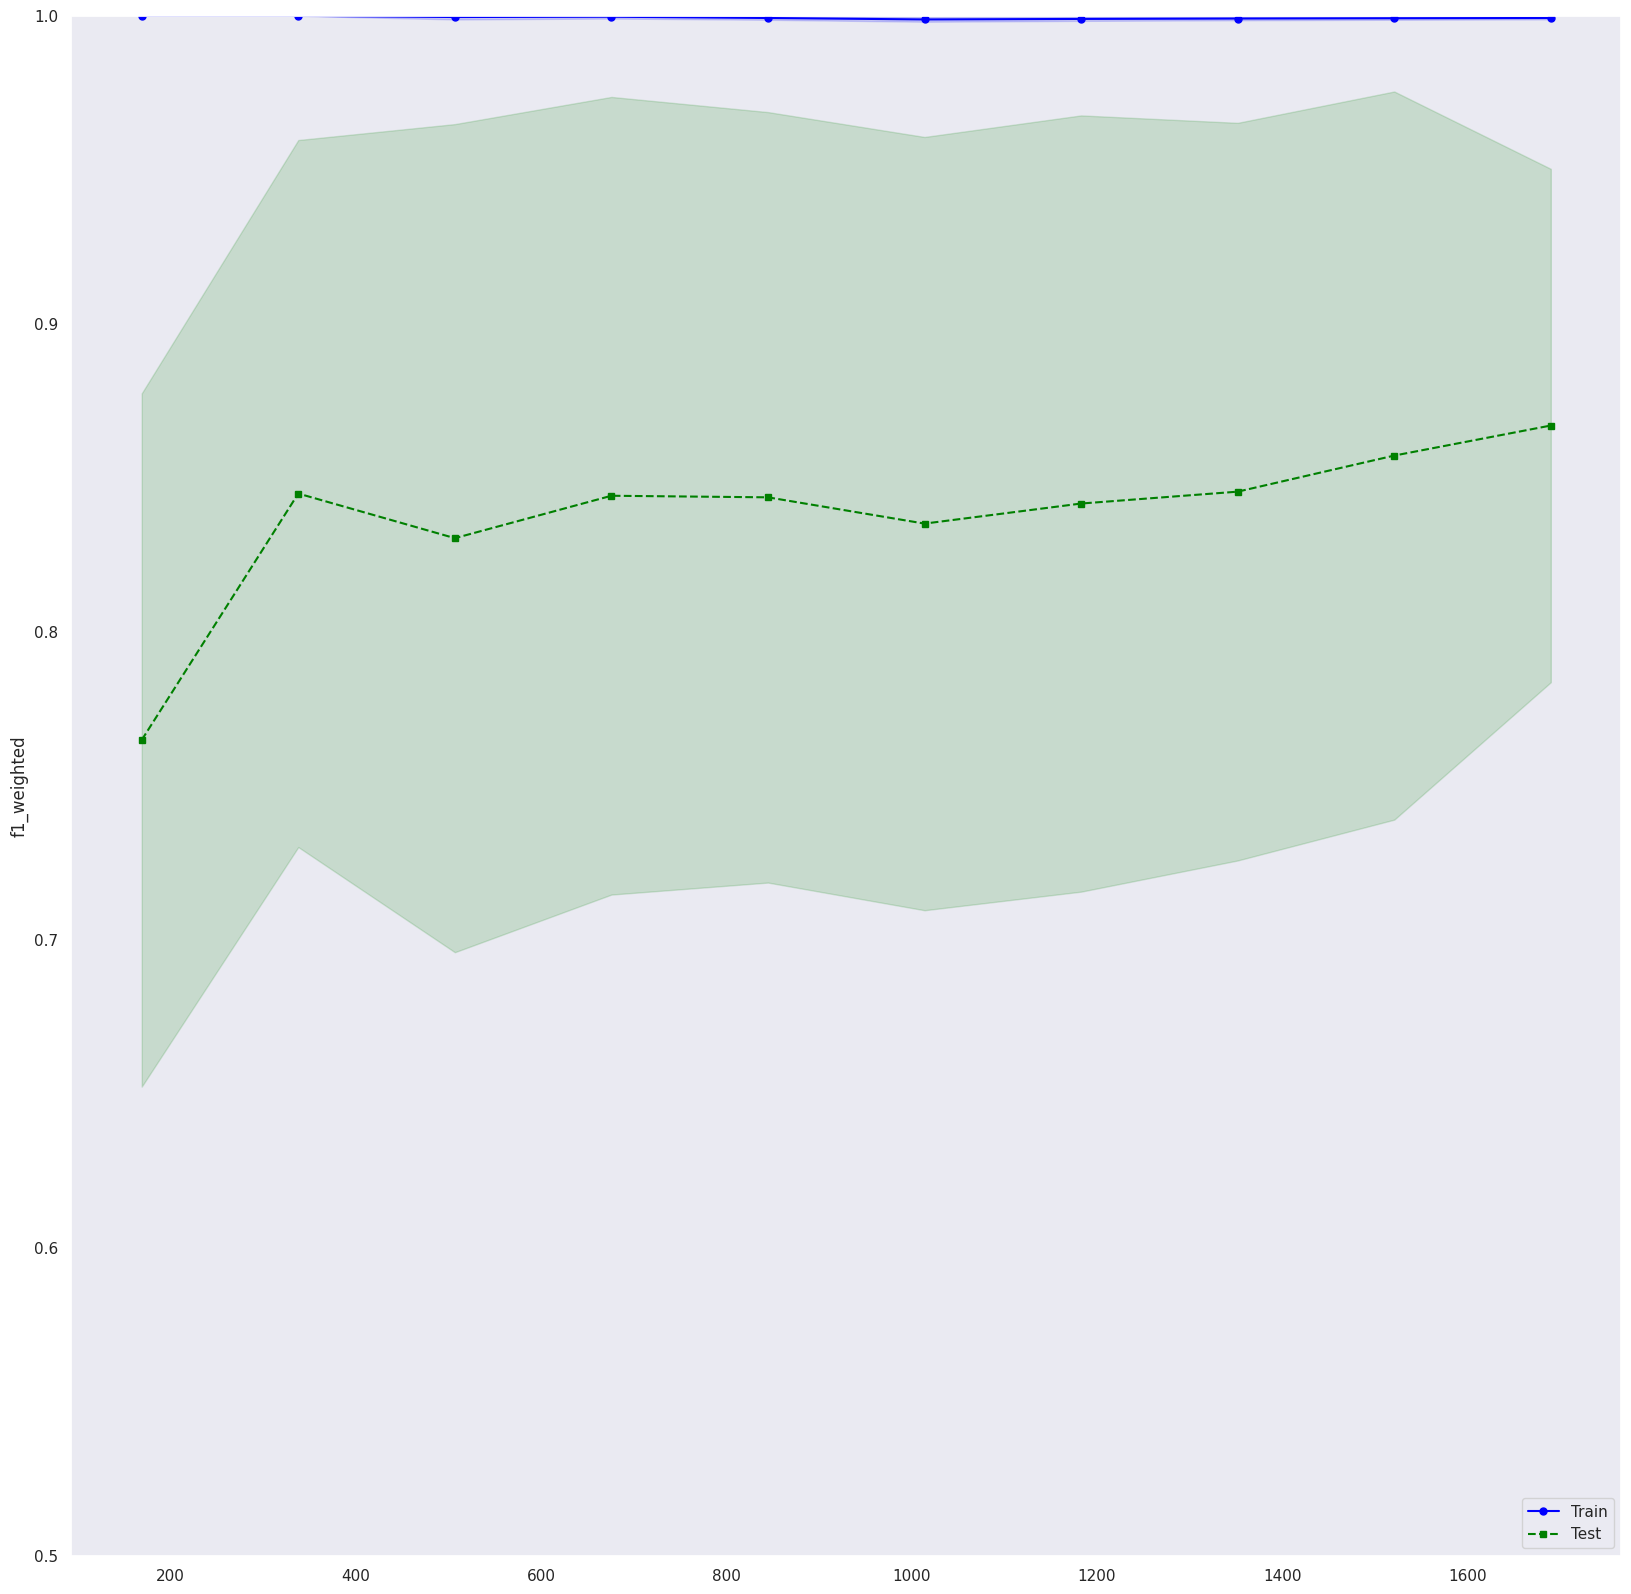

In [264]:
lr_curve(X, y, final_model_lgbm, cv=5, scoring="f1_weighted")

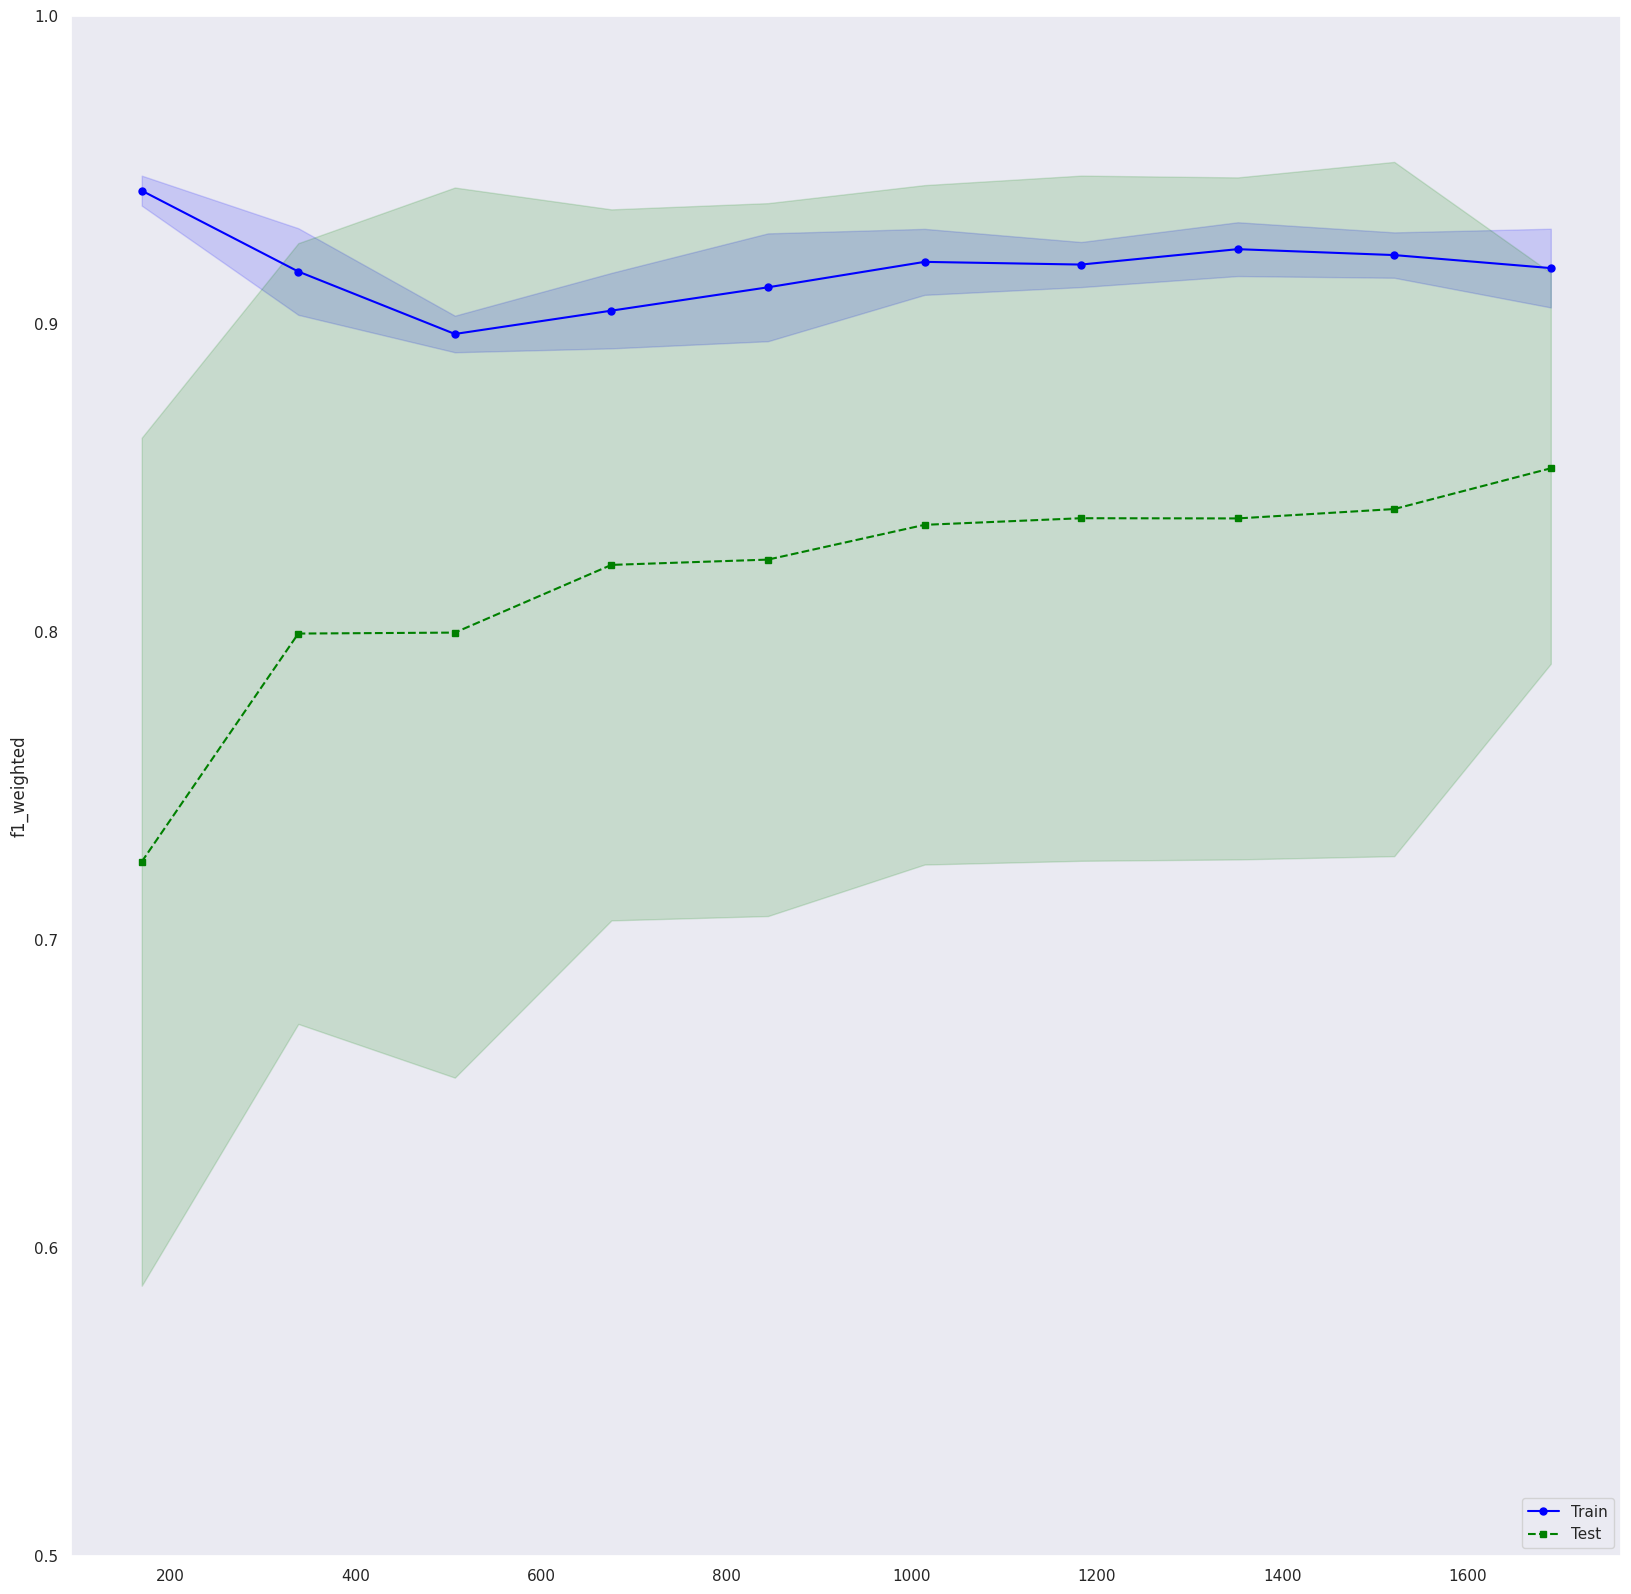

In [265]:
lr_curve(X, y, final_model_lr, cv=5, scoring="f1_weighted")

In [266]:
#Random observations predictions
random_obs_indices = np.random.choice(X.shape[0], 50, replace=False)
random_obs = X[random_obs_indices]

print(final_model_xgboost.predict(random_obs))
print(final_model_rf.predict(random_obs))
print(final_model_lgbm.predict(random_obs))

[0 0 0 1 0 0 0 1 1 0 0 2 2 0 0 0 0 2 0 2 2 1 1 1 0 1 0 1 0 2 0 1 0 1 0 1 1
 0 1 0 0 0 0 1 1 2 0 0 0 0]
[1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 2. 2. 0. 0. 0. 0. 2. 0. 2. 2. 1. 1. 1.
 0. 1. 0. 1. 0. 2. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 2. 0. 0.
 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 2. 2. 0. 0. 0. 0. 2. 0. 2. 2. 1. 1. 1.
 0. 1. 0. 1. 0. 2. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 2. 0. 0.
 0. 0.]


Voting classifier
---

In [267]:
#Choosed 3 models for voting classifier
final_model = voting_classifier(best_models, X, y)

Voting Classifier...
f1_score: 0.87
auc_score: 0.9542


Confusion Matrix of VC
---

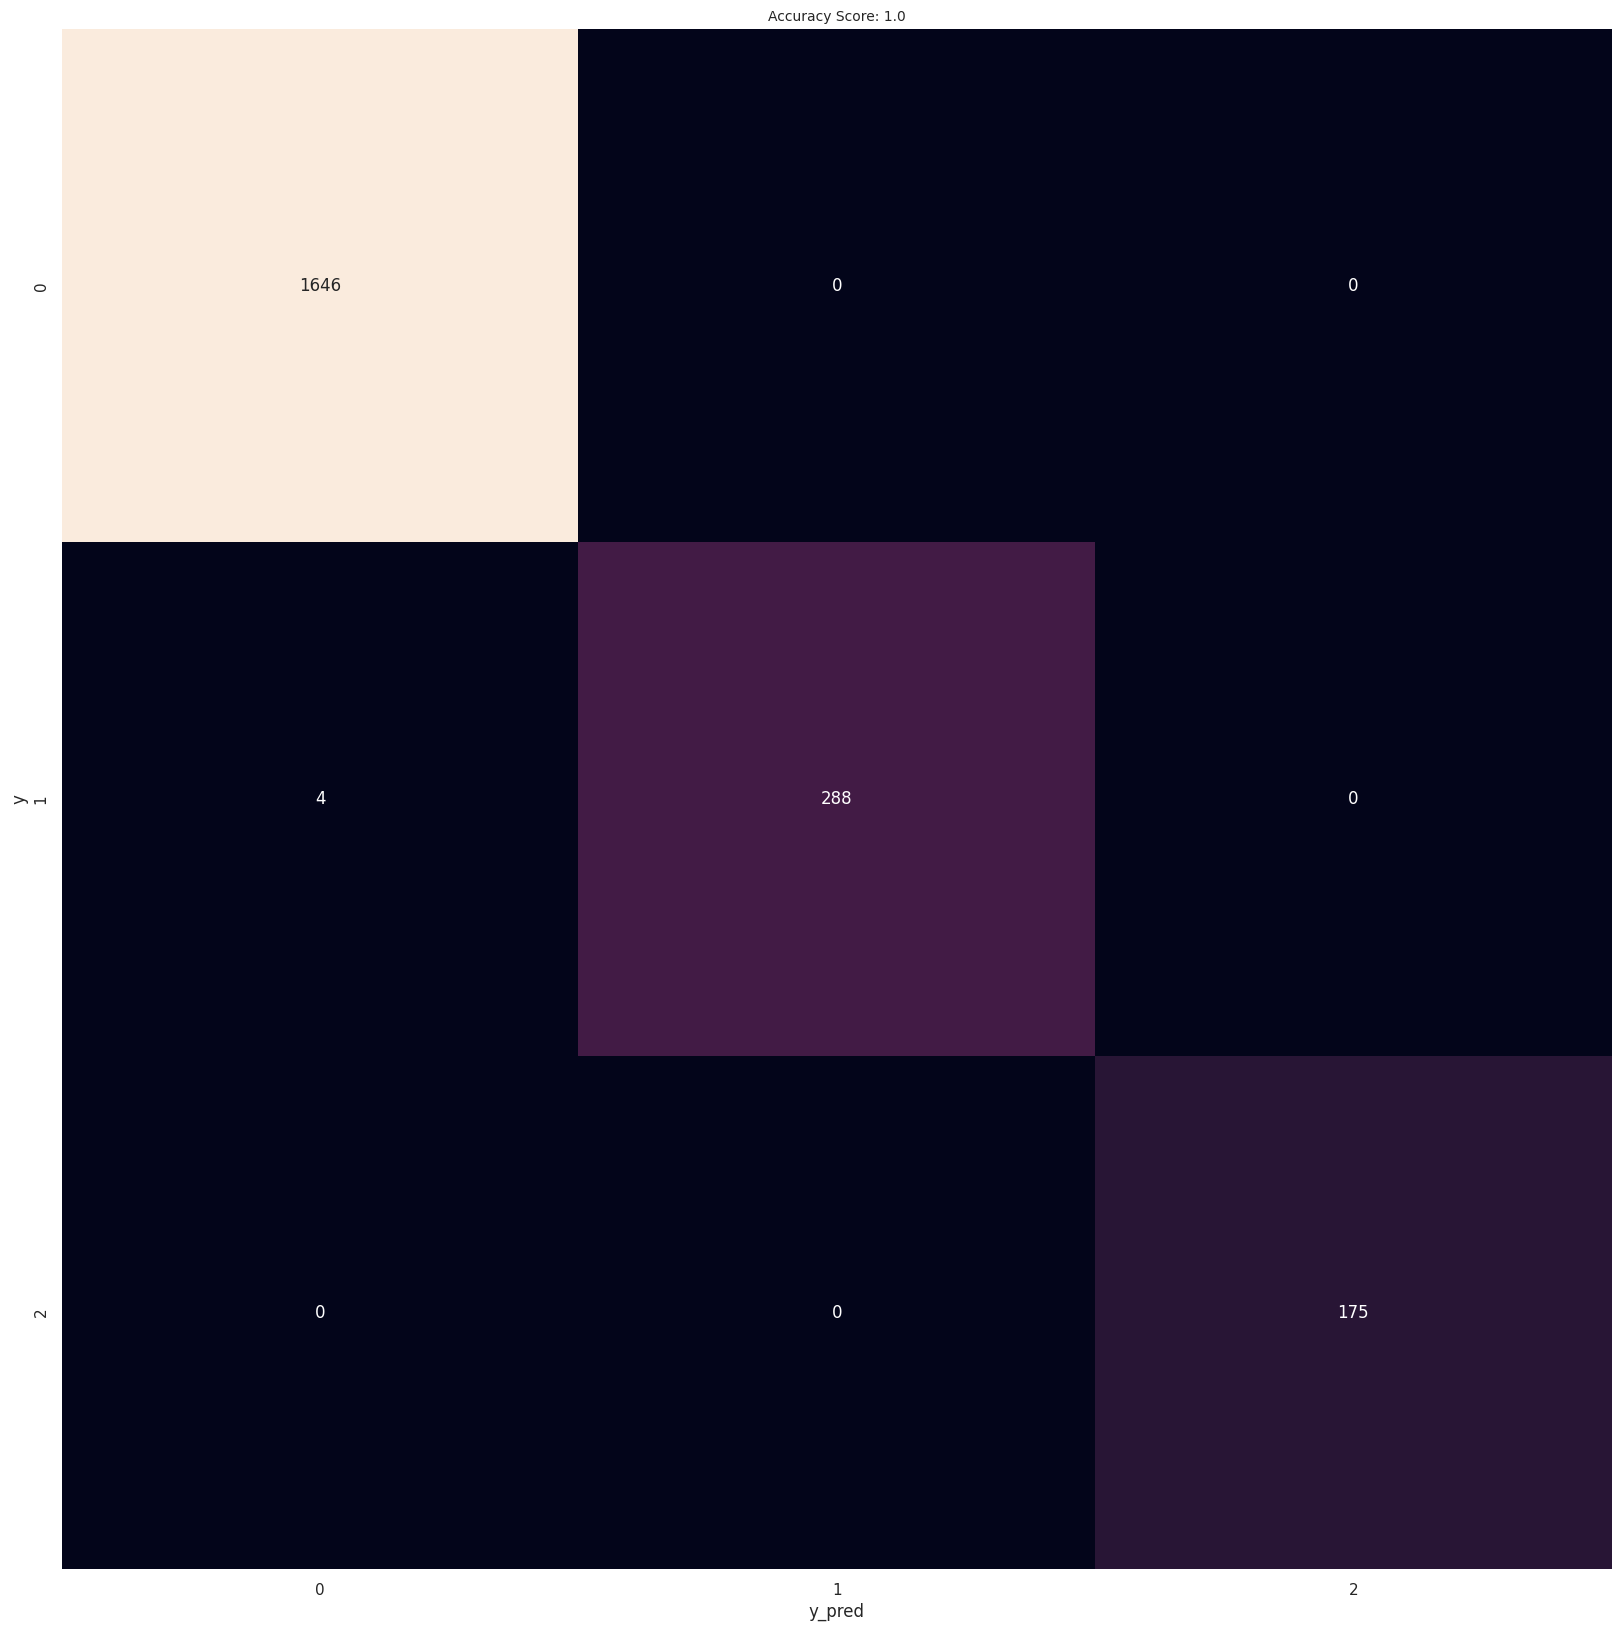

In [268]:
y_pred = final_model.predict(X)

plot_confusion_matrix(y, y_pred)

In [269]:
#Random final model prediction

random_obs_indices = np.random.choice(X.shape[0], 50, replace=False)
random_obs = X[random_obs_indices]

final_model.predict(random_obs)

array([2., 0., 0., 0., 0., 1., 0., 0., 2., 0., 0., 0., 2., 0., 0., 0., 0.,
       0., 1., 2., 0., 1., 0., 2., 0., 0., 0., 2., 2., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# 6. Summary and Results



Results
---

We decided our workflow as a

1. **Feature Engineering** with 10 new variables.


    *   N_TOTAL_DECELERATIONS : Total of mild, severe and prolonged decelerations.
    *   N_ABNORMAL_VARIABILITY_SCORE : Score of abnormal and normal variability
    *   N_MEAN_VARIABILITY_SCORE : Score of short term and long term mean variability
    *   N_TOTAL_VARIABILITY : Sum of short-term and long-term variability
    *   N_LONG_TERM_VARIABILITY_RATE : Percentage of abnormal and normal long variability rate
    *   N_SHORT_TERM_VARIABILITY_RATE : Percentage of abnormal and normal short variability rate
    *   N_ACCELERATION_RATIO : Ratio of the number of accelerations to the total number of fetal movements
    *   N_DECELERATION_RATIO : Ratio of the number of decelerations to the total number of fetal movements
    *   N_FETAL_ACTIVITY_RATIO : Total activity of baby ratio
    *   HISTOGRAM_SYMMETRY : Score of normal distrubition

2. Scaled with **StandardScaler**


3. **SMOTE**

In our project, data set was unbalanced. We aimed to increase the number of samples in the minority class and eliminate this imbalance by applying the SMOTE technique.

Afterwards, sythnetic data was generated with 4938
observations.

4. **Decision**

We decided to do a modelling comparison with LR, SVC and KNN in three different ways which are  

  *   SMOTE dataset
  *   Feature Engineering dataset
  *   BOTH are occured to dataset

because we think there is overfitting. As our dataset is not complex, we think that there is overfitting as model complexity increases, so we used more traditional modelling.



# **PART 2**

---

*   Modelling with 3 methods w/ SMOTE or FEATURE ENGINERING and both

*   Decision of which traditional modeling will be used.


# 1. Dataset Preparation

In [270]:
#import dataset

dff= pd.read_csv("/content/fetal_health.csv")

# Renaming some value columns to make them easier to work with
dff = dff.rename(columns = {'baseline value':'baseline_value',
                          'percentage_of_time_with_abnormal_long_term_variability': 'abnormal_long_term_variability',
                          'prolongued_decelerations': 'prolonged_decelerations'})
dff.head()

baseline_value  accelerations  fetal_movement  uterine_contractions  light_decelerations  severe_decelerations  prolonged_decelerations  abnormal_short_term_variability  mean_value_of_short_term_variability  abnormal_long_term_variability  mean_value_of_long_term_variability  histogram_width  histogram_min  histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  histogram_mode  histogram_mean  histogram_median  histogram_variance  histogram_tendency  fetal_health
0           120.0          0.000             0.0                 0.000                0.000                   0.0                      0.0                             73.0                                   0.5                            43.0                                  2.4             64.0           62.0          126.0                        2.0                         0.0           120.0           137.0             121.0                73.0                 1.0           2.0
1           132.0          0.006             0.0                 0.006                0.003                   0.0                      0.0                             17.0                                   2.1                             0.0                                 10.4            130.0           68.0          198.0                        6.0                         1.0           141.0           136.0             140.0                12.0                 0.0           1.0
2           133.0          0.003             0.0                 0.008                0.003                   0.0                      0.0                             16.0                                   2.1                             0.0                                 13.4            130.0           68.0          198.0                        5.0                         1.0           141.0           135.0             138.0                13.0                 0.0           1.0
3           134.0          0.003             0.0                 0.008                0.003                   0.0                      0.0                             16.0                                   2.4                             0.0                                 23.0            117.0           53.0          170.0                       11.0                         0.0           137.0           134.0             137.0                13.0                 1.0           1.0
4           132.0          0.007             0.0                 0.008                0.000                   0.0                      0.0                             16.0                                   2.4                             0.0                                 19.9            117.0           53.0          170.0                        9.0                         0.0           137.0           136.0             138.0                11.0                 1.0           1.0

In [275]:
dff.loc[dff['fetal_health']==1, 'fetal_health'] = 0
dff.loc[dff['fetal_health']==2, 'fetal_health'] = 1
dff.loc[dff['fetal_health']==3, 'fetal_health'] = 2

target_col = "fetal_health"
num_cols = [col for col in dff.columns if col not in [target_col]]

#drop duplicates
dff = dff.drop_duplicates()
dff.head()
df_smote = dff.copy()

In [276]:
def lr_curve(X, y, estimator, cv=5, scoring="accuracy"):

    train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y,
                                                            train_sizes=np.linspace(0.1, 1.0, 10), cv=cv, scoring=scoring)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Train')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Test')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
    plt.grid()
    plt.ylabel(scoring)
    plt.legend(loc='lower right')
    plt.ylim([0.5, 1.0])
    plt.show()



# 2. SMOTE w/out Feature Engineering

In [277]:
#SMOTE w/out Feature Engineering
X = df_smote.drop("fetal_health", axis=1)
y = df_smote["fetal_health"]
print(df_smote.shape)


scaler = StandardScaler()
X = scaler.fit_transform(X)

X, y = smote_df(X, y)

(2113, 22)


In [278]:

all_scoring = {'accuracy': make_scorer(accuracy_score),
               'precision': make_scorer(precision_score, average='weighted'),
               'recall': make_scorer(recall_score, average='weighted'),
               'f1_score': make_scorer(f1_score, average='weighted')}

base_models(X, y, all_scoring)

Base Models....
LR
f1_score: 0.8748
Accuracy: 0.875
Recall: 0.875
Precision: 0.8812
-------------
KNN
f1_score: 0.9224
Accuracy: 0.9239
Recall: 0.9239
Precision: 0.9348
-------------
SVC
f1_score: 0.9196
Accuracy: 0.9202
Recall: 0.9202
Precision: 0.9269
-------------
CART
f1_score: 0.9037
Accuracy: 0.9076
Recall: 0.9076
Precision: 0.9144
-------------
RF
f1_score: 0.9509
Accuracy: 0.952
Recall: 0.952
Precision: 0.9556
-------------
Adaboost
f1_score: 0.8857
Accuracy: 0.886
Recall: 0.886
Precision: 0.8887
-------------
GBM
f1_score: 0.9334
Accuracy: 0.9356
Recall: 0.9356
Precision: 0.9416
-------------
XGBoost
f1_score: 0.9474
Accuracy: 0.9492
Recall: 0.9492
Precision: 0.9533
-------------
LightGBM
f1_score: 0.9488
Accuracy: 0.9506
Recall: 0.9506
Precision: 0.9549
-------------
CatBoost
f1_score: 0.9501
Accuracy: 0.9516
Recall: 0.9516
Precision: 0.9559
-------------
GNB
f1_score: 0.7558
Accuracy: 0.7531
Recall: 0.7531
Precision: 0.8174
-------------


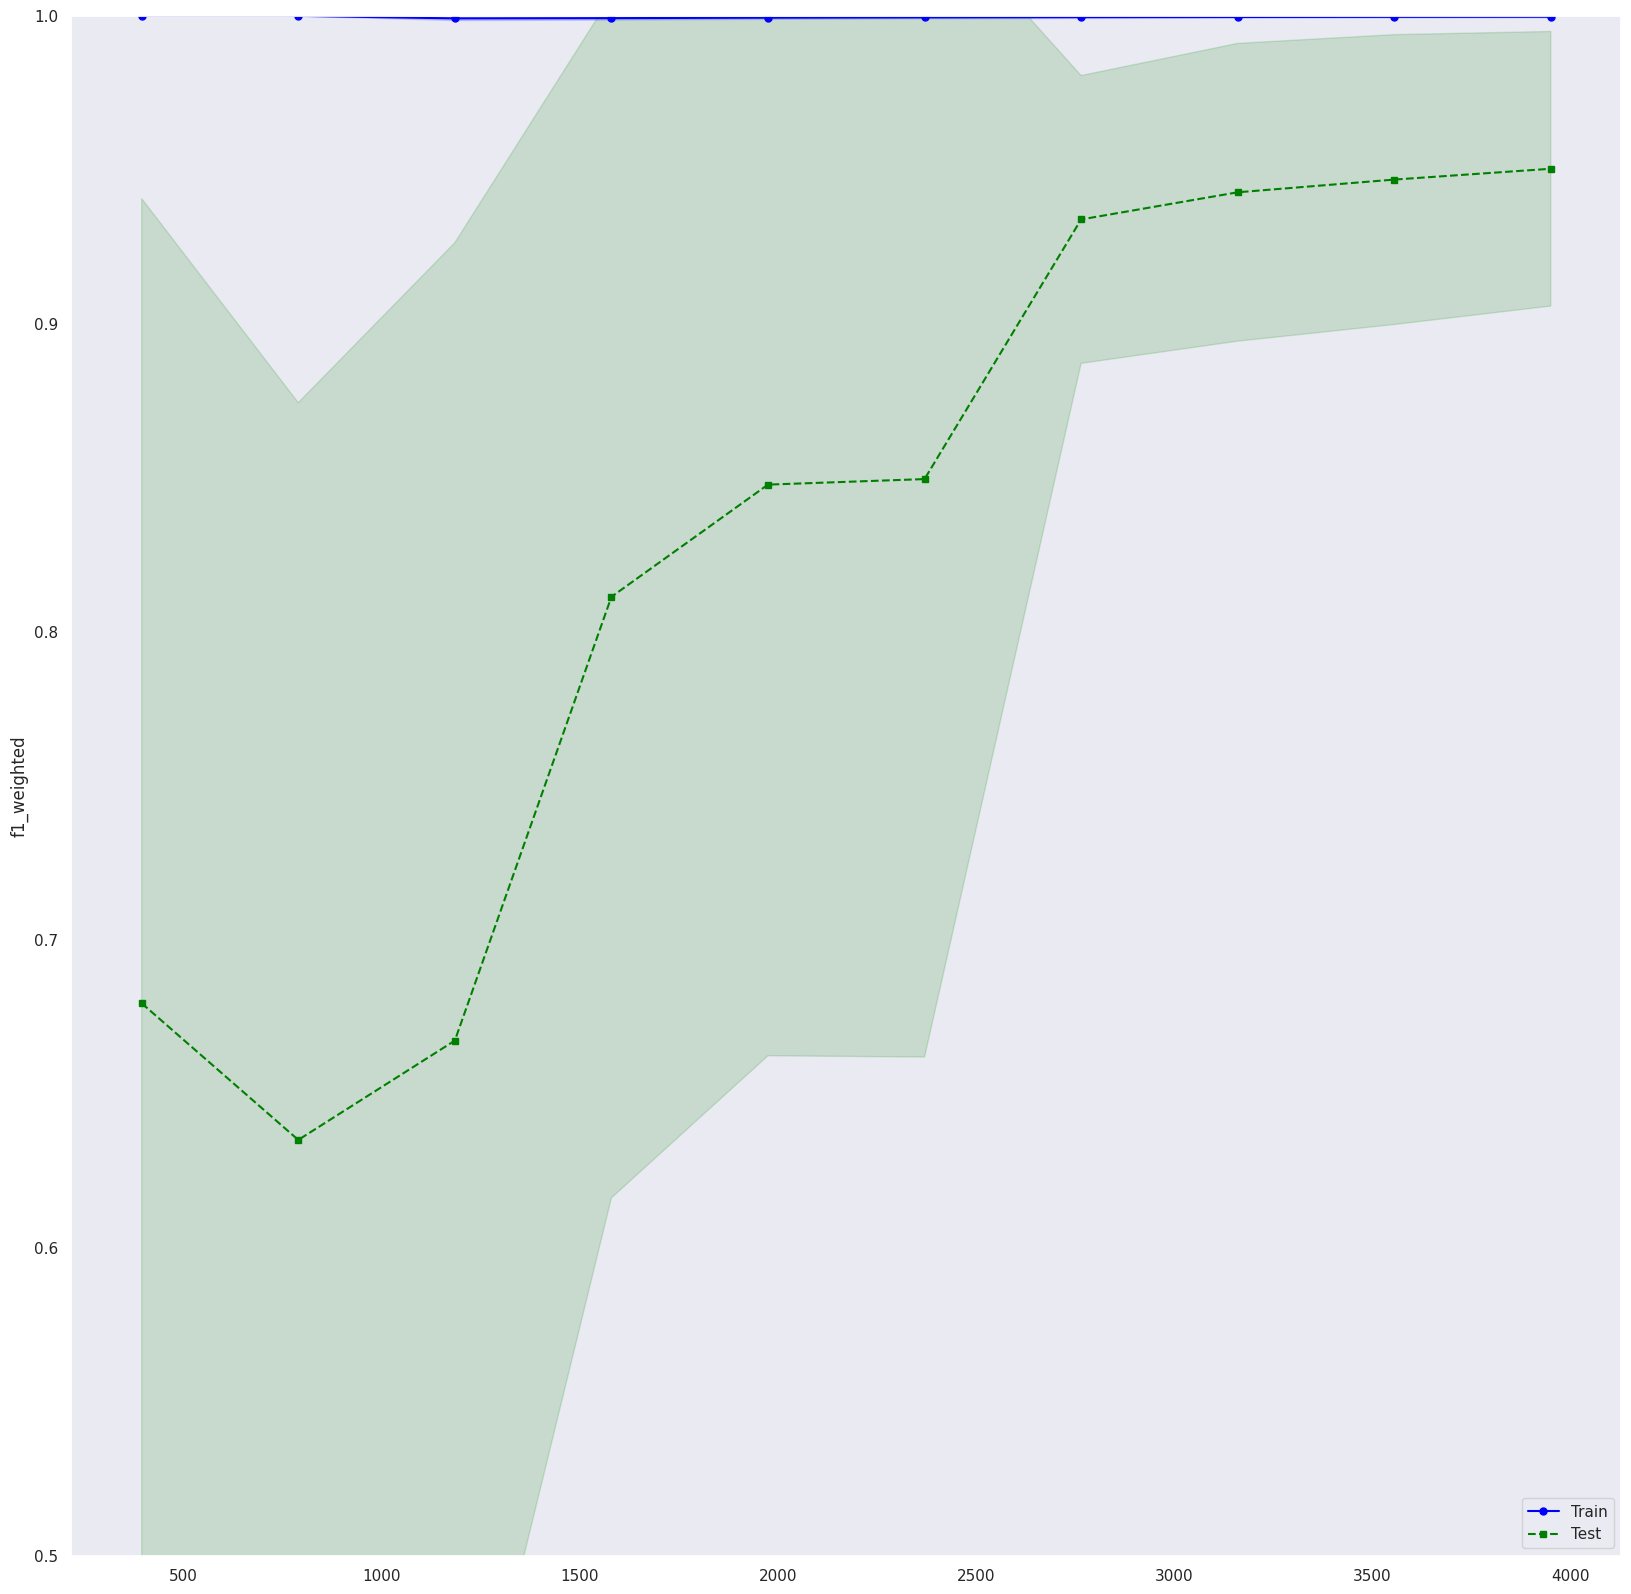

In [279]:
lgbm_final = LGBMClassifier(verbose= -1, random_state=42).fit(X, y)
lr_curve(X, y, lgbm_final, cv=5, scoring="f1_weighted")

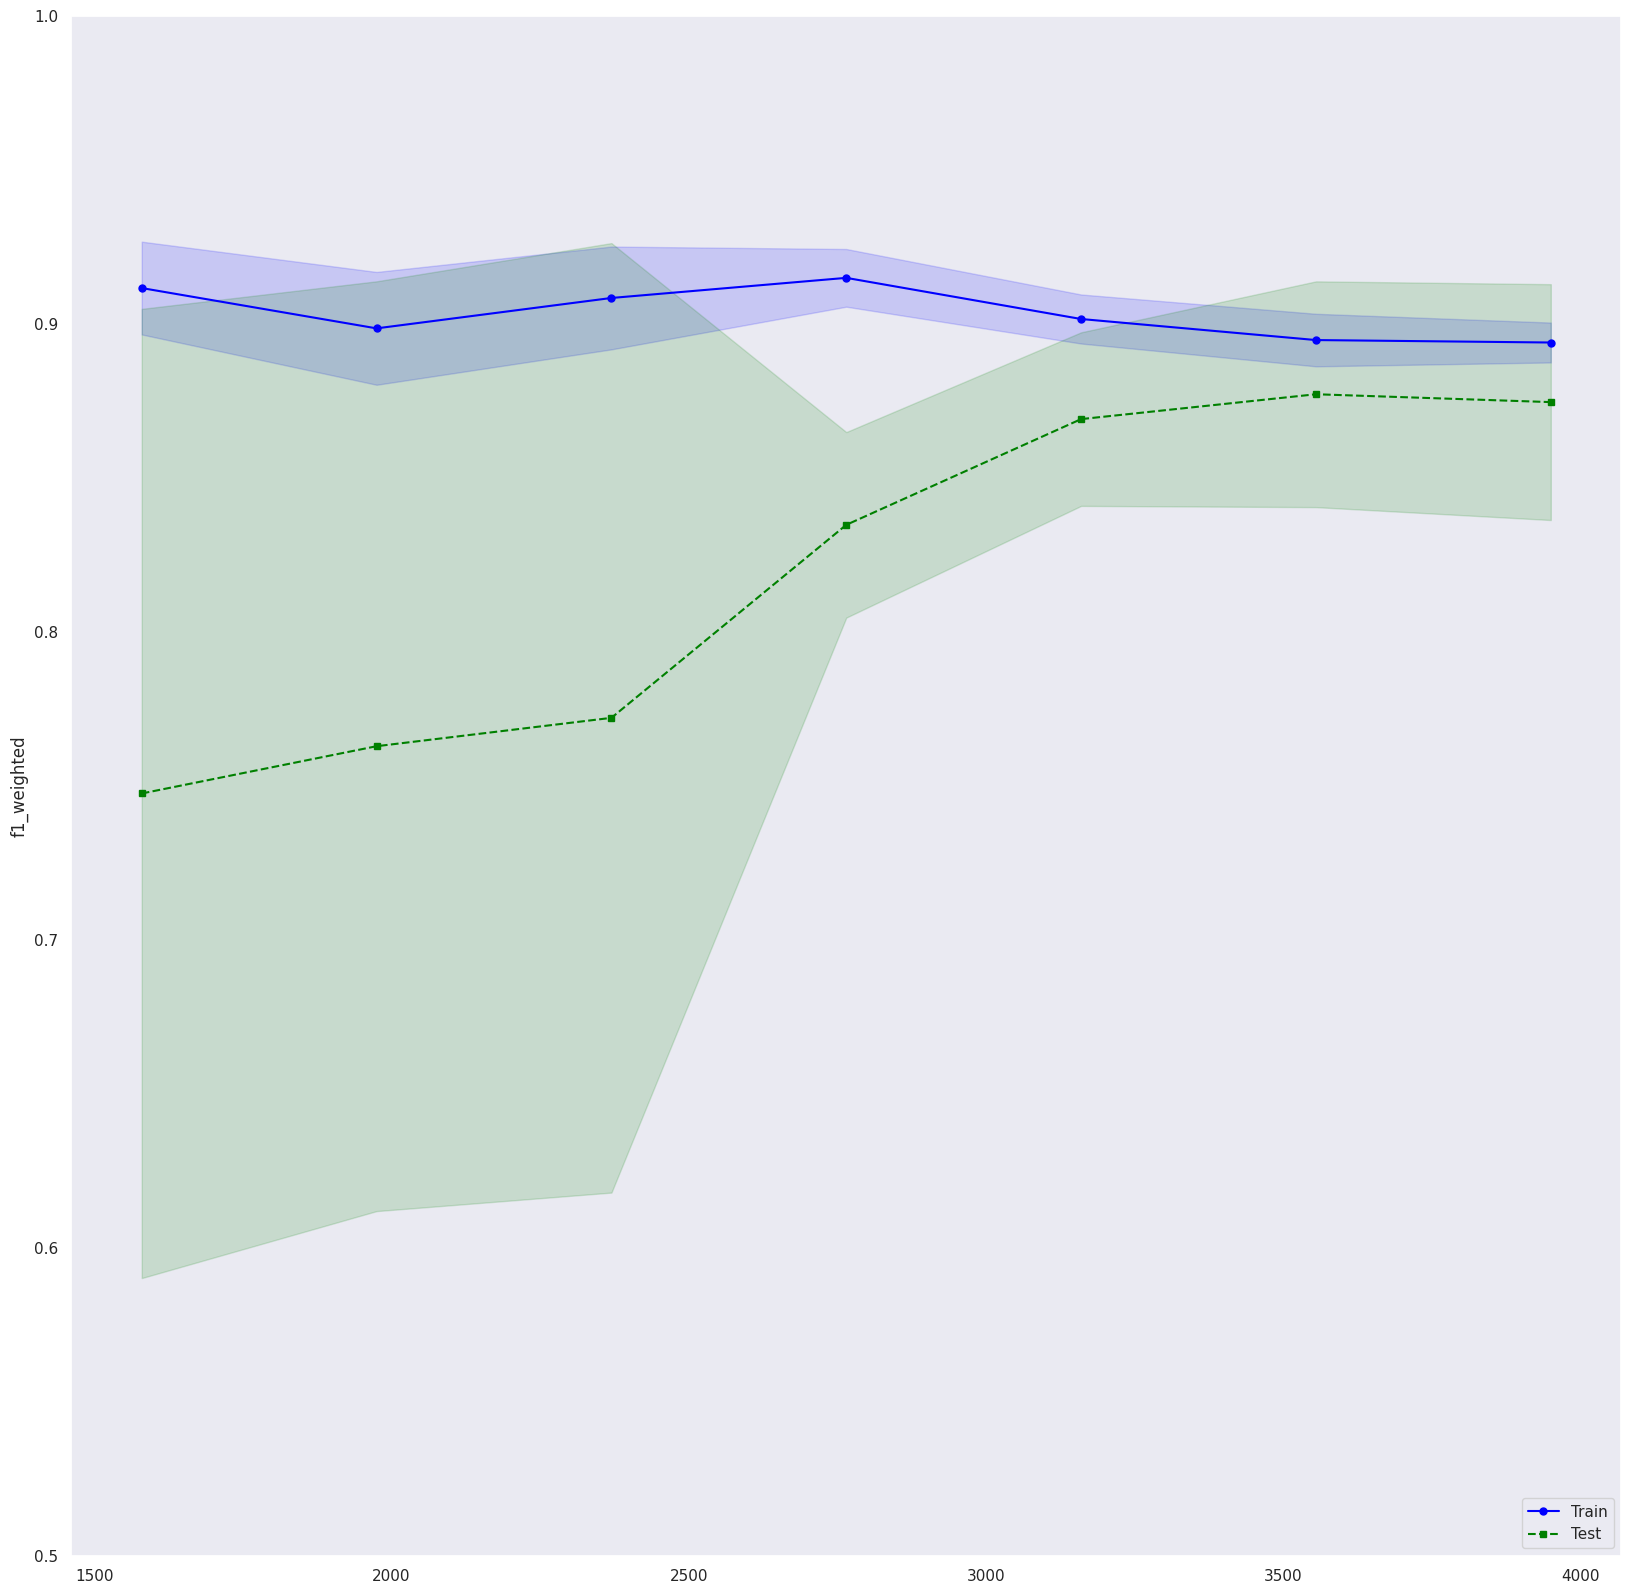

In [280]:
lr_final = LogisticRegression(random_state=42).fit(X, y)

lr_curve(X, y, lr_final, cv=5, scoring="f1_weighted")

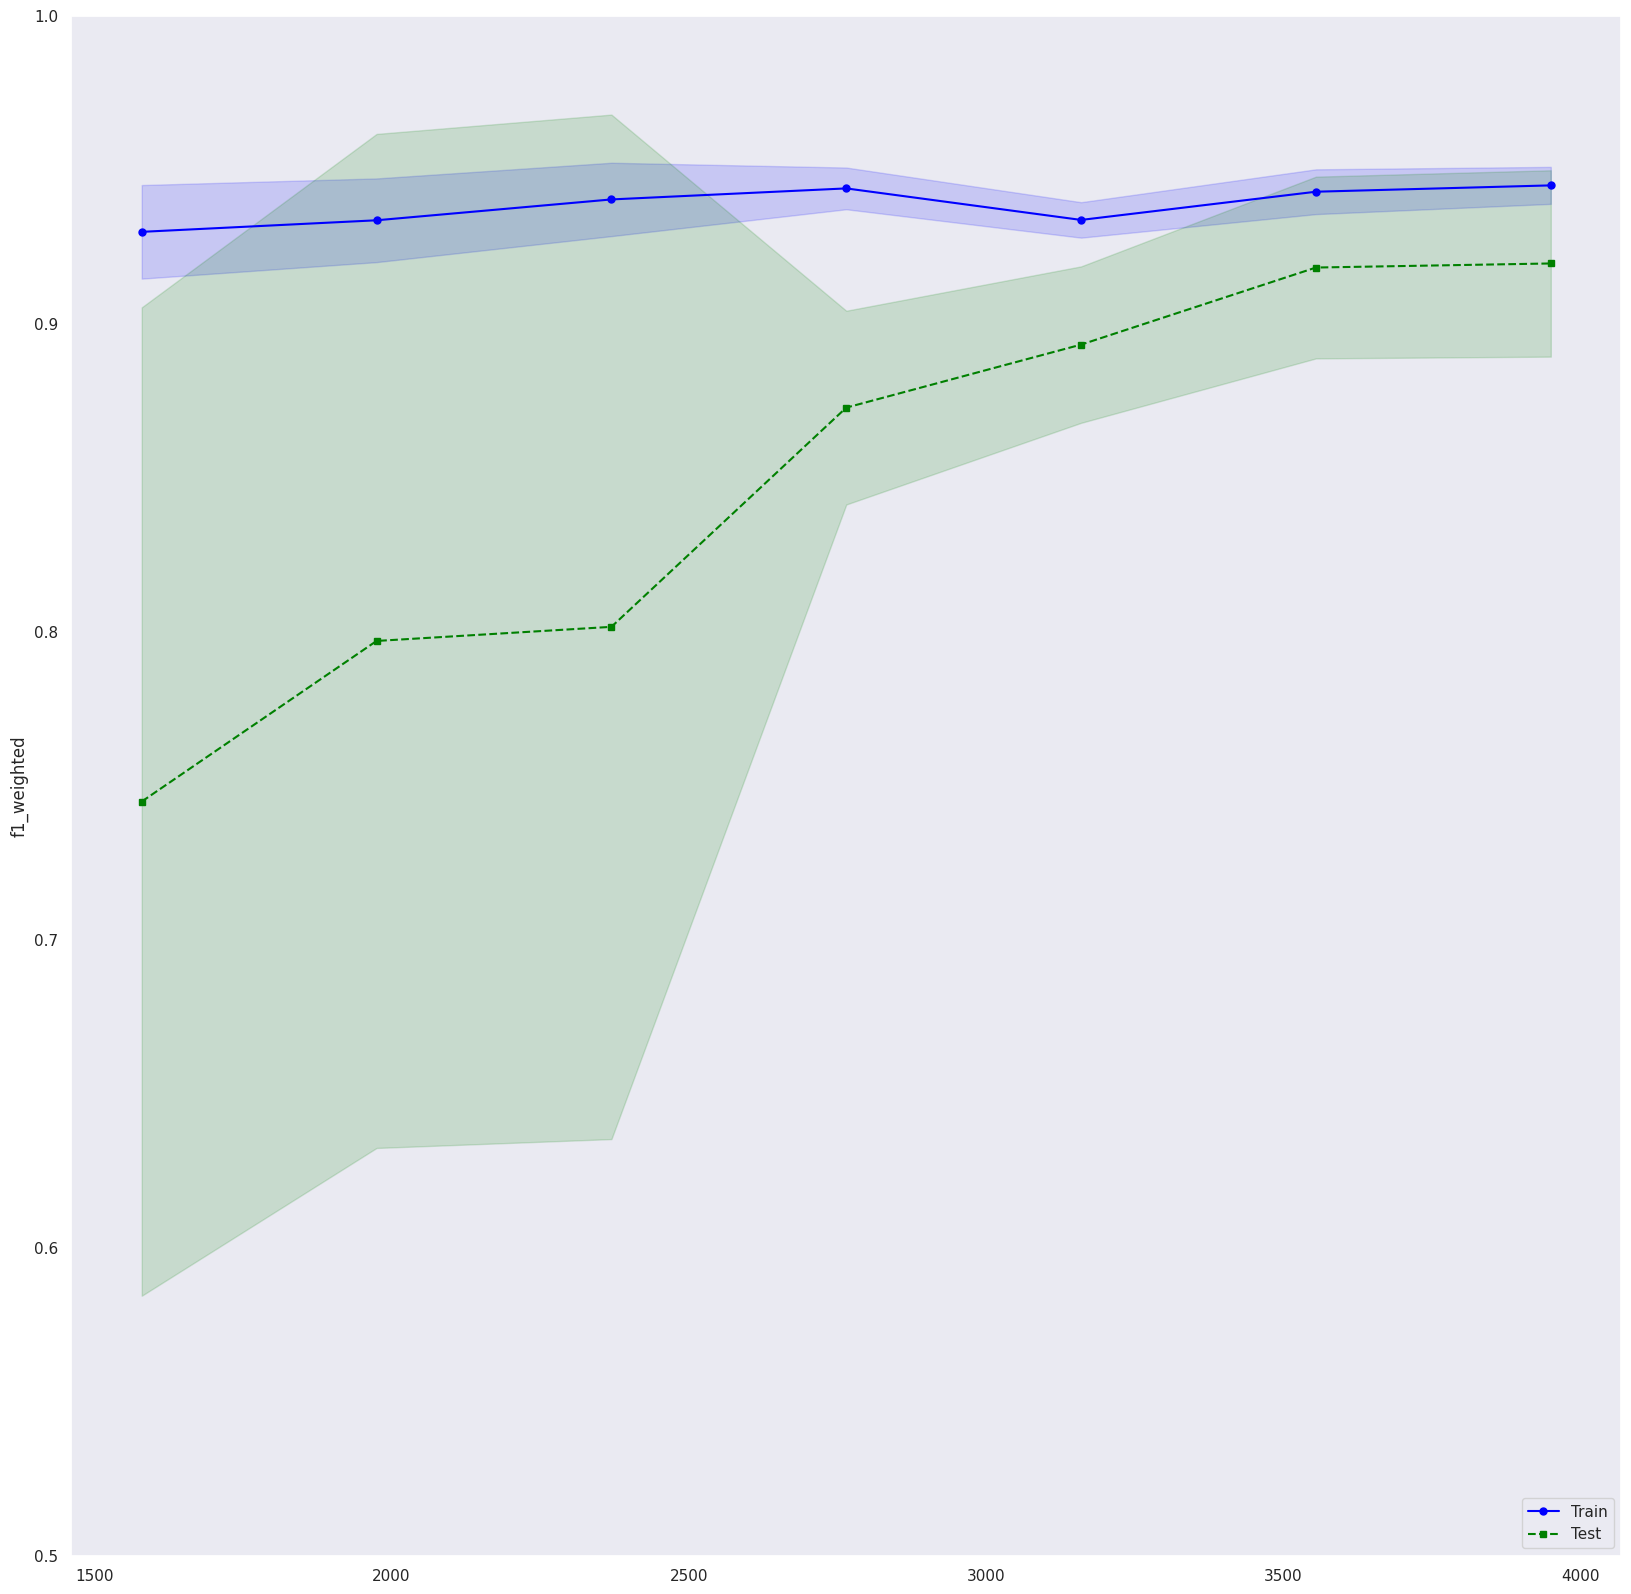

In [281]:
svc_final = SVC(random_state=42).fit(X, y)


lr_curve(X, y, svc_final, cv=5, scoring="f1_weighted")

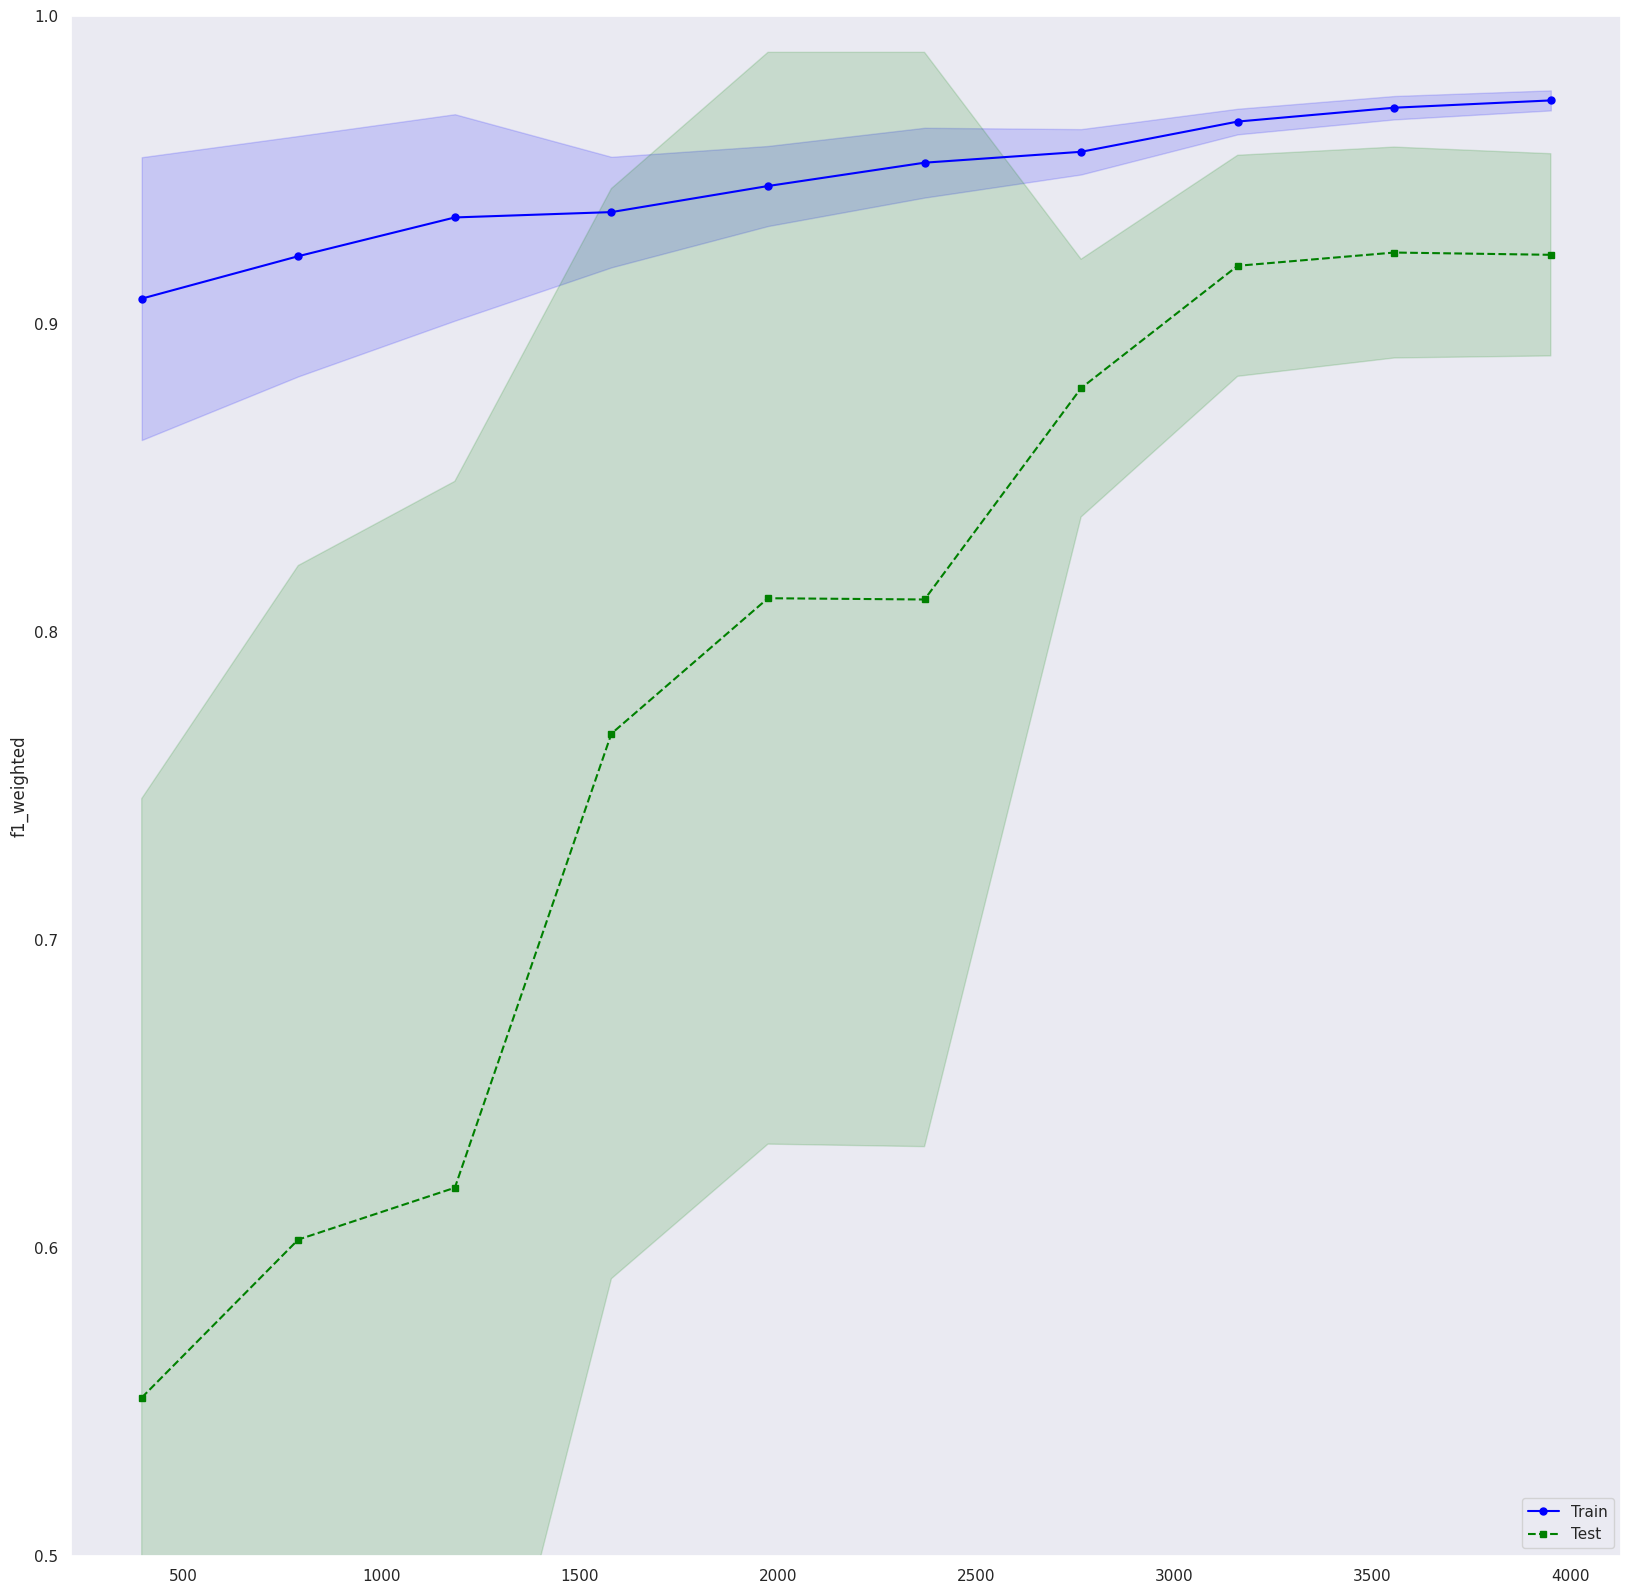

In [282]:
knn_final = KNeighborsClassifier().fit(X, y)

lr_curve(X, y, knn_final, cv=5, scoring="f1_weighted")

# 3. Feature Engineering w/out SMOTE


In [283]:
#Feature Engineering w/out SMOTE
df_f = df.copy()
df_f.head()


baseline_value  accelerations  fetal_movement  uterine_contractions  light_decelerations  severe_decelerations  prolonged_decelerations  abnormal_short_term_variability  mean_value_of_short_term_variability  abnormal_long_term_variability  mean_value_of_long_term_variability  histogram_width  histogram_min  histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  histogram_mode  histogram_mean  histogram_median  histogram_variance  histogram_tendency  fetal_health  \
0      120.000001       0.000001        0.000001              0.000001             0.000001              0.000001                 0.000001                        73.000001                              0.500001                       43.000001                             2.400001        64.000001      62.000001     126.000001                   2.000001                    0.000001      120.000001      137.000001        121.000001           73.000001            1.000001           1.0   
1      132.000001       0.006001        0.000001              0.006001             0.003001              0.000001                 0.000001                        17.000001                              2.100001                        0.000001                            10.400001       130.000001      68.000001     198.000001                   6.000001                    1.000001      141.000001      136.000001        140.000001           12.000001            0.000001           0.0   
2      133.000001       0.003001        0.000001              0.008001             0.003001              0.000001                 0.000001                        16.000001                              2.100001                        0.000001                            13.400001       130.000001      68.000001     198.000001                   5.000001                    1.000001      141.000001      135.000001        138.000001           13.000001            0.000001           0.0   
3      134.000001       0.003001        0.000001              0.008001             0.003001              0.000001                 0.000001                        16.000001                              2.400001                        0.000001                            23.000001       117.000001      53.000001     170.000001                  11.000001                    0.000001      137.000001      134.000001        137.000001           13.000001            1.000001           0.0   
4      132.000001       0.007001        0.000001              0.008001             0.000001              0.000001                 0.000001                        16.000001                              2.400001                        0.000001                            19.900001       117.000001      53.000001     170.000001                   9.000001                    0.000001      137.000001      136.000001        138.000001           11.000001            1.000001           0.0   

   N_total_decelerations  N_short_term_variability_rate  N_long_term_variability_rate  N_abnormal_variability_score  N_mean_variability_score  N_total_variability  N_acceleration_ratio  N_deceleration_ratio  N_fetal_activity_ratio  histogram_symmetry  
0               0.000003                       0.993197                  9.471365e-01                    116.000002                  2.900002           118.900004              0.333333              1.000000                0.500000                16.0  
1               0.003003                       0.890052                  9.615383e-08                     17.000002                 12.500002            29.500004              0.499958              0.250187                0.000167                 4.0  
2               0.003003                       0.883978                  7.462685e-08                     16.000002                 15.500002            31.500004              0.272744              0.272926                0.000125                 3.0  
3               0.003003                       0.869565       

In [284]:
#Feature Engineering
df_f[num_cols] = df_f[num_cols] + 0.000001

df_f['N_total_decelerations'] = df_f['light_decelerations'] + df_f['severe_decelerations'] + df_f['prolonged_decelerations']

# Percentage of abnormal short and long variability rate
df_f['N_short_term_variability_rate'] = df_f['abnormal_short_term_variability'] / (df_f['abnormal_short_term_variability'] + df_f['mean_value_of_short_term_variability'])
df_f['N_long_term_variability_rate'] = df_f['abnormal_long_term_variability'] / (df_f['abnormal_long_term_variability'] + df_f['mean_value_of_long_term_variability'])

# Score of abnormal and normal variability
df_f['N_abnormal_variability_score'] = df_f['abnormal_short_term_variability'] + df_f['abnormal_long_term_variability']
df_f['N_mean_variability_score'] = df_f['mean_value_of_short_term_variability'] + df_f['mean_value_of_long_term_variability']

# Total Variability: Kısa vadeli ve uzun vadeli değişkenliğin toplamı.
df_f['N_total_variability'] = df_f['N_abnormal_variability_score'] + df_f['N_mean_variability_score']

# Acceleration Ratio: Accelerations sayısının toplam fetal hareket sayısına oranı.
df_f['N_acceleration_ratio'] = df_f['accelerations'] / (df_f['fetal_movement'] + df_f['accelerations'] + df_f['uterine_contractions'])

# Deceleration Ratio: Decelerations sayısının toplam fetal hareket sayısına oranı.
df_f['N_deceleration_ratio'] = df_f['N_total_decelerations'] / (df_f['fetal_movement'] + df_f['accelerations'] + df_f['uterine_contractions'])

# Fetal activity ratio
df_f["N_fetal_activity_ratio"] = df_f["fetal_movement"] / (df_f["fetal_movement"] + df_f["uterine_contractions"])

# Histogtam symmetry
df_f["histogram_symmetry"] = np.abs(df_f["histogram_mean"] - df_f["histogram_median"])

df_f.shape

(2113, 32)

In [285]:
X = df_f.drop("fetal_health", axis=1)
y = df_f["fetal_health"]

scaler = StandardScaler()
X = scaler.fit_transform(X)


base_models(X, y, all_scoring)

Base Models....
LR
f1_score: 0.8536
Accuracy: 0.8509
Recall: 0.8509
Precision: 0.8661
-------------
KNN
f1_score: 0.817
Accuracy: 0.8234
Recall: 0.8234
Precision: 0.8333
-------------
SVC
f1_score: 0.8309
Accuracy: 0.8338
Recall: 0.8338
Precision: 0.8498
-------------
CART
f1_score: 0.8198
Accuracy: 0.8092
Recall: 0.8092
Precision: 0.8546
-------------
RF
f1_score: 0.8675
Accuracy: 0.8665
Recall: 0.8665
Precision: 0.8808
-------------
Adaboost
f1_score: 0.8416
Accuracy: 0.8391
Recall: 0.8391
Precision: 0.8662
-------------
GBM
f1_score: 0.8771
Accuracy: 0.8731
Recall: 0.8731
Precision: 0.891
-------------
XGBoost
f1_score: 0.8684
Accuracy: 0.8632
Recall: 0.8632
Precision: 0.8908
-------------
LightGBM
f1_score: 0.8615
Accuracy: 0.8575
Recall: 0.8575
Precision: 0.8833
-------------
CatBoost
f1_score: 0.8718
Accuracy: 0.8688
Recall: 0.8688
Precision: 0.8896
-------------
GNB
f1_score: 0.7662
Accuracy: 0.7393
Recall: 0.7393
Precision: 0.8644
-------------


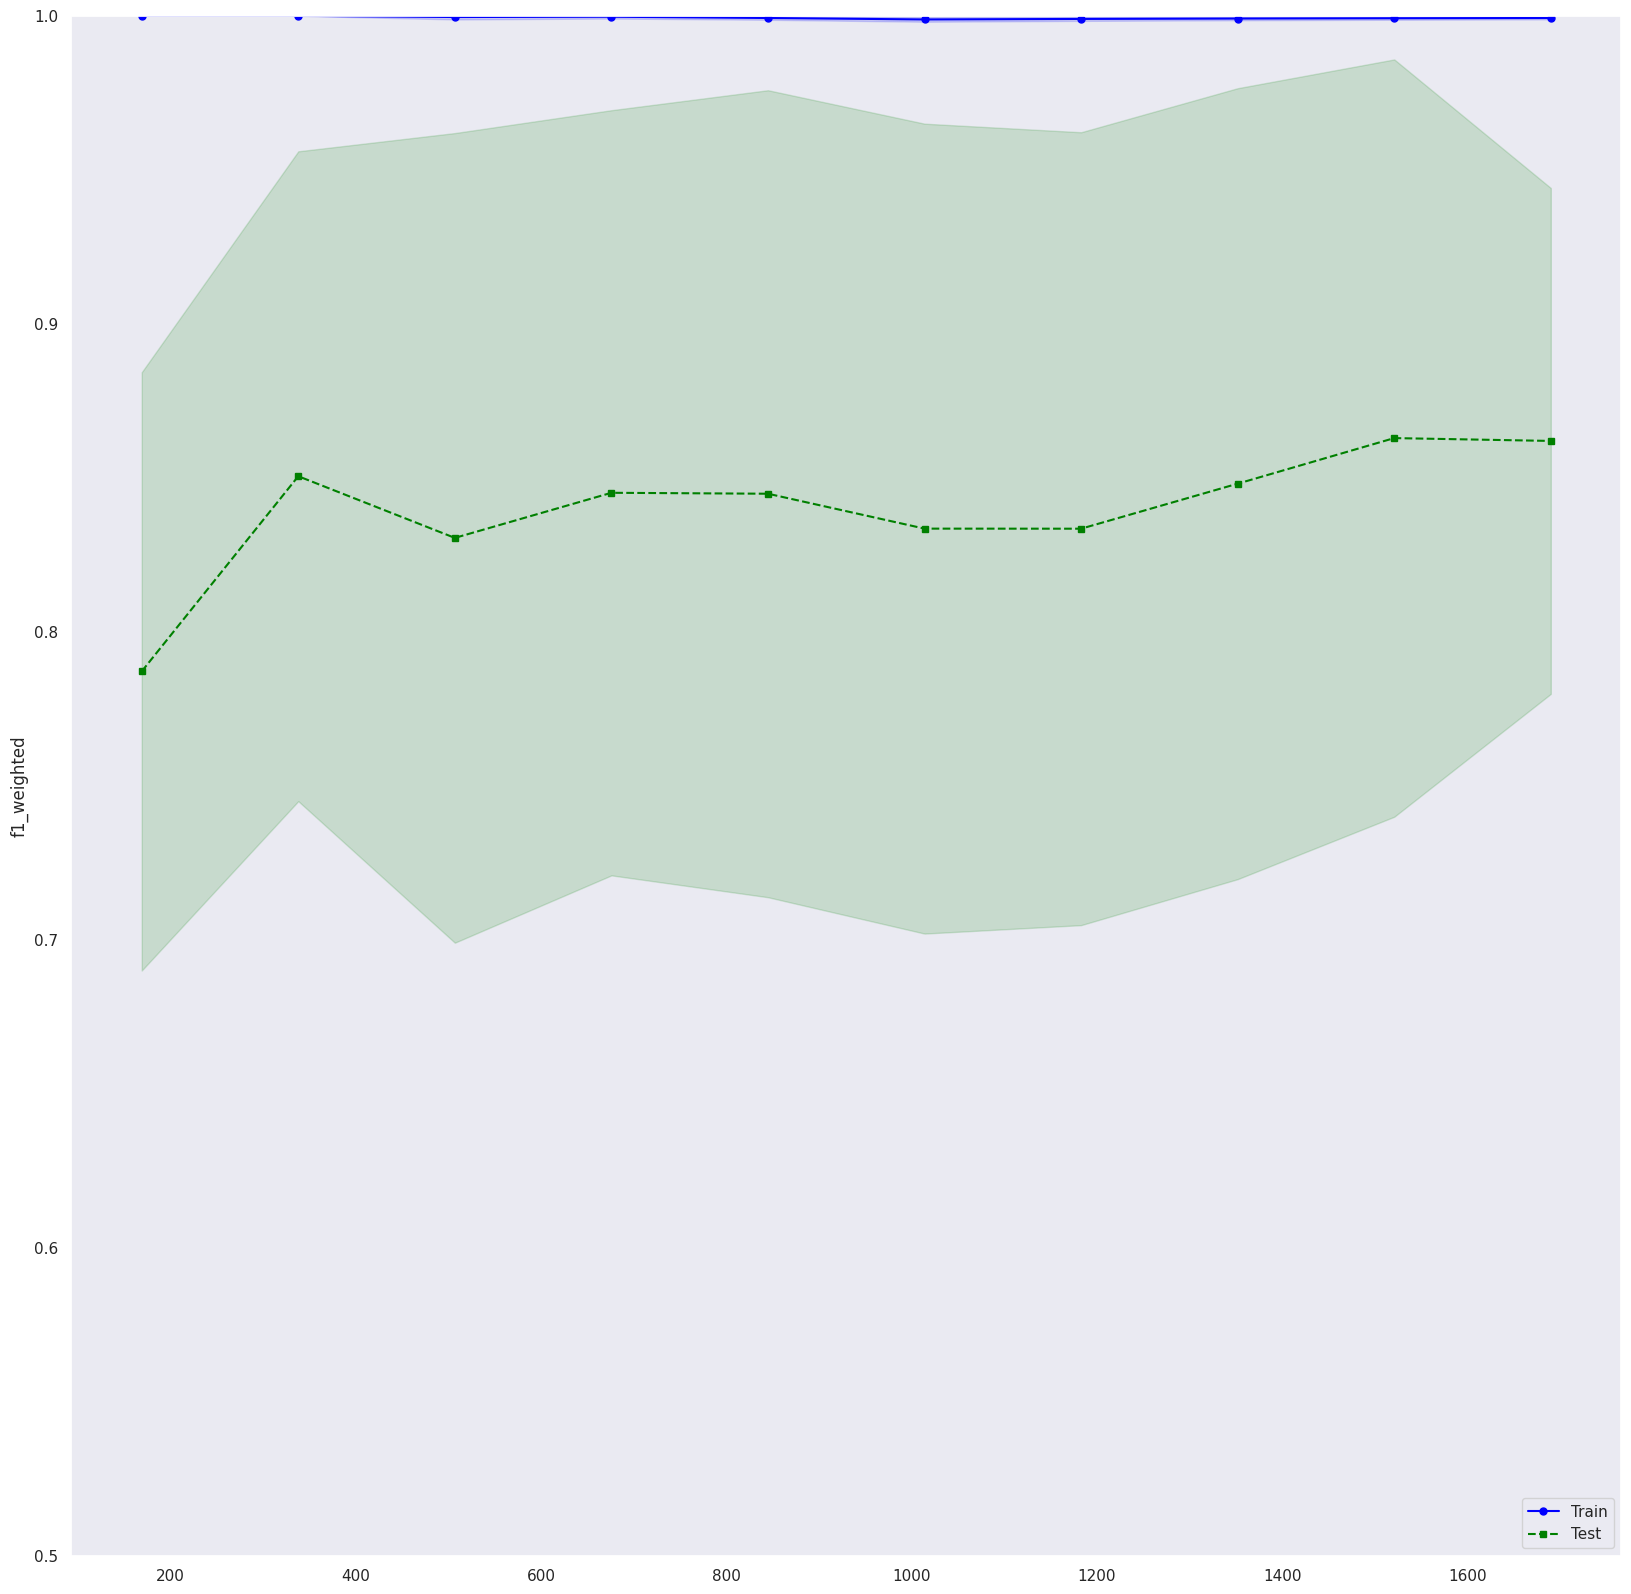

In [286]:
lgbm_final = LGBMClassifier(verbose= -1, random_state=42).fit(X, y)
lr_curve(X, y, lgbm_final, cv=5, scoring="f1_weighted")

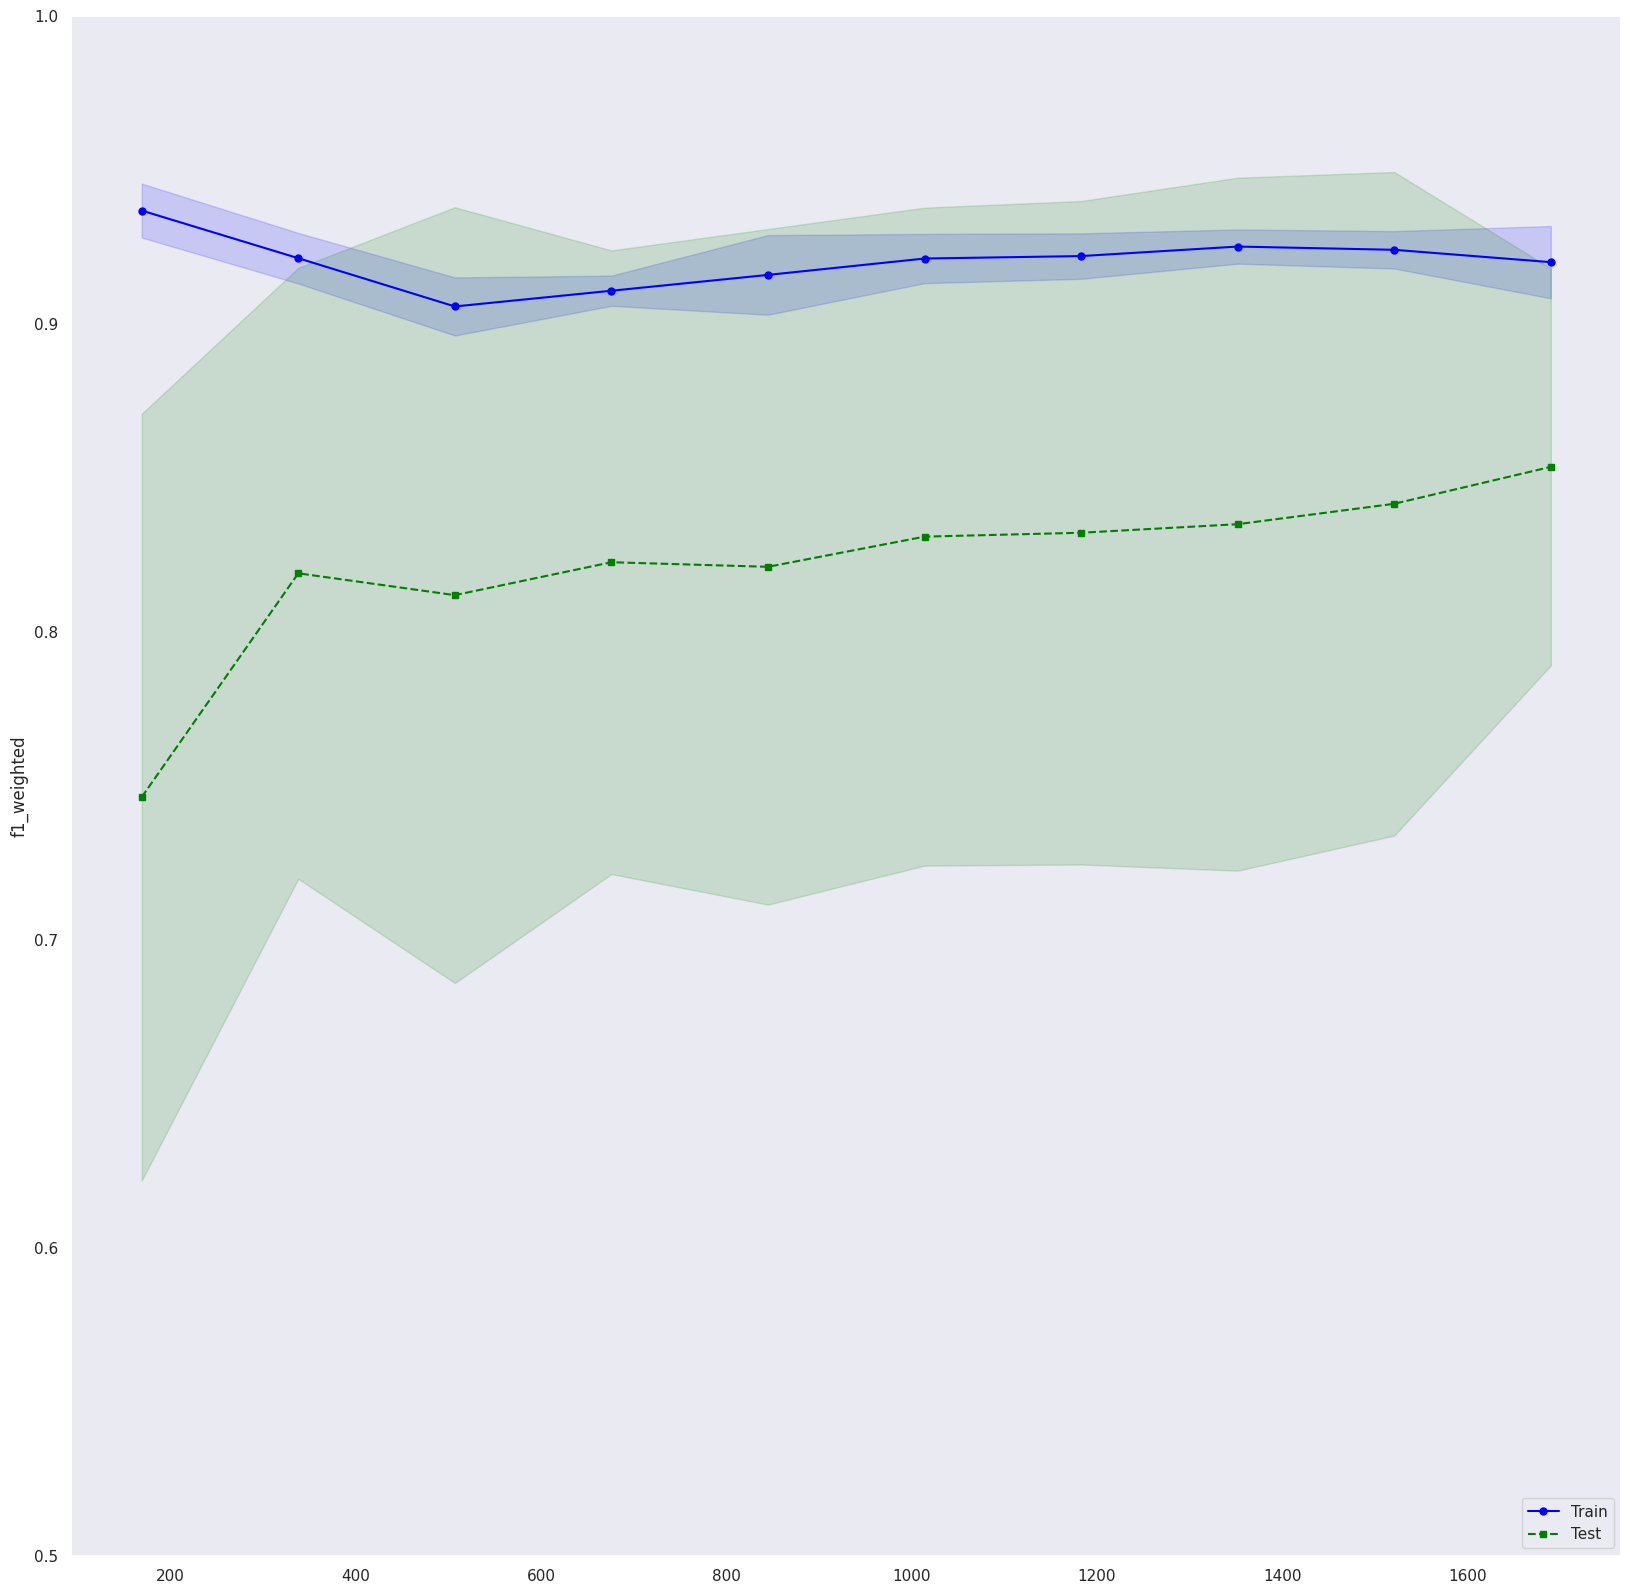

In [287]:
lr_final = LogisticRegression(random_state=42).fit(X, y)

lr_curve(X, y, lr_final, cv=5, scoring="f1_weighted")

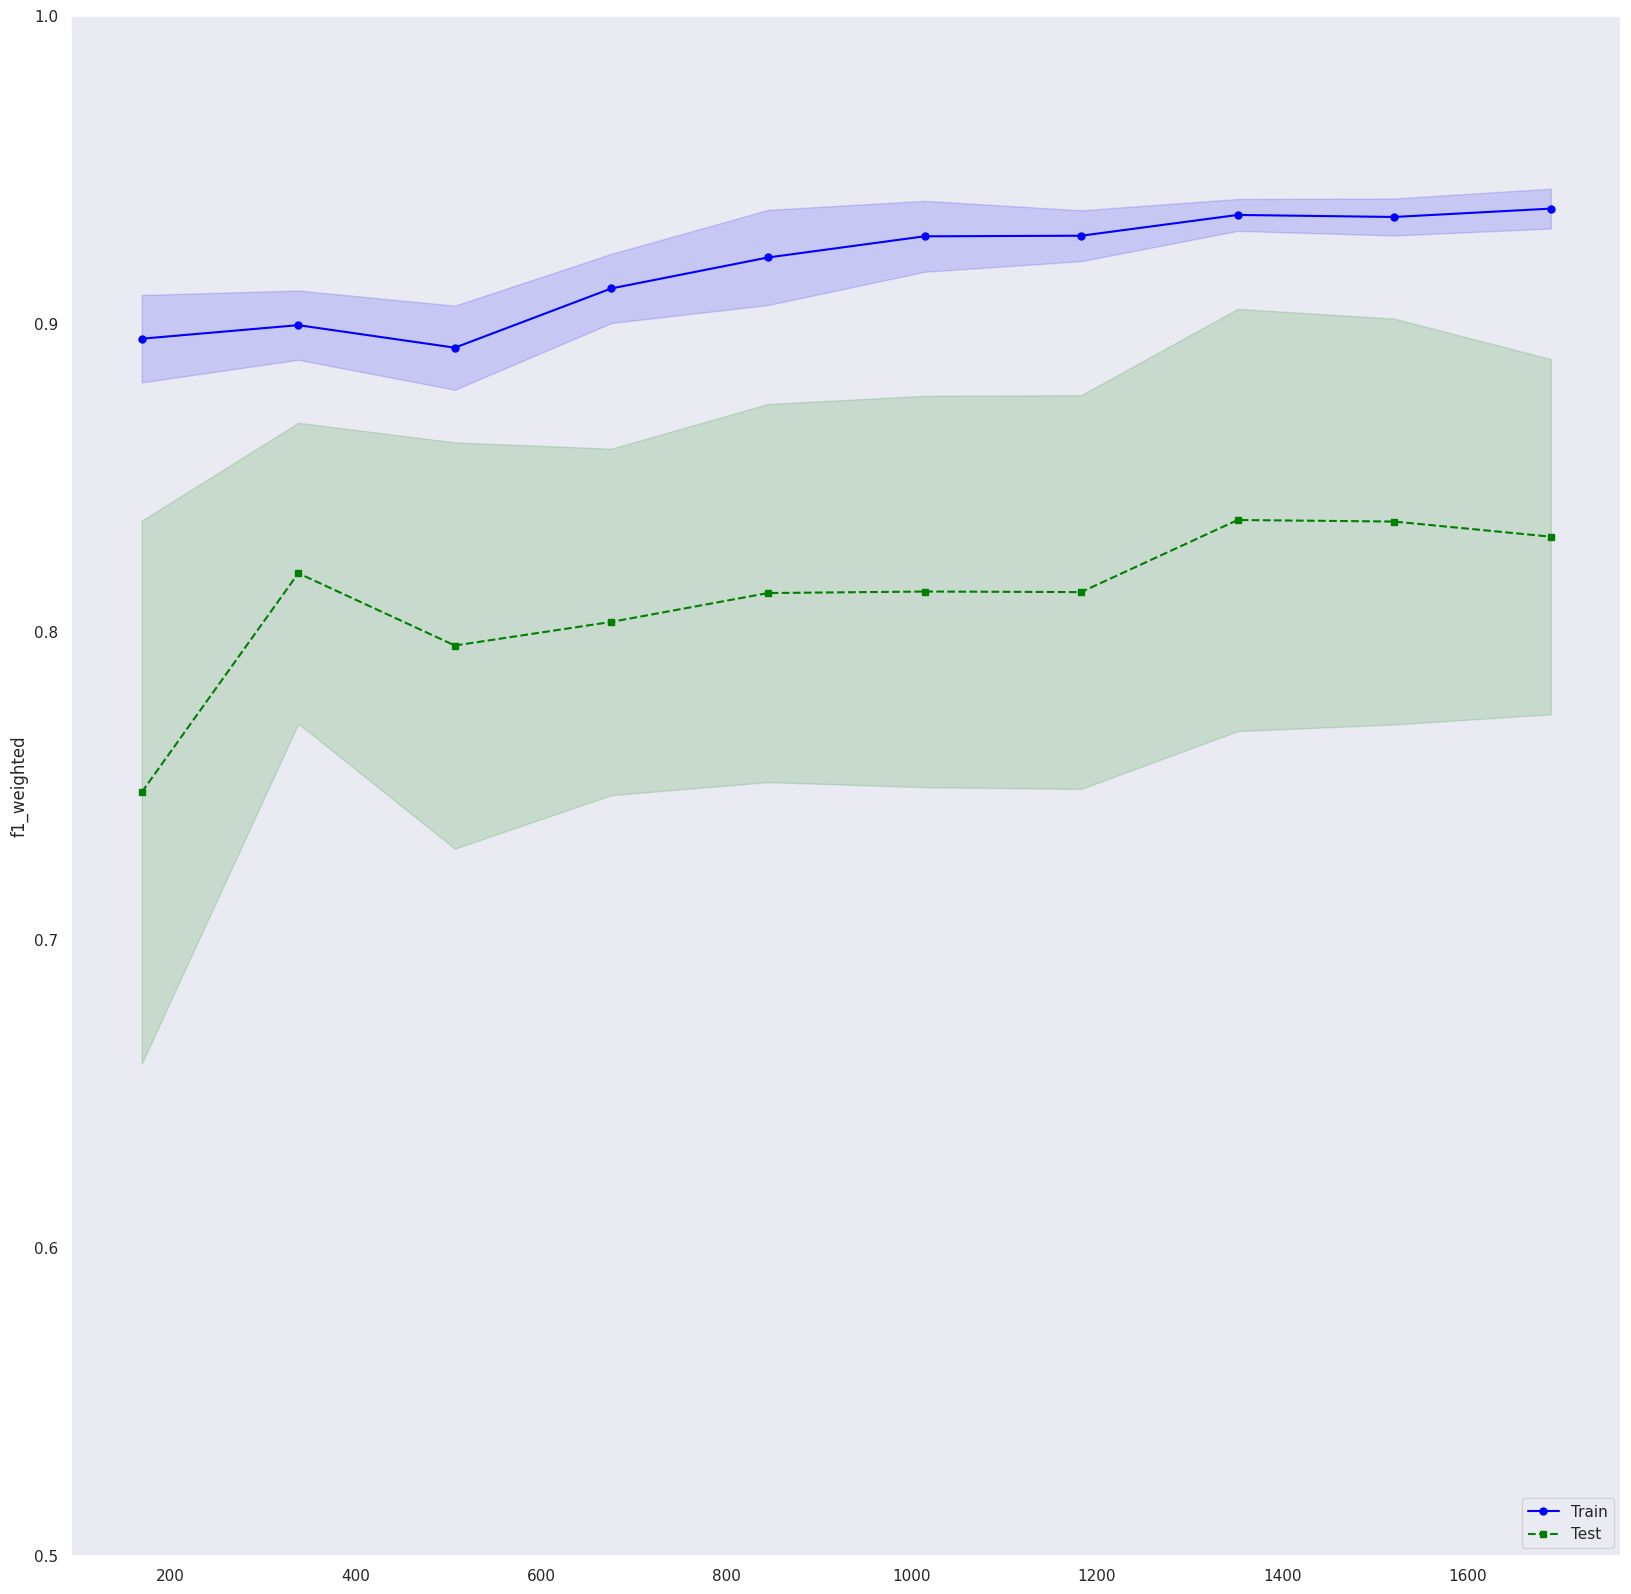

In [288]:
svc_final = SVC(random_state=42).fit(X,y)

lr_curve(X, y, svc_final, cv=5, scoring="f1_weighted")

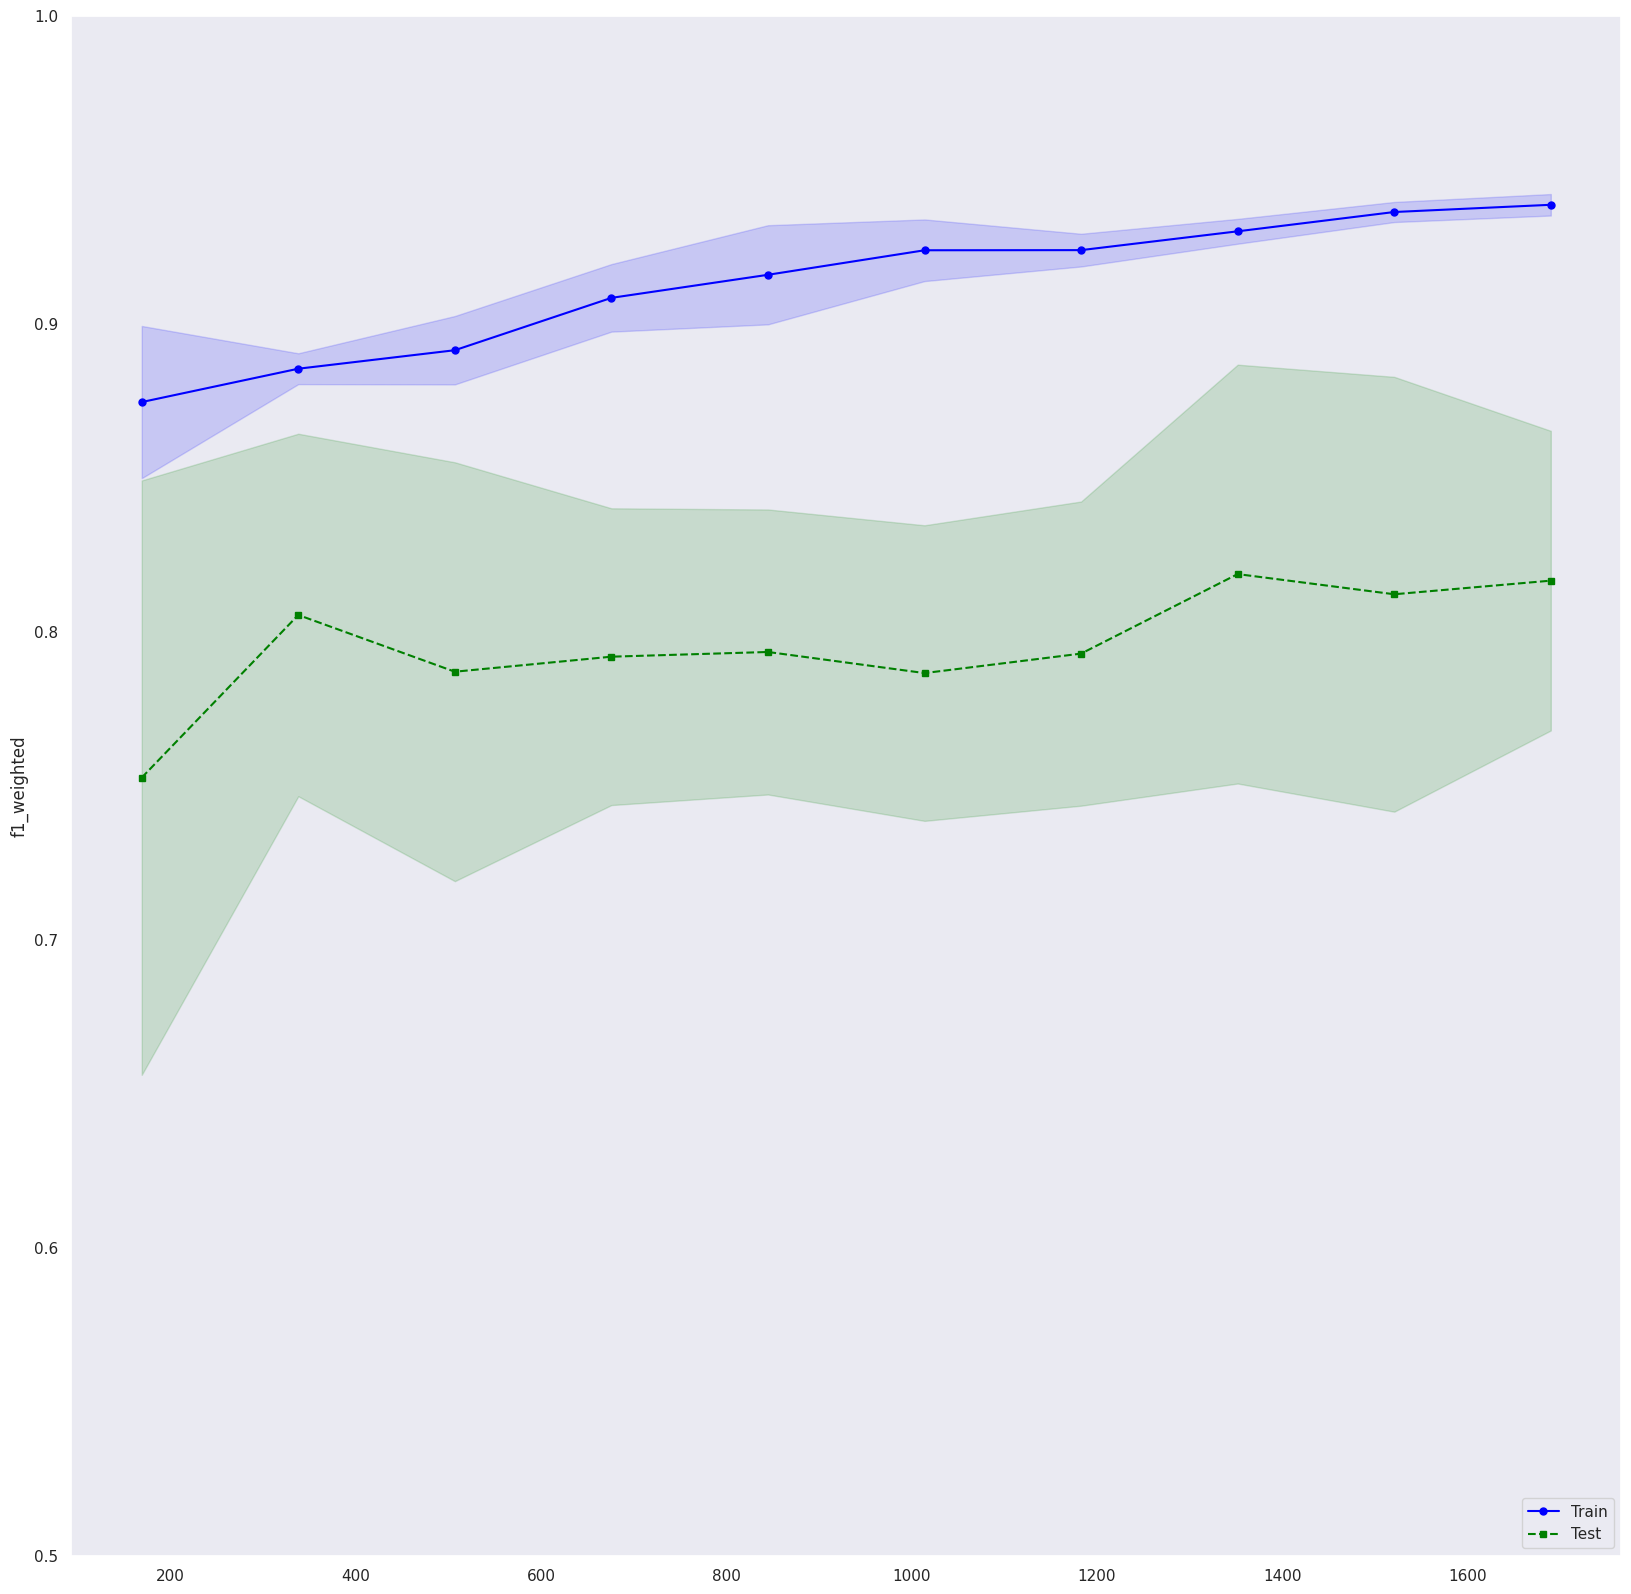

In [289]:
knn_final = KNeighborsClassifier().fit(X, y)

lr_curve(X, y, knn_final, cv=5, scoring="f1_weighted")

# 4. SMOTE w/ Feature Engineering


In [290]:
df_sf = df.copy()
df_sf.head()

baseline_value  accelerations  fetal_movement  uterine_contractions  light_decelerations  severe_decelerations  prolonged_decelerations  abnormal_short_term_variability  mean_value_of_short_term_variability  abnormal_long_term_variability  mean_value_of_long_term_variability  histogram_width  histogram_min  histogram_max  histogram_number_of_peaks  histogram_number_of_zeroes  histogram_mode  histogram_mean  histogram_median  histogram_variance  histogram_tendency  fetal_health  \
0      120.000001       0.000001        0.000001              0.000001             0.000001              0.000001                 0.000001                        73.000001                              0.500001                       43.000001                             2.400001        64.000001      62.000001     126.000001                   2.000001                    0.000001      120.000001      137.000001        121.000001           73.000001            1.000001           1.0   
1      132.000001       0.006001        0.000001              0.006001             0.003001              0.000001                 0.000001                        17.000001                              2.100001                        0.000001                            10.400001       130.000001      68.000001     198.000001                   6.000001                    1.000001      141.000001      136.000001        140.000001           12.000001            0.000001           0.0   
2      133.000001       0.003001        0.000001              0.008001             0.003001              0.000001                 0.000001                        16.000001                              2.100001                        0.000001                            13.400001       130.000001      68.000001     198.000001                   5.000001                    1.000001      141.000001      135.000001        138.000001           13.000001            0.000001           0.0   
3      134.000001       0.003001        0.000001              0.008001             0.003001              0.000001                 0.000001                        16.000001                              2.400001                        0.000001                            23.000001       117.000001      53.000001     170.000001                  11.000001                    0.000001      137.000001      134.000001        137.000001           13.000001            1.000001           0.0   
4      132.000001       0.007001        0.000001              0.008001             0.000001              0.000001                 0.000001                        16.000001                              2.400001                        0.000001                            19.900001       117.000001      53.000001     170.000001                   9.000001                    0.000001      137.000001      136.000001        138.000001           11.000001            1.000001           0.0   

   N_total_decelerations  N_short_term_variability_rate  N_long_term_variability_rate  N_abnormal_variability_score  N_mean_variability_score  N_total_variability  N_acceleration_ratio  N_deceleration_ratio  N_fetal_activity_ratio  histogram_symmetry  
0               0.000003                       0.993197                  9.471365e-01                    116.000002                  2.900002           118.900004              0.333333              1.000000                0.500000                16.0  
1               0.003003                       0.890052                  9.615383e-08                     17.000002                 12.500002            29.500004              0.499958              0.250187                0.000167                 4.0  
2               0.003003                       0.883978                  7.462685e-08                     16.000002                 15.500002            31.500004              0.272744              0.272926                0.000125                 3.0  
3               0.003003                       0.869565       

In [291]:
#Feature Prep
df_sf[num_cols] = df_sf[num_cols] = df_sf[num_cols] + 0.000001

df_sf['N_total_decelerations'] = df_sf['light_decelerations'] + df_sf['severe_decelerations'] + df_sf['prolonged_decelerations']

# Percentage of abnormal short and long variability rate
df_sf['N_short_term_variability_rate'] = df_sf['abnormal_short_term_variability'] / (df_sf['abnormal_short_term_variability'] + df_sf['mean_value_of_short_term_variability'])
df_sf['N_long_term_variability_rate'] = df_sf['abnormal_long_term_variability'] / (df_sf['abnormal_long_term_variability'] + df_sf['mean_value_of_long_term_variability'])

# Score of abnormal and normal variability
df_sf['N_abnormal_variability_score'] = df_sf['abnormal_short_term_variability'] + df_sf['abnormal_long_term_variability']
df_sf['N_mean_variability_score'] = df_sf['mean_value_of_short_term_variability'] + df_sf['mean_value_of_long_term_variability']

# Total Variability: Kısa vadeli ve uzun vadeli değişkenliğin toplamı.
df_sf['N_total_variability'] = df_sf['N_abnormal_variability_score'] + df_sf['N_mean_variability_score']

# Acceleration Ratio: Accelerations sayısının toplam fetal hareket sayısına oranı.
df_sf['N_acceleration_ratio'] = df_sf['accelerations'] / (df_sf['fetal_movement'] + df_sf['accelerations'] + df_sf['uterine_contractions'])

# Deceleration Ratio: Decelerations sayısının toplam fetal hareket sayısına oranı.
df_sf['N_deceleration_ratio'] = df_sf['N_total_decelerations'] / (df_sf['fetal_movement'] + df_sf['accelerations'] + df_sf['uterine_contractions'])

# Fetal activity ratio
df_sf["N_fetal_activity_ratio"] = df_sf["fetal_movement"] / (df_sf["fetal_movement"] + df_sf["uterine_contractions"])

# Histogtam symmetry
df_sf["histogram_symmetry"] = np.abs(df_sf["histogram_mean"] - df_sf["histogram_median"])

In [292]:
X = df_sf.drop("fetal_health", axis=1)
y = df_sf["fetal_health"]
print(df_sf.shape)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X, y = smote_df(X, y)


(2113, 32)


In [293]:

base_models(X, y, all_scoring)

Base Models....
LR
f1_score: 0.882
Accuracy: 0.8821
Recall: 0.8821
Precision: 0.8895
-------------
KNN
f1_score: 0.92
Accuracy: 0.9218
Recall: 0.9218
Precision: 0.9325
-------------
SVC
f1_score: 0.9207
Accuracy: 0.9212
Recall: 0.9212
Precision: 0.929
-------------
CART
f1_score: 0.9099
Accuracy: 0.9129
Recall: 0.9129
Precision: 0.9189
-------------
RF
f1_score: 0.9463
Accuracy: 0.9479
Recall: 0.9479
Precision: 0.9525
-------------
Adaboost
f1_score: 0.8708
Accuracy: 0.8702
Recall: 0.8702
Precision: 0.8788
-------------
GBM
f1_score: 0.9359
Accuracy: 0.938
Recall: 0.938
Precision: 0.9436
-------------
XGBoost
f1_score: 0.9469
Accuracy: 0.9485
Recall: 0.9485
Precision: 0.9531
-------------
LightGBM
f1_score: 0.946
Accuracy: 0.9477
Recall: 0.9477
Precision: 0.9524
-------------
CatBoost
f1_score: 0.9464
Accuracy: 0.9481
Recall: 0.9481
Precision: 0.9529
-------------
GNB
f1_score: 0.7512
Accuracy: 0.7495
Recall: 0.7495
Precision: 0.8016
-------------


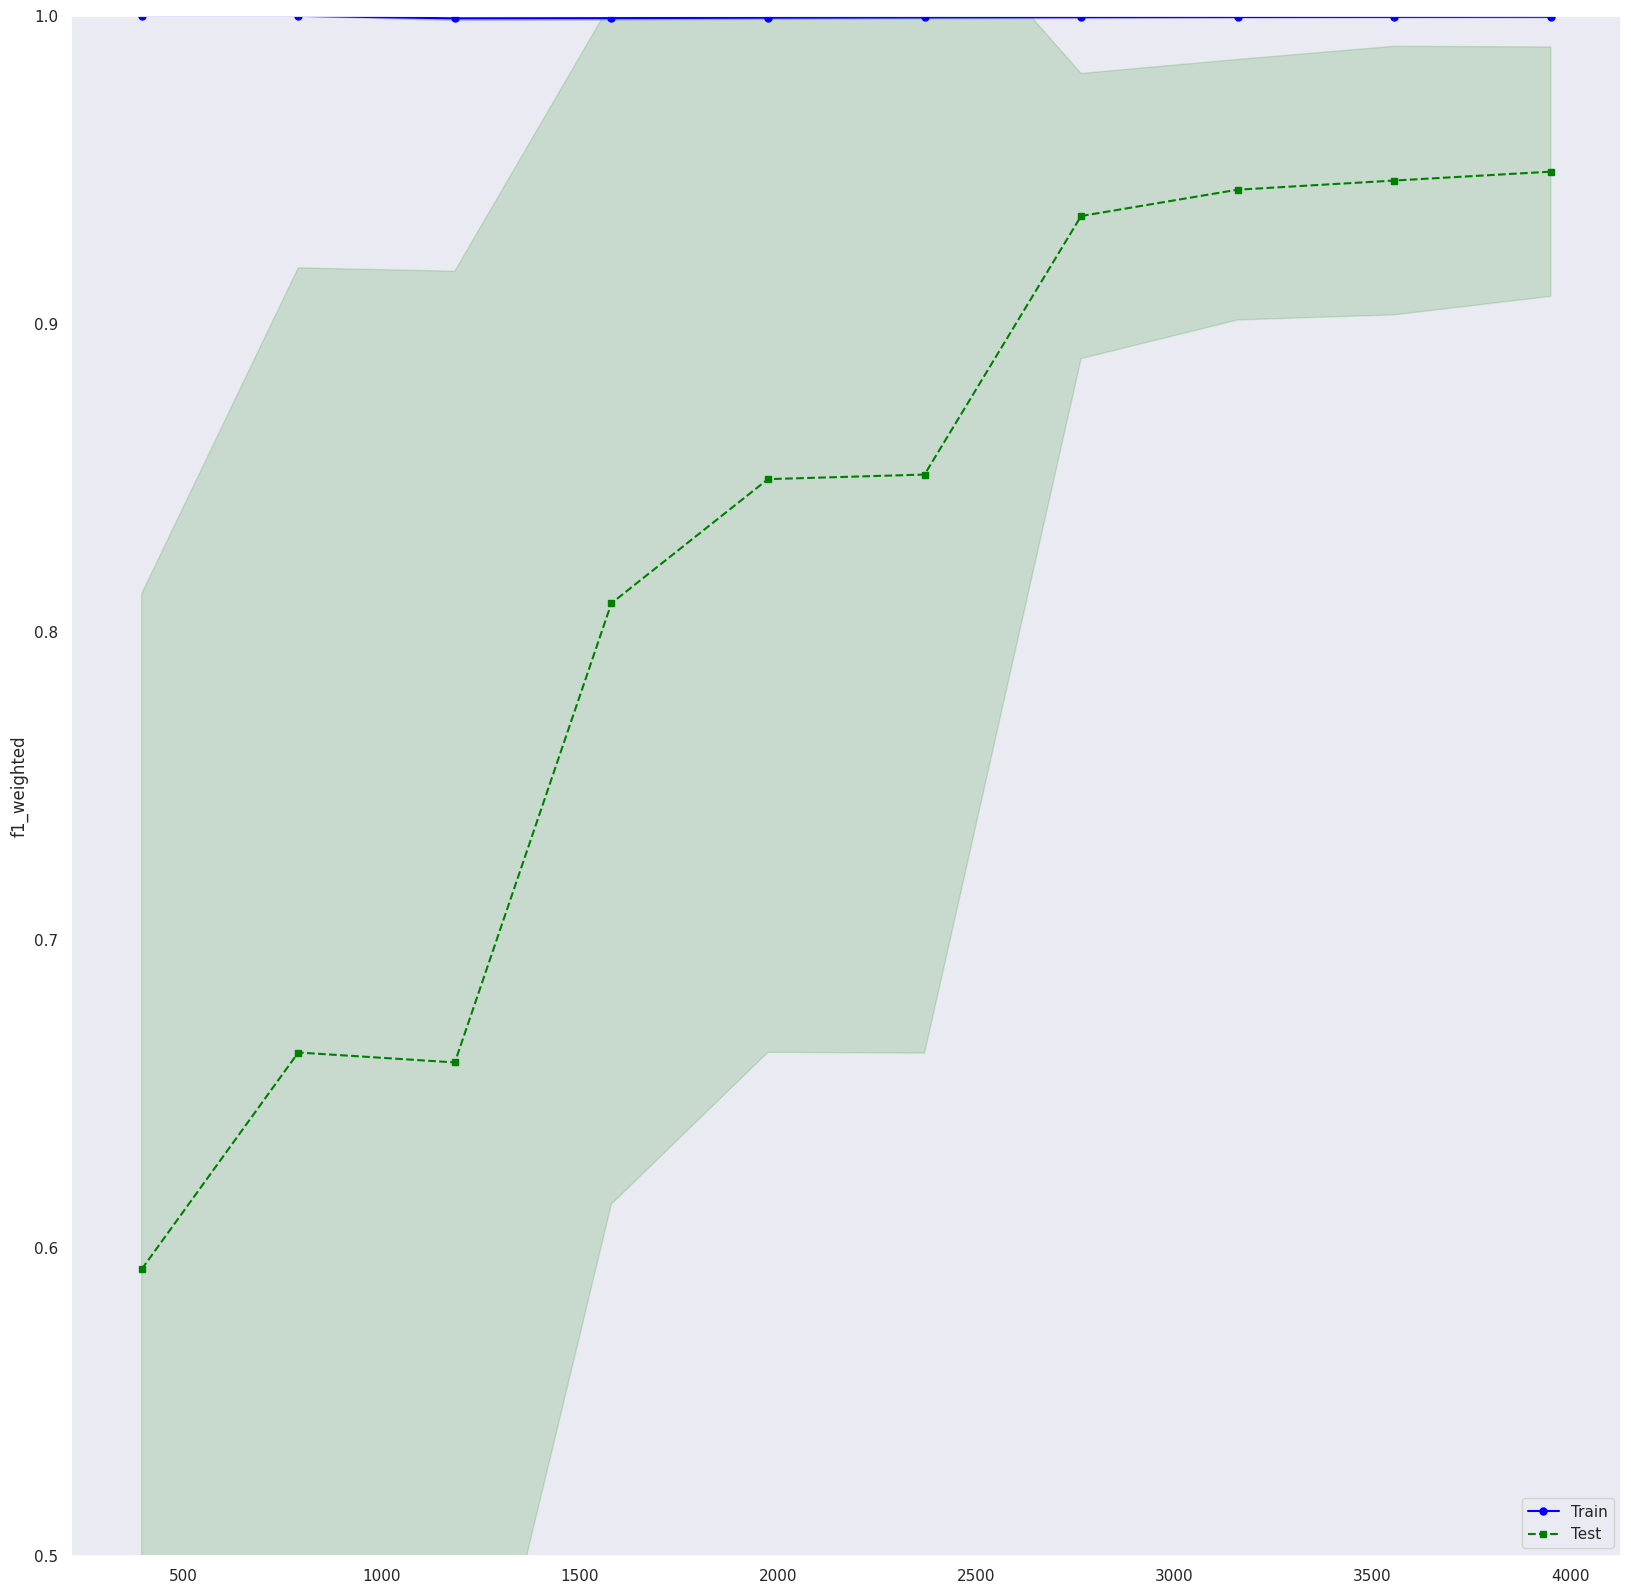

In [294]:
lgbm_final = LGBMClassifier(verbose= -1, random_state=42).fit(X, y)
lr_curve(X, y, lgbm_final, cv=5, scoring="f1_weighted")

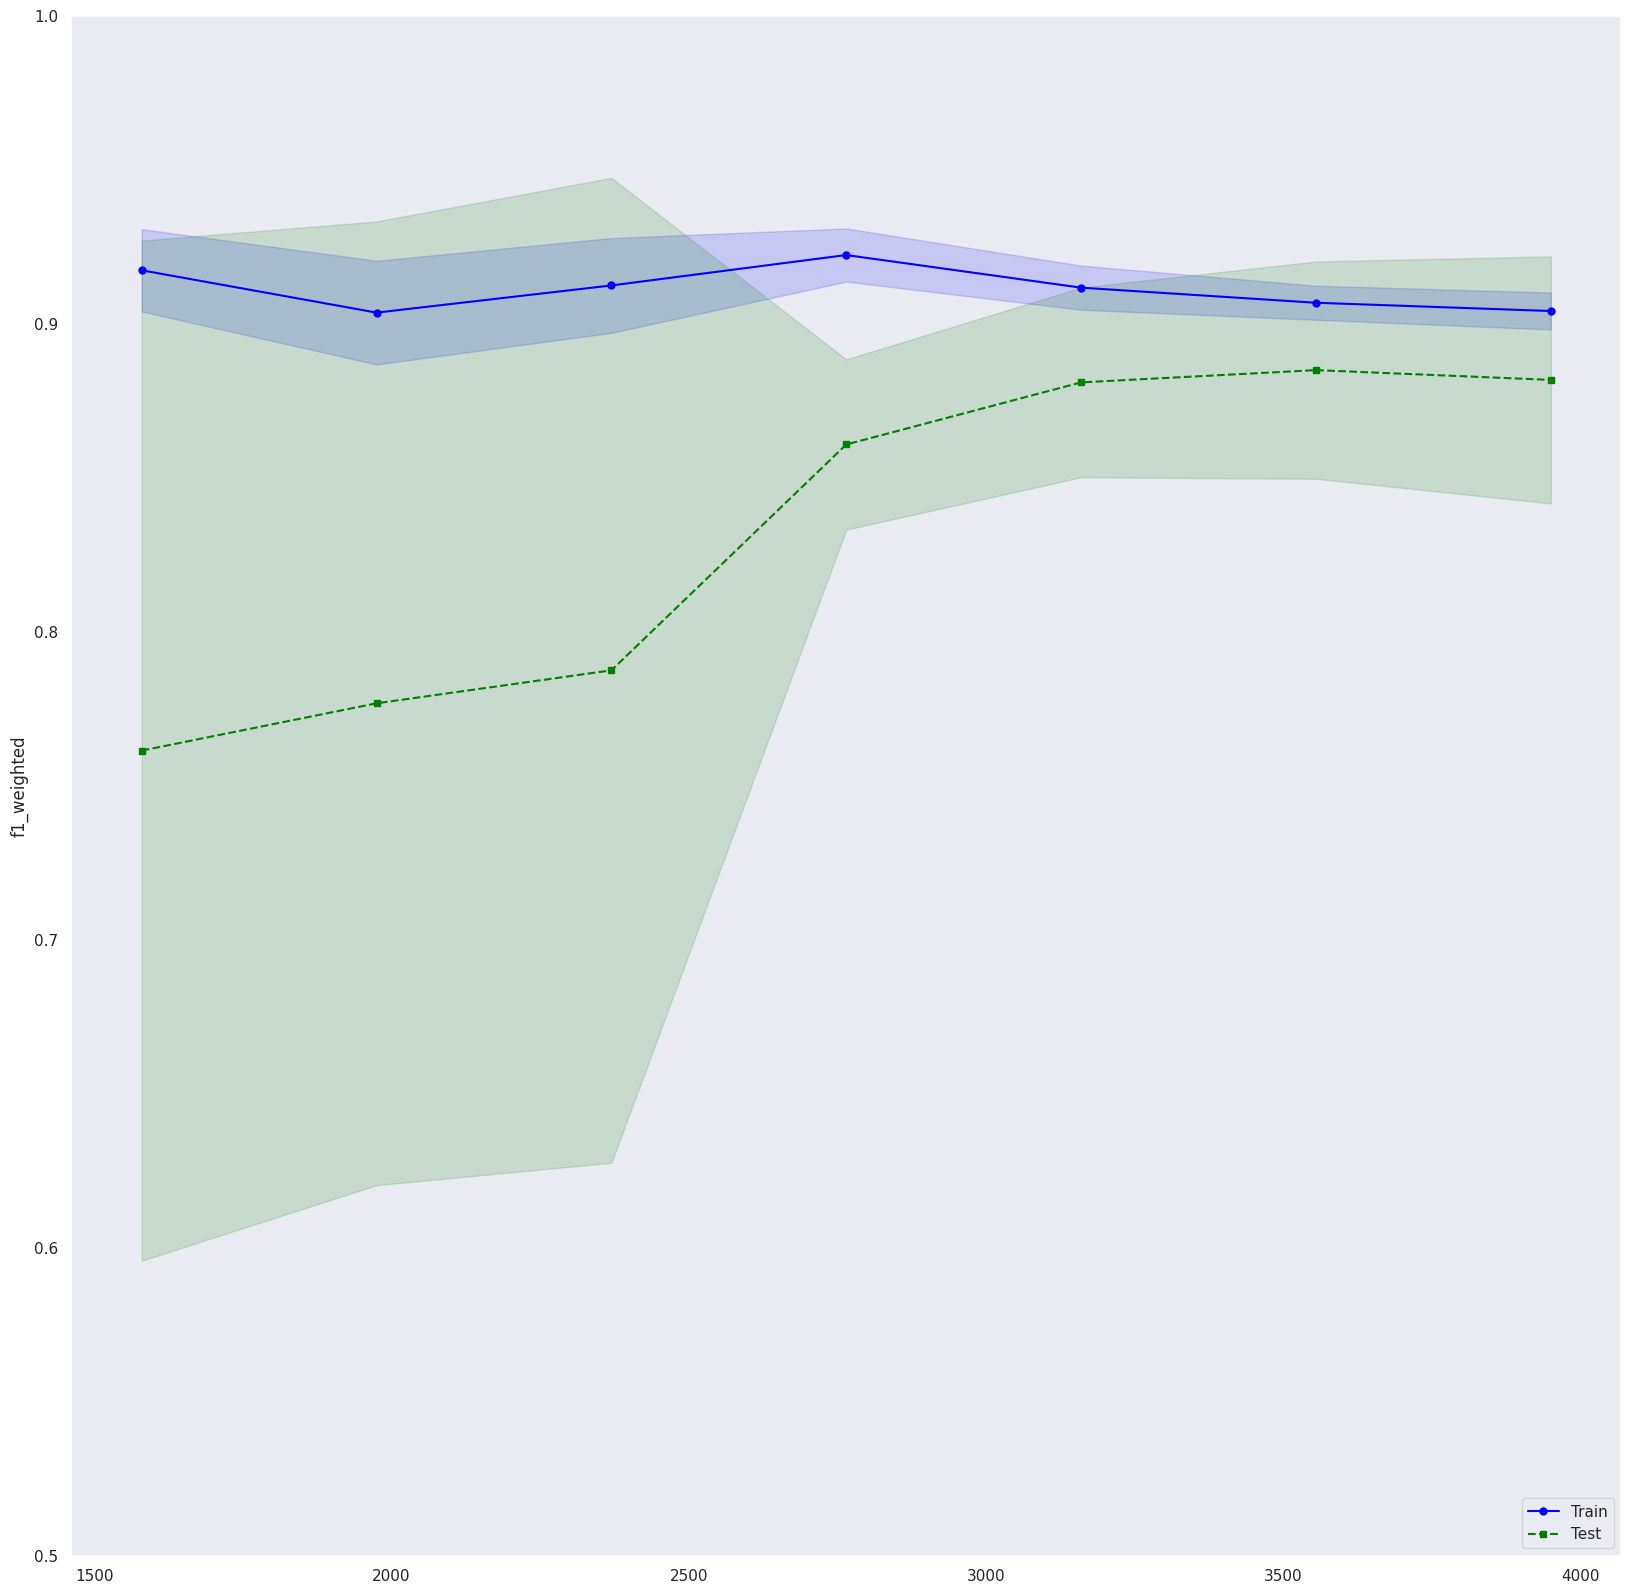

In [295]:
lr_final = LogisticRegression(random_state=42).fit(X, y)

lr_curve(X, y, lr_final, cv=5, scoring="f1_weighted")

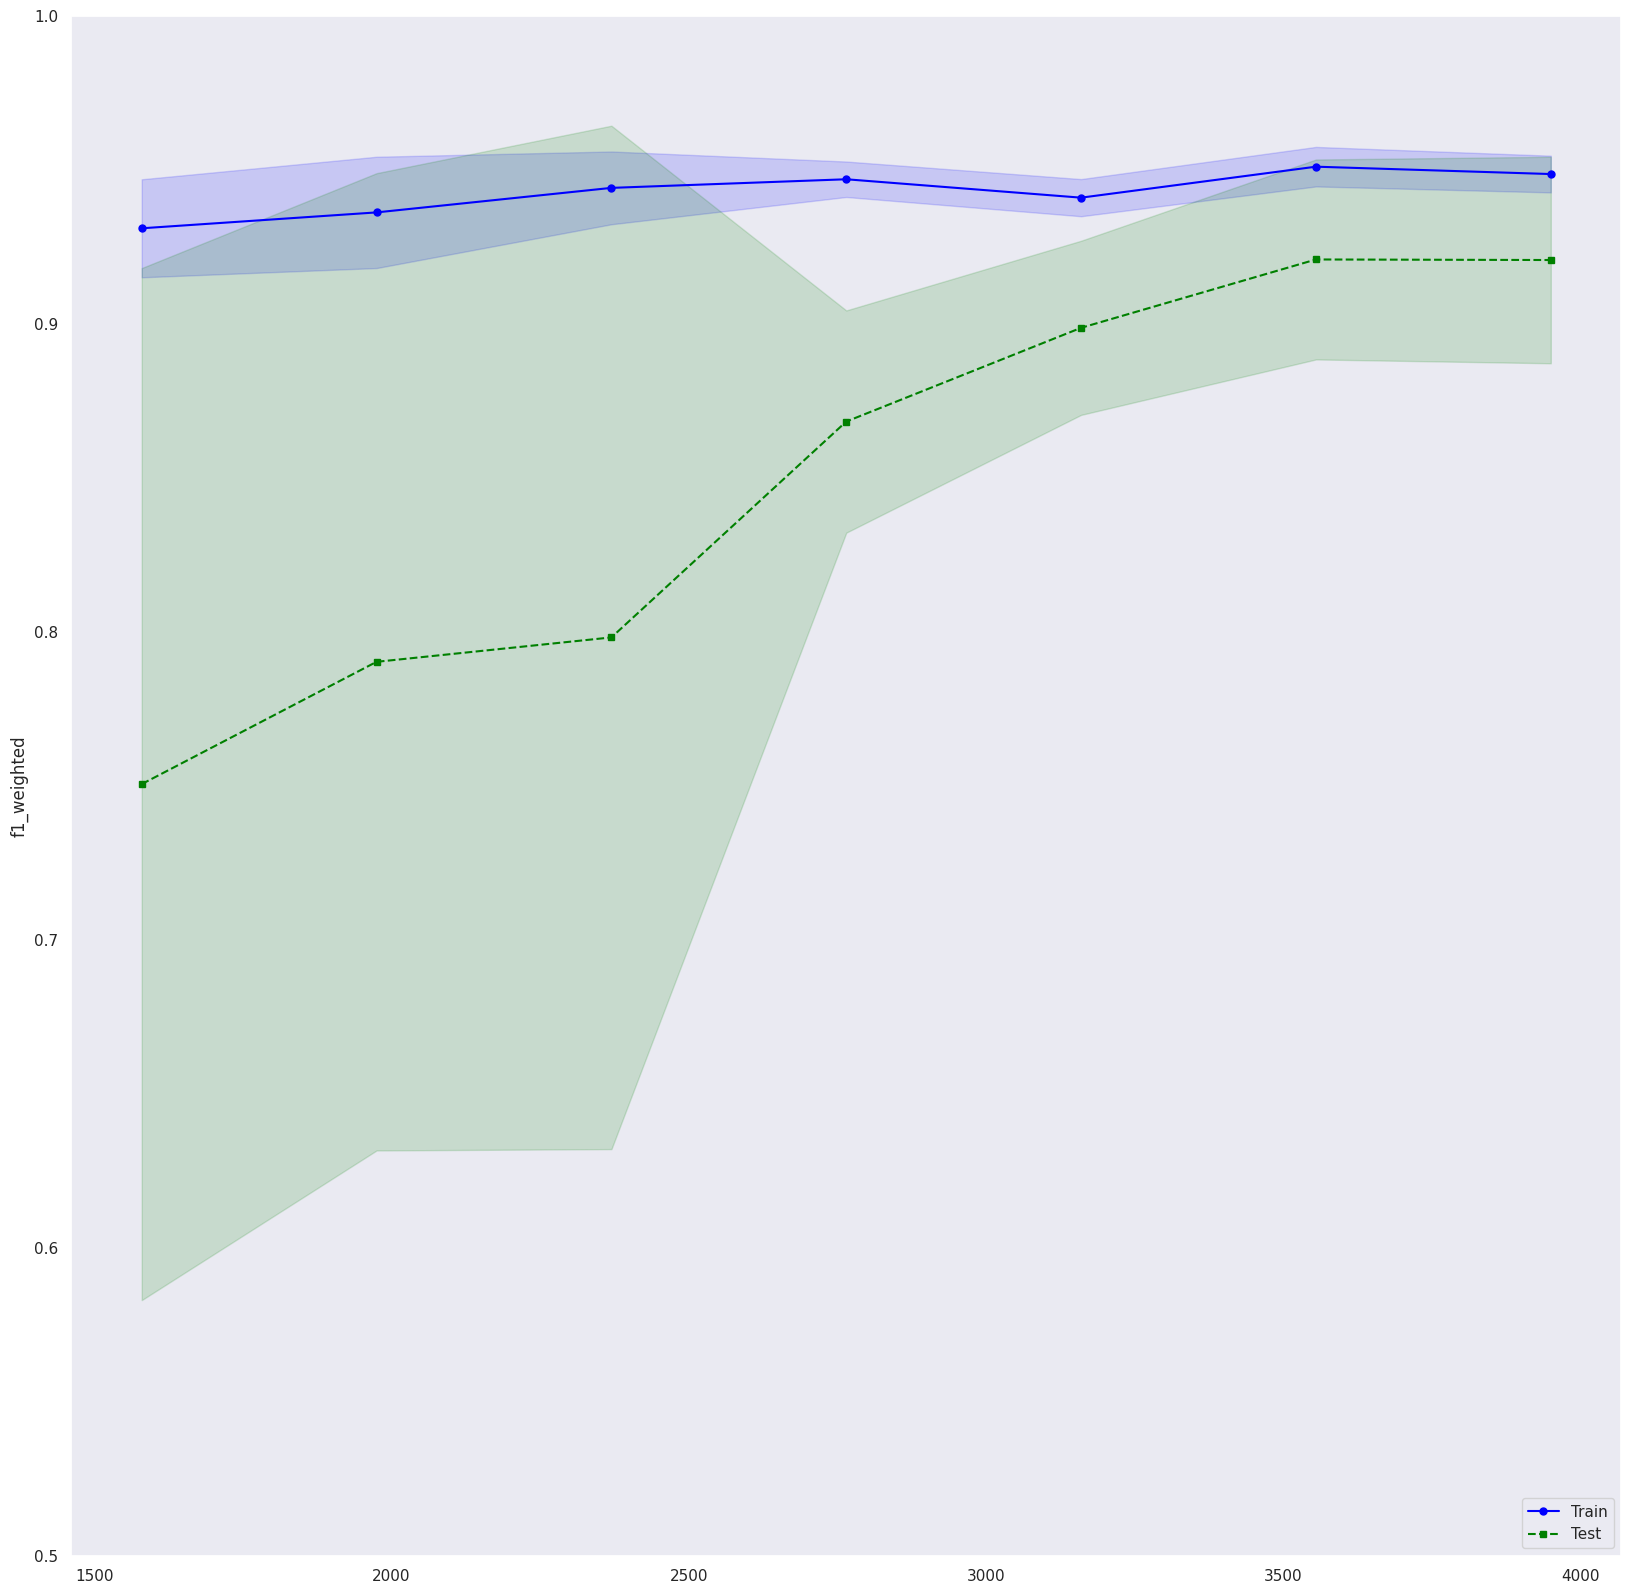

In [296]:
svc_final = SVC(random_state=42).fit(X,y)

lr_curve(X, y, svc_final, cv=5, scoring="f1_weighted")

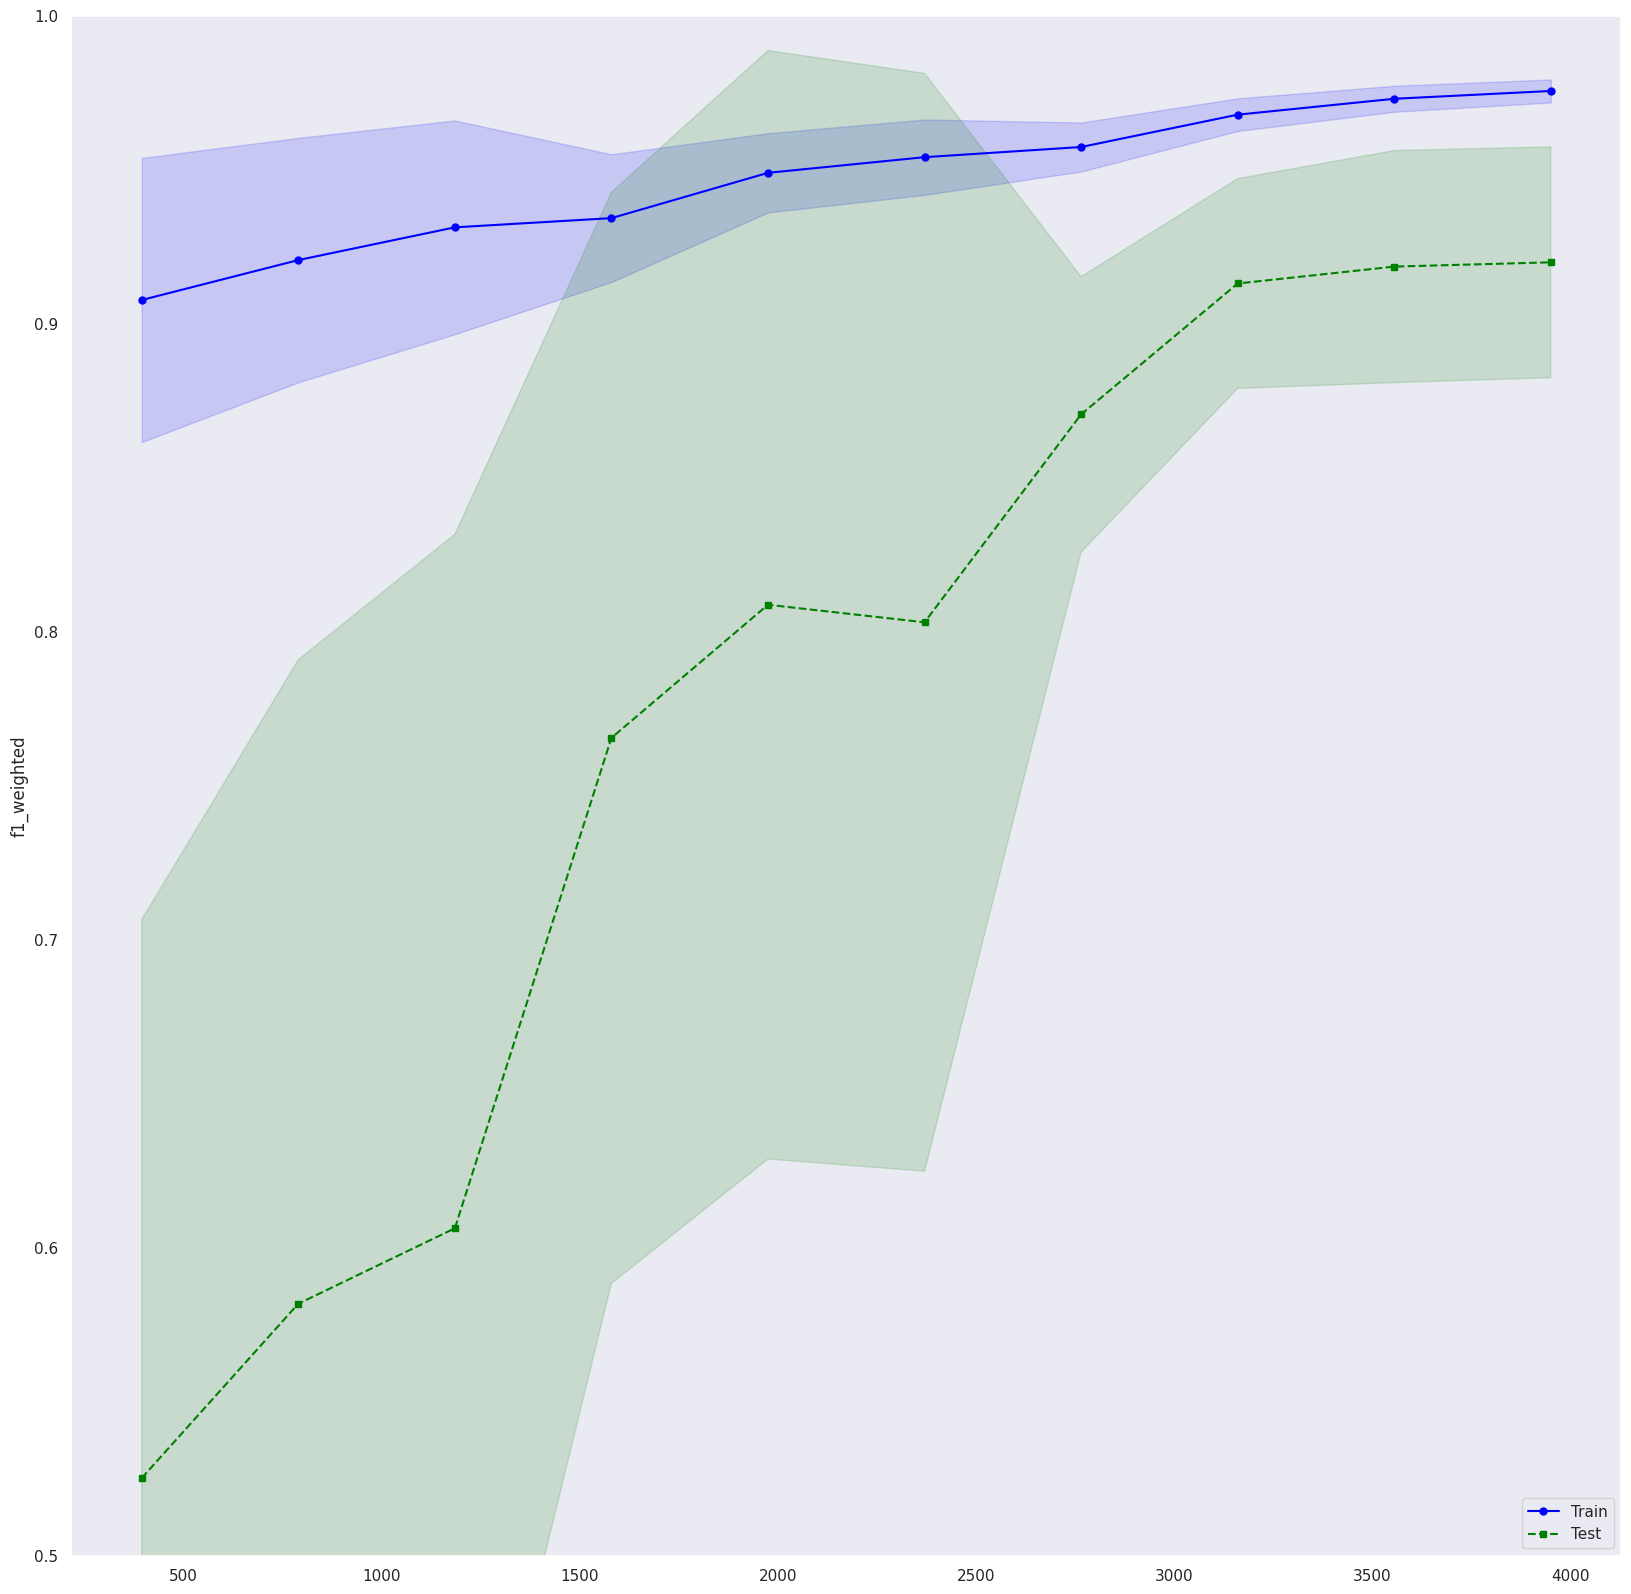

In [297]:
knn_final = KNeighborsClassifier().fit(X, y)

lr_curve(X, y, knn_final, cv=5, scoring="f1_weighted")

# 5. Hyperparameter Optimization

In [298]:
lr_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 10],
    'max_iter': [100, 200, 300],
    'tol': [0.001, 0.0001]
}

classifiers = [("LR", LogisticRegression(random_state=42), lr_params)
]

scoring = {'f1_score': make_scorer(f1_score, average='weighted'),
           'auc_score': make_scorer(lambda y_in, y_p_in: roc_auc_score(y_in, y_p_in, multi_class='ovr'), needs_proba=True)

          }
best_models = hyperparameter_optimization(X, y, scoring= scoring)

Hyperparameter Optimization....
########## LR ##########
f1_score: 0.8821
auc_score: 0.9667
LR best params: {'C': 10, 'max_iter': 300, 'penalty': 'l2', 'tol': 0.001}



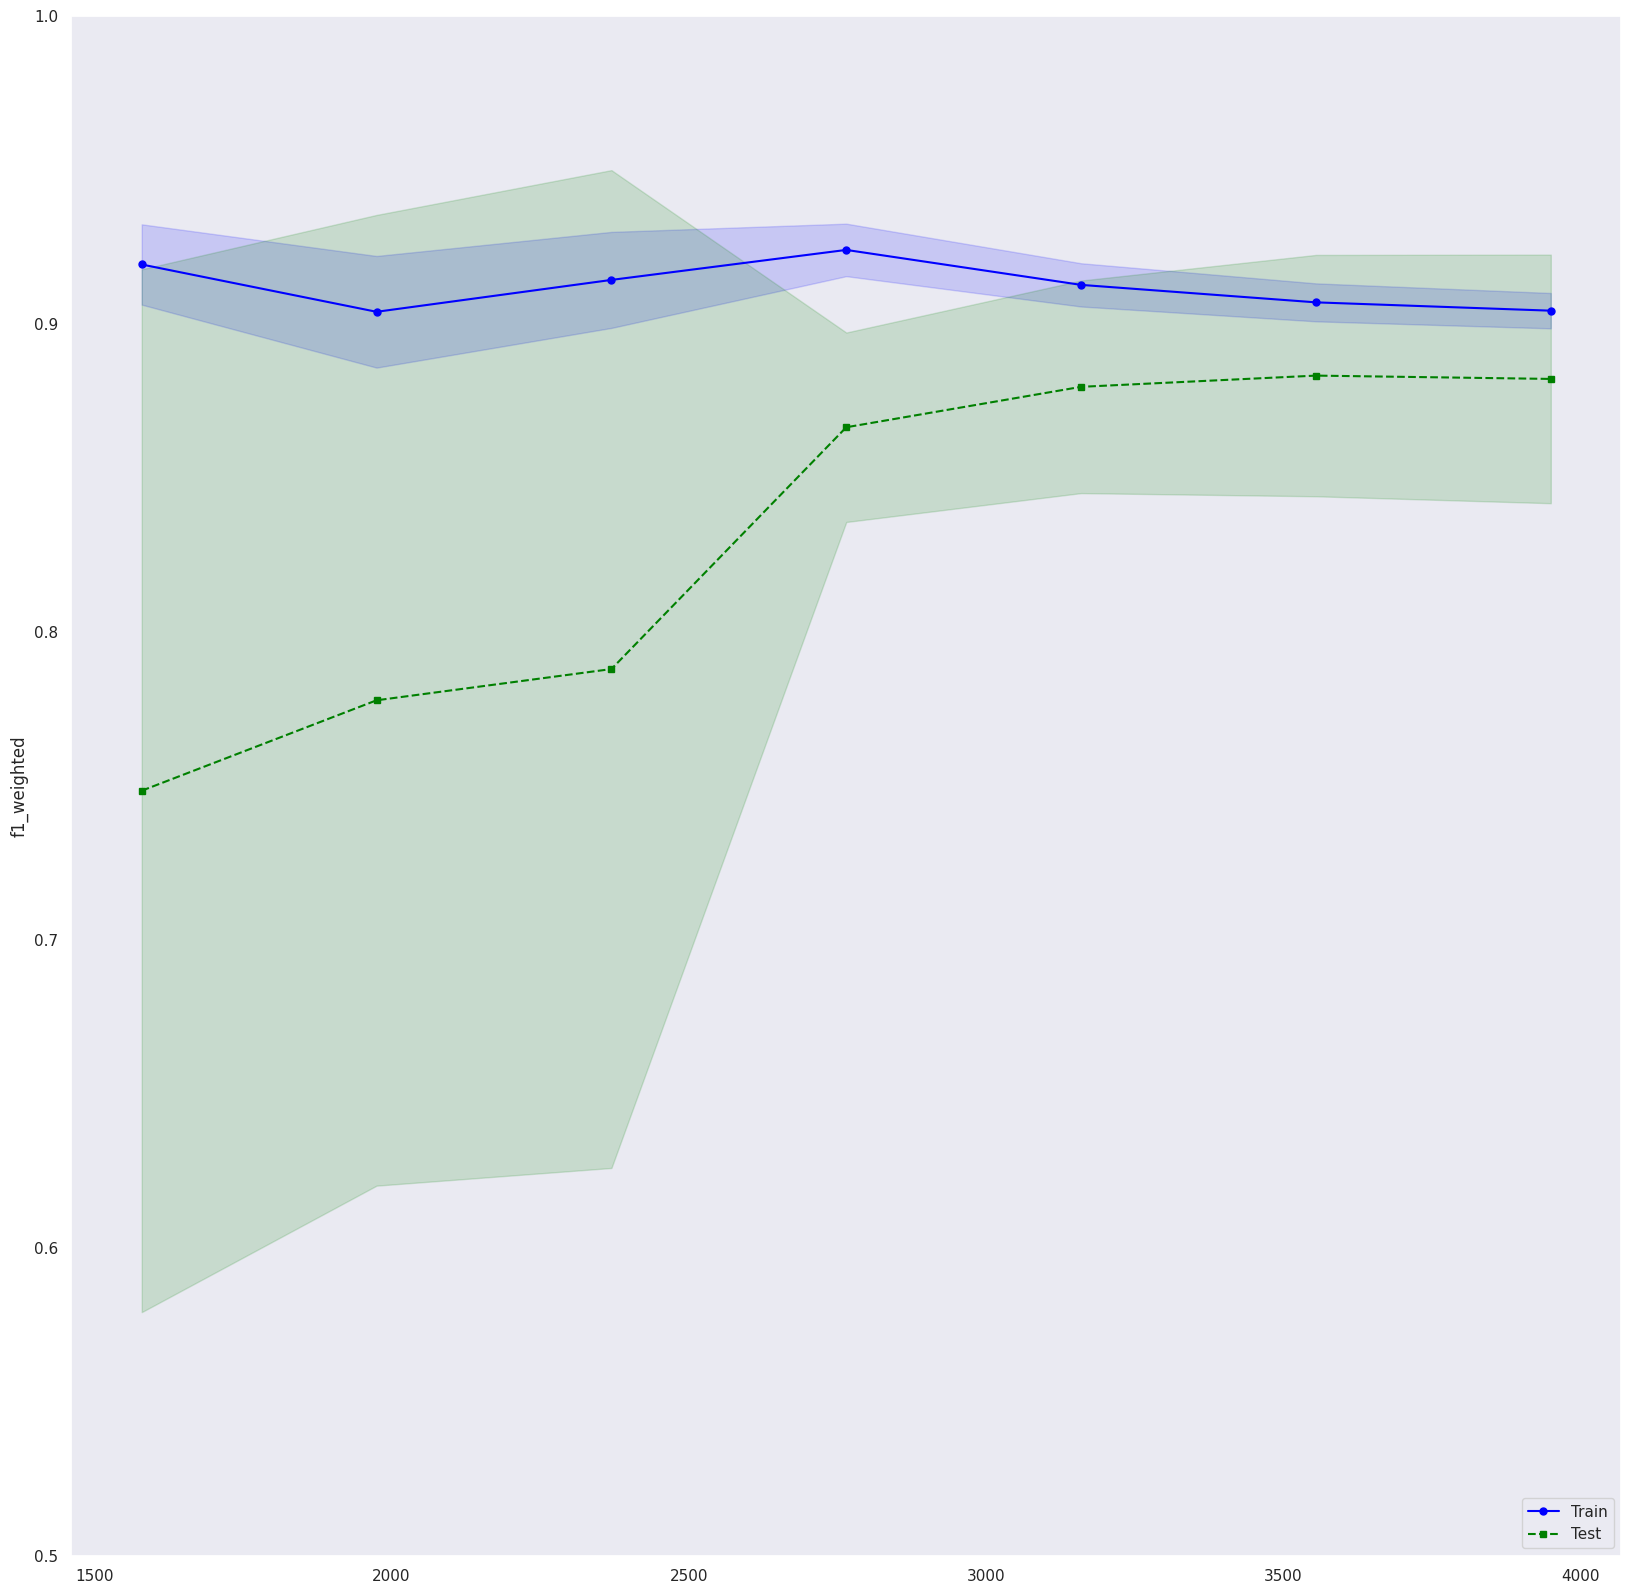

In [299]:
lr_final = LogisticRegression(C= 10, max_iter= 300, penalty= 'l2', tol= 0.001,random_state=42).fit(X, y)

lr_curve(X, y, lr_final, cv=5, scoring="f1_weighted")